In [1]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
from torch.autograd import Variable
from torch.autograd import Variable
import torchvision.models as models

import numpy as np
import matplotlib.pyplot as plt
import math

% matplotlib inline

CUDA = False

In [2]:
class CausalConv1d(nn.Conv1d):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, dilation=1, groups=1, bias=True):
        super(CausalConv1d, self).__init__(in_channels, out_channels, kernel_size, stride=stride, padding=0,
            dilation=dilation, groups=groups, bias=bias)

        self.left_padding = dilation * (kernel_size - 1)
        
    def forward(self, input):
        temp = torch.unsqueeze(input, 0)
        x = F.pad(temp, (self.left_padding, 0, 0, 0))
        x = torch.squeeze(x, 0)
        
        return super(CausalConv1d, self).forward(x)

In [3]:
class OneHot(nn.Module):
    def __init__(self, quant):
        super(OneHot, self).__init__()
        self.one = torch.sparse.torch.eye(quant)
        
    def forward(self, input):
        return Variable(self.one.index_select(0, input.data)).unsqueeze(0).transpose(1,2)

In [4]:
class WaveNet(nn.Module):
    def __init__(self, quant = 256, res_size = 512, skip_size = 256, dilation_layers = 10, stacks = 3):
        super(WaveNet, self).__init__()
        self.dilation_layers = dilation_layers
        self.dilations = dilations = [(2**dilation) for dilation in range(dilation_layers)] * stacks
        self.one_hot = OneHot(quant)
        
        self.causal_conv = CausalConv1d(skip_size, res_size, 1)
        
        self.dial_conv = nn.ModuleList([CausalConv1d(res_size, res_size, 2, dilation = d) for d in dilations])
       
        self.dial_skip_conv = nn.ModuleList([CausalConv1d(skip_size, skip_size, 1) for _ in dilations])
        self.dial_res_conv = nn.ModuleList([CausalConv1d(skip_size, res_size, 1) for _ in dilations])
        
        self.end_conv1 = nn.Conv1d(in_channels = skip_size, out_channels = skip_size, kernel_size = 1)
        self.end_conv2 = nn.Conv1d(in_channels = skip_size, out_channels = quant, kernel_size = 1)

    def forward(self, input):
        output = self.one_hot(input)
        output = self.causal_conv(output)
        
        skip_sum = []
        for d_conv, skip_conv, res_conv in zip(self.dial_conv, self.dial_skip_conv, self.dial_res_conv):
            res_output = output
            
            gate_output = self.gated_unit(res_output, d_conv)
            
            output = res_conv(gate_output)
            output = output + res_output[:,:,-output.size(2):]
            
            skip = skip_conv(gate_output)
            skip_sum.append(skip)
        
        output = sum([s[:,:,-output.size(2):] for s in skip_sum])
        
        output = self.postprocess(output)
        
        return output
    
    def gated_unit(self, input, dial_conv):
        output = dial_conv(input)        
        
        output_sigmoid = output[0][256:].unsqueeze(0)
        output_tanh = output[0][:256].unsqueeze(0)
        
        output = F.sigmoid(output_sigmoid) * F.tanh(output_tanh)
        
        return output
        
    def postprocess(self, input):
        output = F.relu(input)
        output = self.end_conv1(output)
        output = F.relu(output)
        output = self.end_conv2(output).squeeze(0).transpose(0,1)

        return output

In [5]:
def mu_encoder(input):        
    mu = torch.FloatTensor([255])
    x_mu = torch.sign(input) * torch.log1p(mu * torch.abs(input)) / torch.log1p(mu)
    x_mu = ((x_mu + 1) / 2 * mu + 0.5).long()
    
    return x_mu.type(torch.FloatTensor) 

In [ ]:
def mu_encoder(input):        
    mu = torch.FloatTensor([255])
    x_mu = torch.sign(input) * torch.log1p(1 + (mu * torch.abs(input))) / torch.log1p(1 + mu)
    x_mu = ((x_mu + 1) / 2 * mu)
    
    return x_mu.type(torch.FloatTensor) 

In [6]:
def mu_decoder(input):
    mu = torch.FloatTensor([255])
    x = ((input) / mu) * 2 - 1.
    x = torch.sign(x) * (torch.exp(torch.abs(x) * torch.log1p(mu)) - 1) / mu
    
    return x

In [ ]:
def mu_decoder(input):
    mu = torch.FloatTensor([255])
    x = ((input) / mu) * 2 - 1
    x = torch.sign(x) * ((mu + 1)**torch.abs(x) - 1) / mu
    
    return x

# Data Generator

In [7]:
def batch_generator():
    while True:
        xs = np.linspace(0, np.pi*10, 4000)
        ys = np.sin(xs)
        ys = ys.astype(np.float32)
        x = torch.from_numpy(ys).view(1,1,-1)
        if (torch.cuda.is_available() and CUDA):
            x = x.cuda()
            y = y.cuda()
            
        yield x

g = batch_generator()

In [ ]:
x = next(g)
plt.figure(figsize=[8,6])
plt.plot(Variable(x).cpu().data.numpy()[0][0],'.', ms=3)

temp = mu_encoder(x)
# plt.figure(figsize=[8,6])
# plt.plot(Variable(temp).cpu().data.numpy()[0][0],'.', ms=3)

temp = mu_decoder(temp)
# plt.figure(figsize=[8,6])
plt.plot(Variable(temp).cpu().data.numpy()[0][0],'.', ms=3)

Batch 0 done
Batch 1 done
Batch 2 done
Batch 3 done
Batch 4 done
Batch 5 done
Batch 6 done
Batch 7 done
Batch 8 done
Batch 9 done
Batch 10 done
Batch 11 done
Batch 12 done
Batch 13 done
Batch 14 done
Batch 15 done
epoch 0, loss 5.54304456711


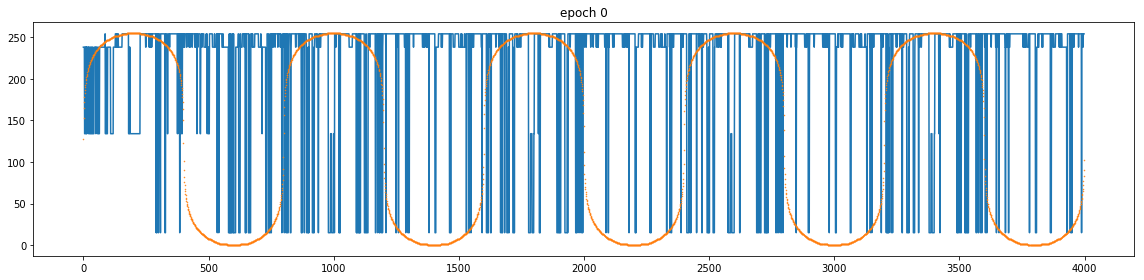

Batch 0 done
Batch 1 done
Batch 2 done
Batch 3 done
Batch 4 done
Batch 5 done
Batch 6 done
Batch 7 done
Batch 8 done
Batch 9 done
Batch 10 done
Batch 11 done
Batch 12 done
Batch 13 done
Batch 14 done
Batch 15 done
epoch 1, loss 5.34525346756


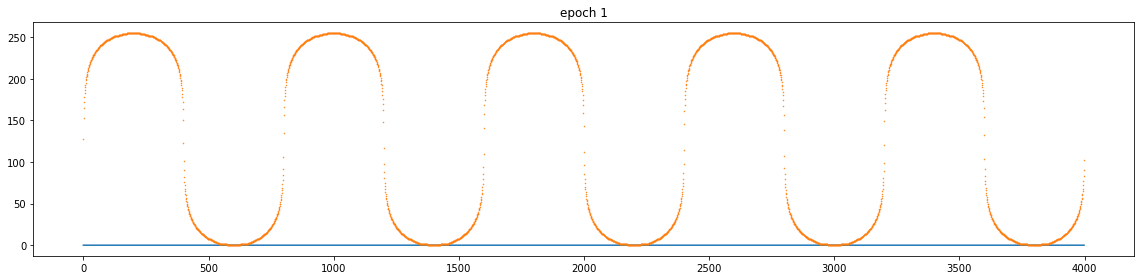

Batch 0 done
Batch 1 done
Batch 2 done
Batch 3 done
Batch 4 done
Batch 5 done
Batch 6 done
Batch 7 done
Batch 8 done
Batch 9 done
Batch 10 done
Batch 11 done
Batch 12 done
Batch 13 done
Batch 14 done
Batch 15 done
epoch 2, loss 5.1893081665


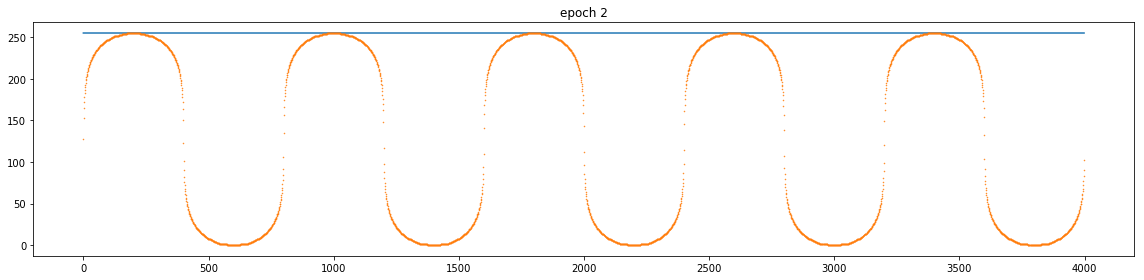

Batch 0 done
Batch 1 done
Batch 2 done
Batch 3 done
Batch 4 done
Batch 5 done
Batch 6 done
Batch 7 done
Batch 8 done
Batch 9 done
Batch 10 done
Batch 11 done
Batch 12 done
Batch 13 done
Batch 14 done
Batch 15 done
epoch 3, loss 4.81444644928


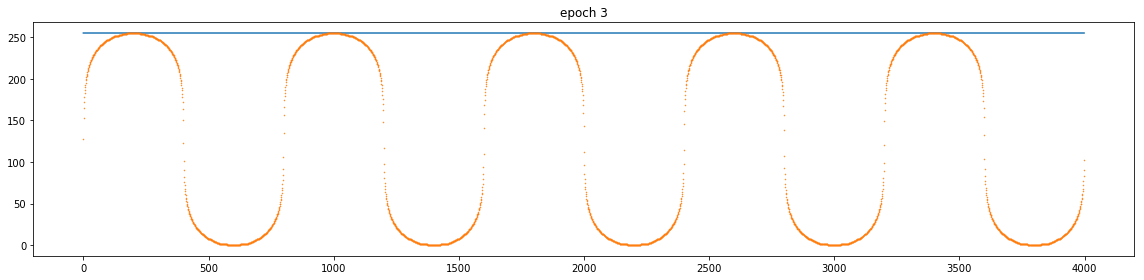

Batch 0 done
Batch 1 done
Batch 2 done
Batch 3 done
Batch 4 done
Batch 5 done
Batch 6 done
Batch 7 done
Batch 8 done
Batch 9 done
Batch 10 done
Batch 11 done
Batch 12 done
Batch 13 done
Batch 14 done
Batch 15 done
epoch 4, loss 4.66176843643


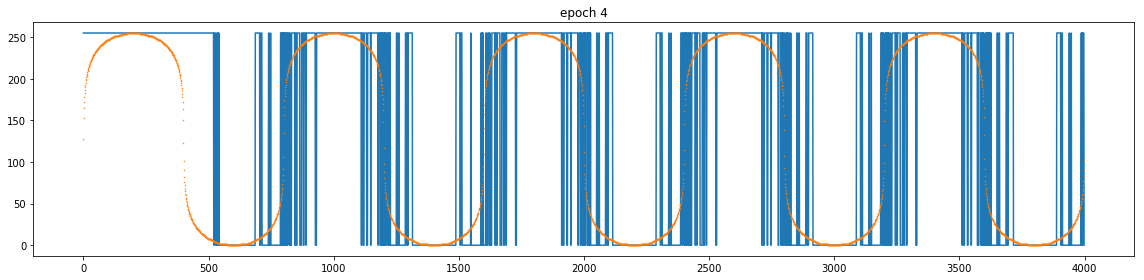

Batch 0 done
Batch 1 done
Batch 2 done
Batch 3 done
Batch 4 done
Batch 5 done
Batch 6 done
Batch 7 done
Batch 8 done
Batch 9 done
Batch 10 done
Batch 11 done
Batch 12 done
Batch 13 done
Batch 14 done
Batch 15 done
epoch 5, loss 4.49354553223


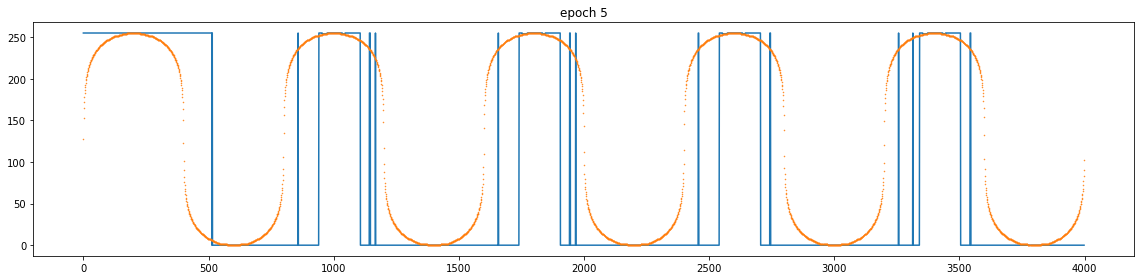

Batch 0 done
Batch 1 done
Batch 2 done
Batch 3 done
Batch 4 done
Batch 5 done
Batch 6 done
Batch 7 done
Batch 8 done
Batch 9 done
Batch 10 done
Batch 11 done
Batch 12 done
Batch 13 done
Batch 14 done
Batch 15 done
epoch 6, loss 4.35670900345


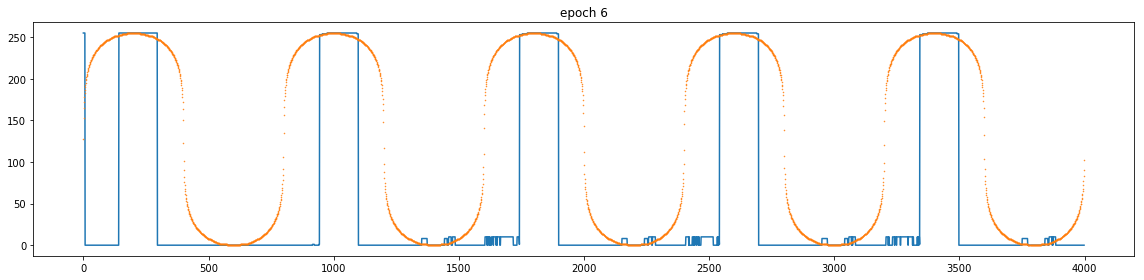

Batch 0 done
Batch 1 done
Batch 2 done
Batch 3 done
Batch 4 done
Batch 5 done
Batch 6 done
Batch 7 done
Batch 8 done
Batch 9 done
Batch 10 done
Batch 11 done
Batch 12 done
Batch 13 done
Batch 14 done
Batch 15 done
epoch 7, loss 4.60201358795


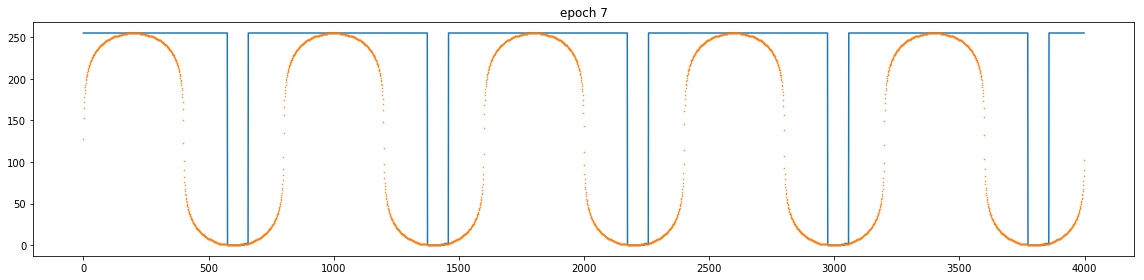

Batch 0 done
Batch 1 done
Batch 2 done
Batch 3 done
Batch 4 done
Batch 5 done
Batch 6 done
Batch 7 done
Batch 8 done
Batch 9 done
Batch 10 done
Batch 11 done
Batch 12 done
Batch 13 done
Batch 14 done
Batch 15 done
epoch 8, loss 4.50135469437


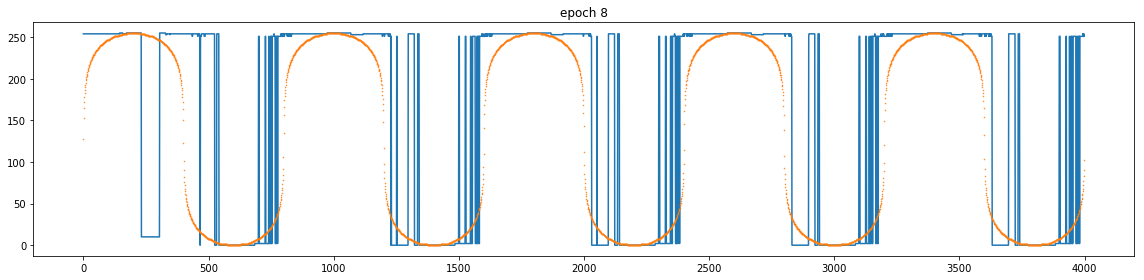

Batch 0 done
Batch 1 done
Batch 2 done
Batch 3 done
Batch 4 done
Batch 5 done
Batch 6 done
Batch 7 done
Batch 8 done
Batch 9 done
Batch 10 done
Batch 11 done
Batch 12 done
Batch 13 done
Batch 14 done
Batch 15 done
epoch 9, loss 4.27246809006


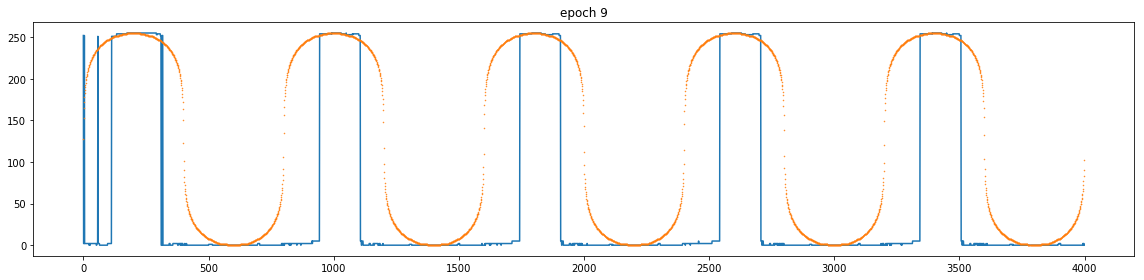

Batch 0 done
Batch 1 done
Batch 2 done
Batch 3 done
Batch 4 done
Batch 5 done
Batch 6 done
Batch 7 done
Batch 8 done
Batch 9 done
Batch 10 done
Batch 11 done
Batch 12 done
Batch 13 done
Batch 14 done
Batch 15 done
epoch 10, loss 4.09841108322


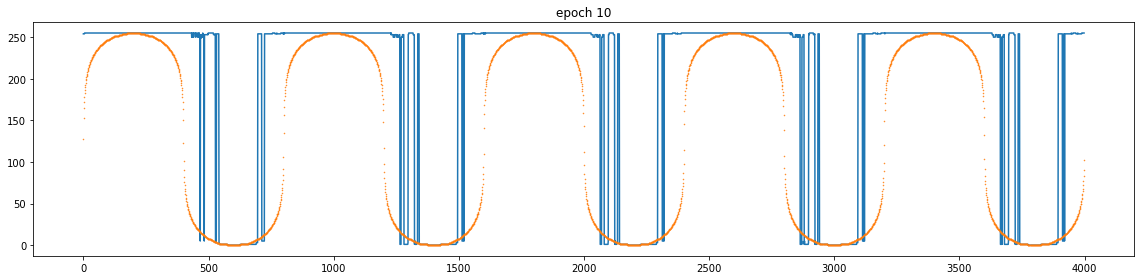

Batch 0 done
Batch 1 done
Batch 2 done
Batch 3 done
Batch 4 done
Batch 5 done
Batch 6 done
Batch 7 done
Batch 8 done
Batch 9 done
Batch 10 done
Batch 11 done
Batch 12 done
Batch 13 done
Batch 14 done
Batch 15 done
epoch 11, loss 4.0073633194


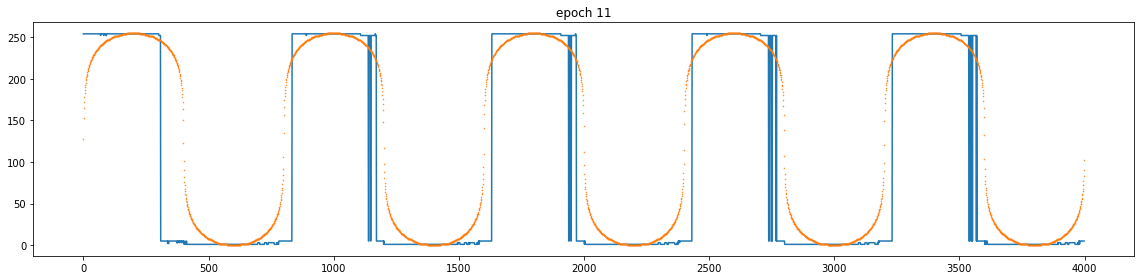

Batch 0 done
Batch 1 done
Batch 2 done
Batch 3 done
Batch 4 done
Batch 5 done
Batch 6 done
Batch 7 done
Batch 8 done
Batch 9 done
Batch 10 done
Batch 11 done
Batch 12 done
Batch 13 done
Batch 14 done
Batch 15 done
epoch 12, loss 3.67299580574


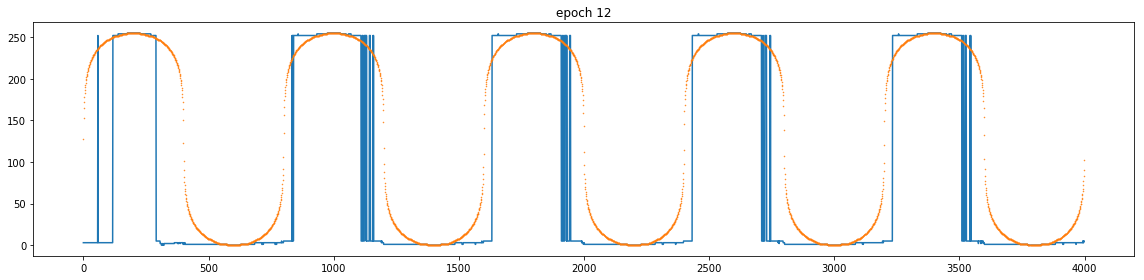

Batch 0 done
Batch 1 done
Batch 2 done
Batch 3 done
Batch 4 done
Batch 5 done
Batch 6 done
Batch 7 done
Batch 8 done
Batch 9 done
Batch 10 done
Batch 11 done
Batch 12 done
Batch 13 done
Batch 14 done
Batch 15 done
epoch 13, loss 3.52568340302


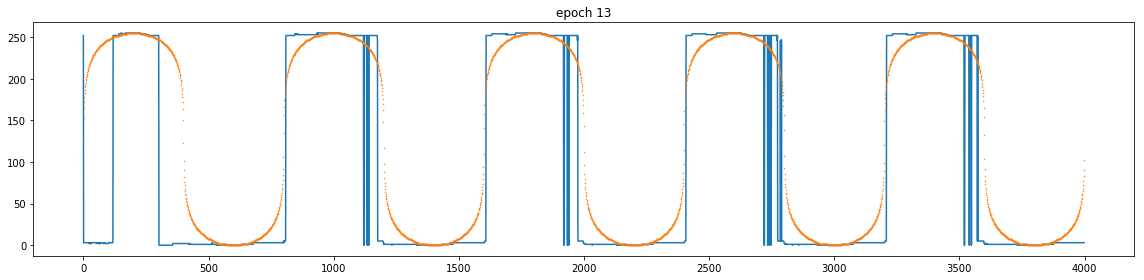

Batch 0 done
Batch 1 done
Batch 2 done
Batch 3 done
Batch 4 done
Batch 5 done
Batch 6 done
Batch 7 done
Batch 8 done
Batch 9 done
Batch 10 done
Batch 11 done
Batch 12 done
Batch 13 done
Batch 14 done
Batch 15 done
epoch 14, loss 3.38294315338


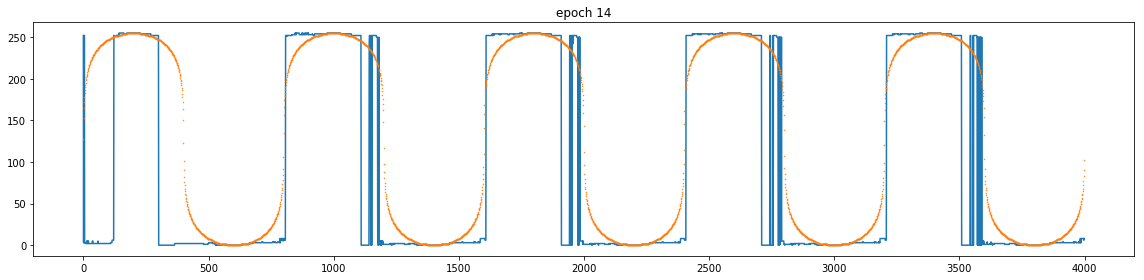

Batch 0 done
Batch 1 done
Batch 2 done
Batch 3 done
Batch 4 done
Batch 5 done
Batch 6 done
Batch 7 done
Batch 8 done
Batch 9 done
Batch 10 done
Batch 11 done
Batch 12 done
Batch 13 done
Batch 14 done
Batch 15 done
epoch 15, loss 3.26178336143


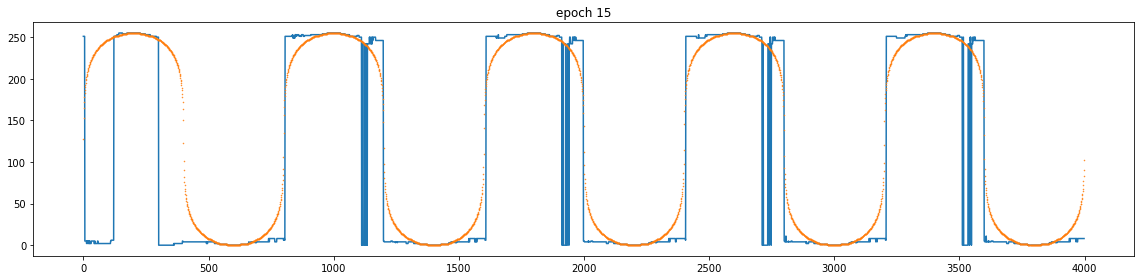

Batch 0 done
Batch 1 done
Batch 2 done
Batch 3 done
Batch 4 done
Batch 5 done
Batch 6 done
Batch 7 done
Batch 8 done
Batch 9 done
Batch 10 done
Batch 11 done
Batch 12 done
Batch 13 done
Batch 14 done
Batch 15 done
epoch 16, loss 3.06066179276


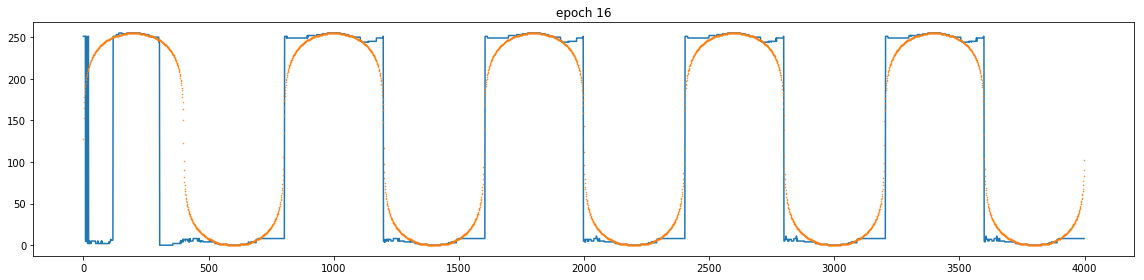

Batch 0 done
Batch 1 done
Batch 2 done
Batch 3 done
Batch 4 done
Batch 5 done
Batch 6 done
Batch 7 done
Batch 8 done
Batch 9 done
Batch 10 done
Batch 11 done
Batch 12 done
Batch 13 done
Batch 14 done
Batch 15 done
epoch 17, loss 2.92086052895


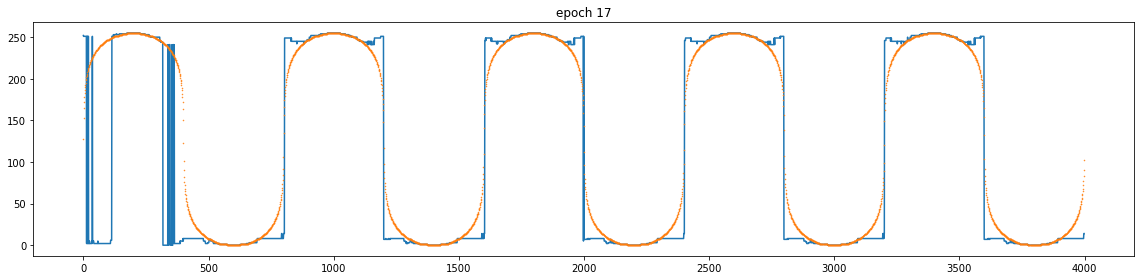

Batch 0 done
Batch 1 done
Batch 2 done
Batch 3 done
Batch 4 done
Batch 5 done
Batch 6 done
Batch 7 done
Batch 8 done
Batch 9 done
Batch 10 done
Batch 11 done
Batch 12 done
Batch 13 done
Batch 14 done
Batch 15 done
epoch 18, loss 2.7656288147


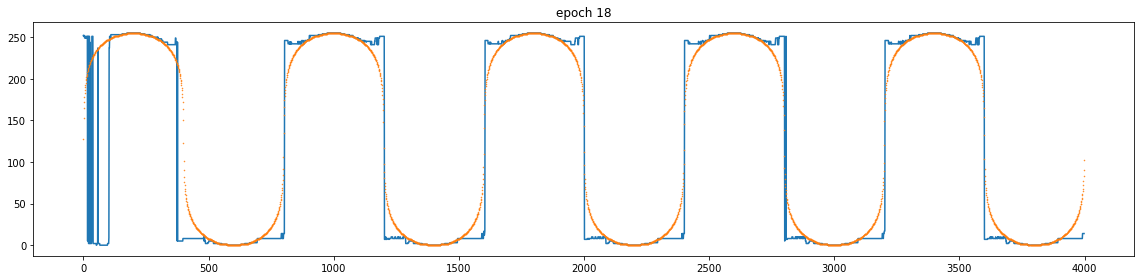

Batch 0 done
Batch 1 done
Batch 2 done
Batch 3 done
Batch 4 done
Batch 5 done
Batch 6 done
Batch 7 done
Batch 8 done
Batch 9 done
Batch 10 done
Batch 11 done
Batch 12 done
Batch 13 done
Batch 14 done
Batch 15 done
epoch 19, loss 2.64038705826


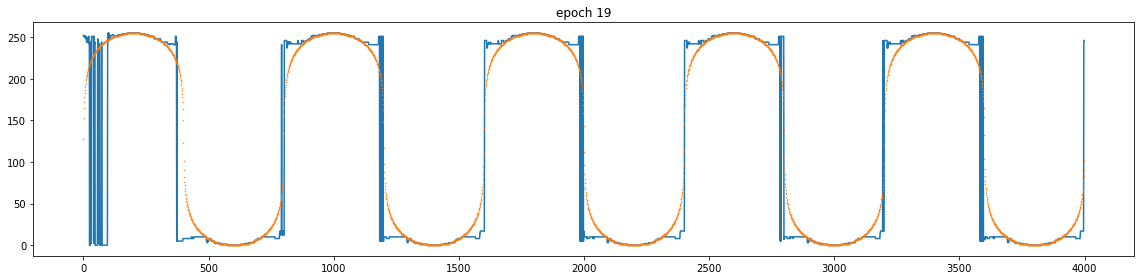

Batch 0 done
Batch 1 done
Batch 2 done
Batch 3 done
Batch 4 done
Batch 5 done
Batch 6 done
Batch 7 done
Batch 8 done
Batch 9 done
Batch 10 done
Batch 11 done
Batch 12 done
Batch 13 done
Batch 14 done
Batch 15 done
epoch 20, loss 2.5039036274


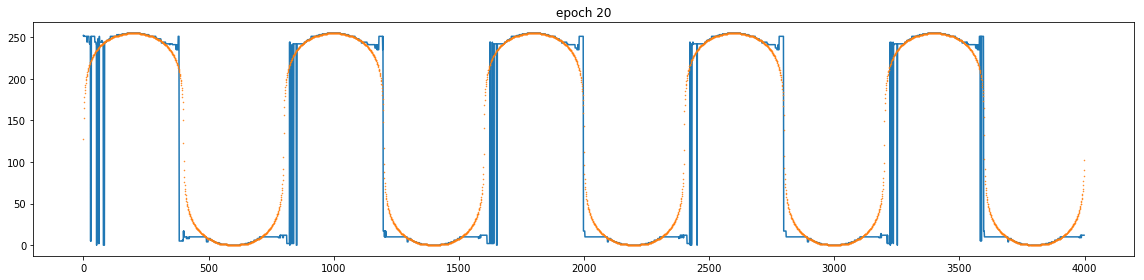

Batch 0 done
Batch 1 done
Batch 2 done
Batch 3 done
Batch 4 done
Batch 5 done
Batch 6 done
Batch 7 done
Batch 8 done
Batch 9 done
Batch 10 done
Batch 11 done
Batch 12 done
Batch 13 done
Batch 14 done
Batch 15 done
epoch 21, loss 2.38006448746


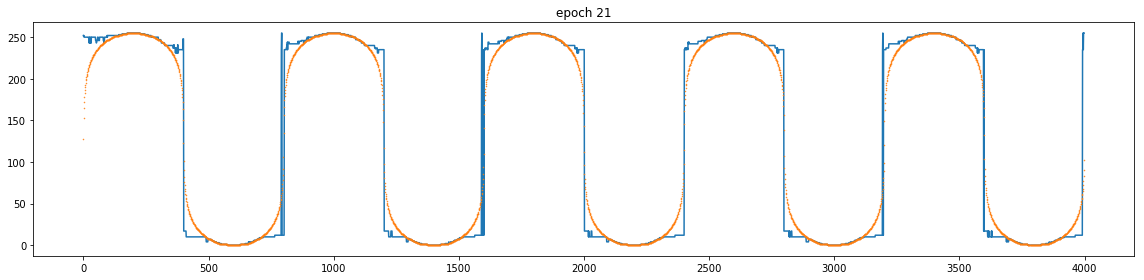

Batch 0 done
Batch 1 done
Batch 2 done
Batch 3 done
Batch 4 done
Batch 5 done
Batch 6 done
Batch 7 done
Batch 8 done
Batch 9 done
Batch 10 done
Batch 11 done
Batch 12 done
Batch 13 done
Batch 14 done
Batch 15 done
epoch 22, loss 2.32054114342


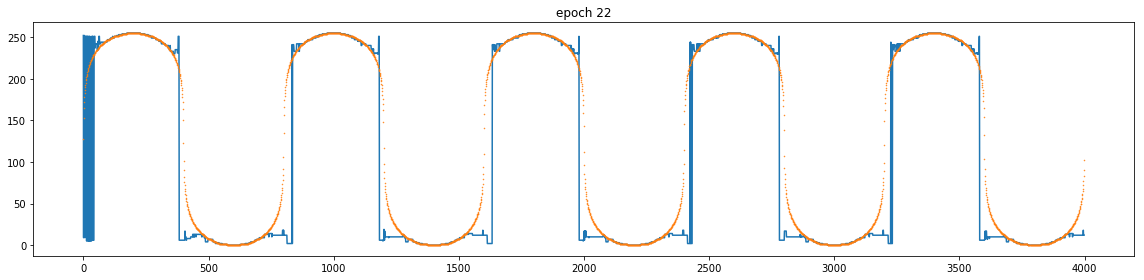

Batch 0 done
Batch 1 done
Batch 2 done
Batch 3 done
Batch 4 done
Batch 5 done
Batch 6 done
Batch 7 done
Batch 8 done
Batch 9 done
Batch 10 done
Batch 11 done
Batch 12 done
Batch 13 done
Batch 14 done
Batch 15 done
epoch 23, loss 2.31309008598


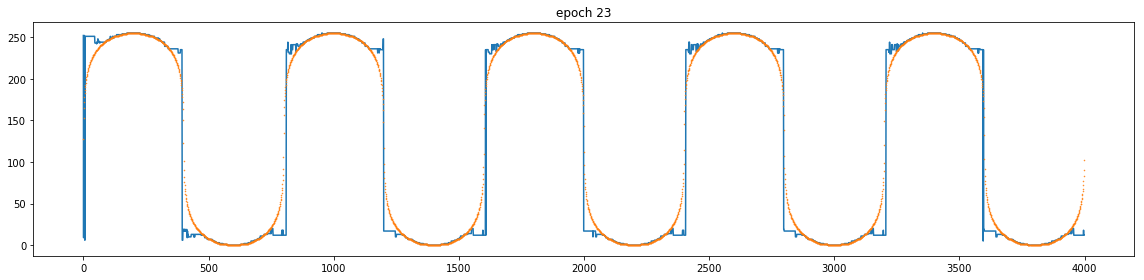

Batch 0 done
Batch 1 done
Batch 2 done
Batch 3 done
Batch 4 done
Batch 5 done
Batch 6 done
Batch 7 done
Batch 8 done
Batch 9 done
Batch 10 done
Batch 11 done
Batch 12 done
Batch 13 done
Batch 14 done
Batch 15 done
epoch 24, loss 2.1317820549


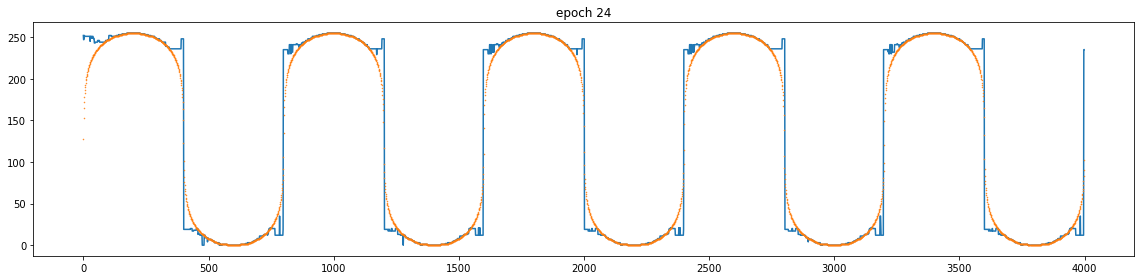

Batch 0 done
Batch 1 done
Batch 2 done
Batch 3 done
Batch 4 done
Batch 5 done
Batch 6 done
Batch 7 done
Batch 8 done
Batch 9 done
Batch 10 done
Batch 11 done
Batch 12 done
Batch 13 done
Batch 14 done
Batch 15 done
epoch 25, loss 2.02582120895


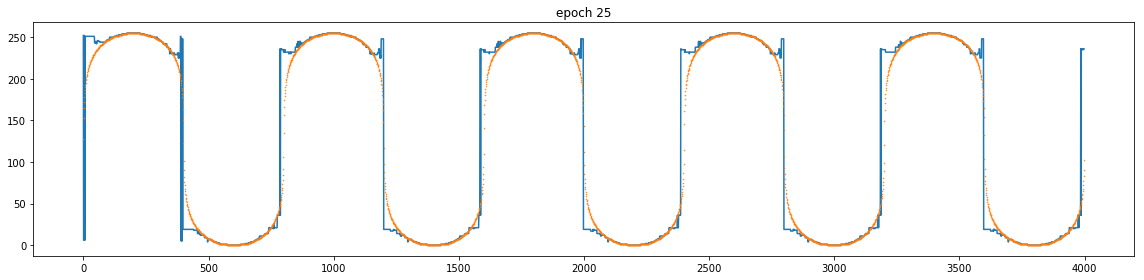

Batch 0 done
Batch 1 done
Batch 2 done
Batch 3 done
Batch 4 done
Batch 5 done
Batch 6 done
Batch 7 done
Batch 8 done
Batch 9 done
Batch 10 done
Batch 11 done
Batch 12 done
Batch 13 done
Batch 14 done
Batch 15 done
epoch 26, loss 1.93841159344


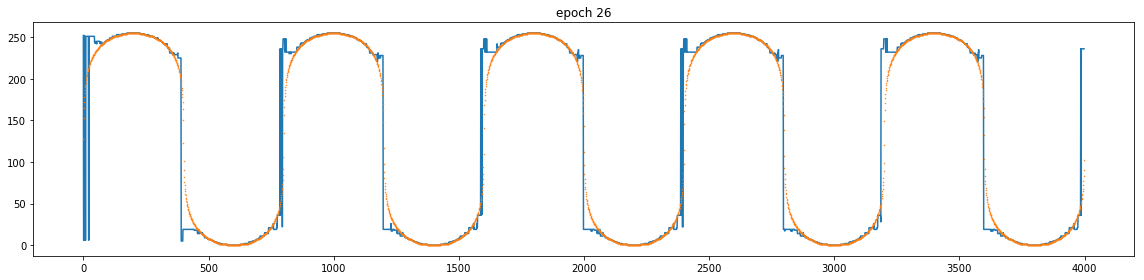

Batch 0 done
Batch 1 done
Batch 2 done
Batch 3 done
Batch 4 done
Batch 5 done
Batch 6 done
Batch 7 done
Batch 8 done
Batch 9 done
Batch 10 done
Batch 11 done
Batch 12 done
Batch 13 done
Batch 14 done
Batch 15 done
epoch 27, loss 1.83769404888


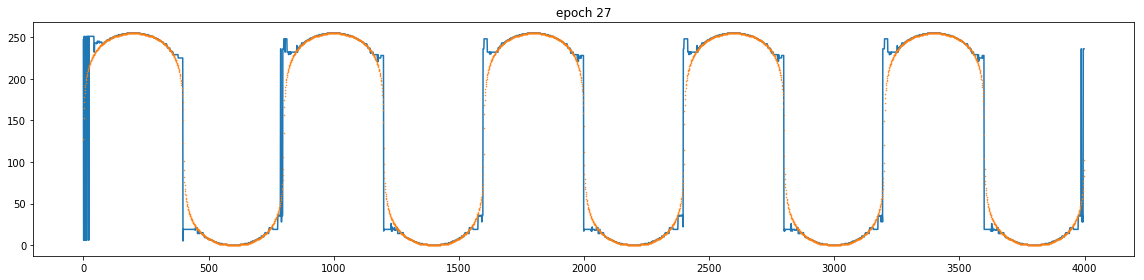

Batch 0 done
Batch 1 done
Batch 2 done
Batch 3 done
Batch 4 done
Batch 5 done
Batch 6 done
Batch 7 done
Batch 8 done
Batch 9 done
Batch 10 done
Batch 11 done
Batch 12 done
Batch 13 done
Batch 14 done
Batch 15 done
epoch 28, loss 1.72091114521


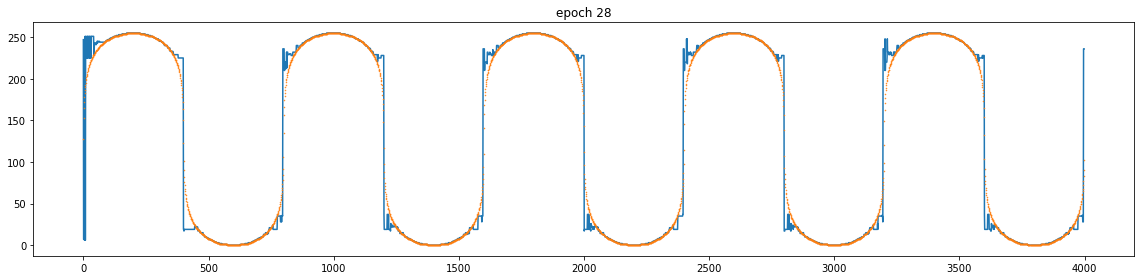

Batch 0 done
Batch 1 done
Batch 2 done
Batch 3 done
Batch 4 done
Batch 5 done
Batch 6 done
Batch 7 done
Batch 8 done
Batch 9 done
Batch 10 done
Batch 11 done
Batch 12 done
Batch 13 done
Batch 14 done
Batch 15 done
epoch 29, loss 1.65651249886


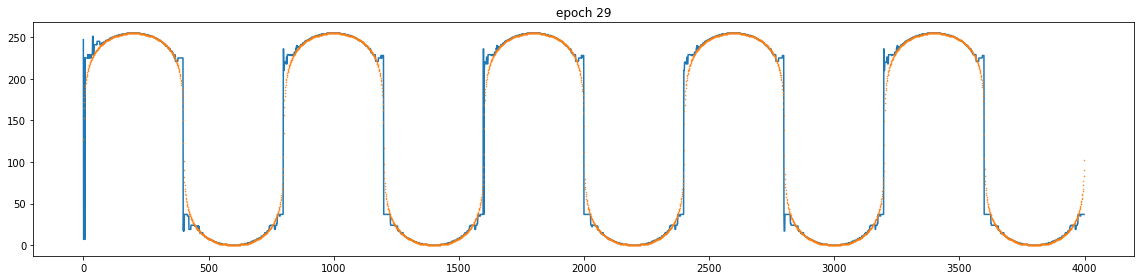

Batch 0 done
Batch 1 done
Batch 2 done
Batch 3 done
Batch 4 done
Batch 5 done
Batch 6 done
Batch 7 done
Batch 8 done
Batch 9 done
Batch 10 done
Batch 11 done
Batch 12 done
Batch 13 done
Batch 14 done
Batch 15 done
epoch 30, loss 1.5523788929


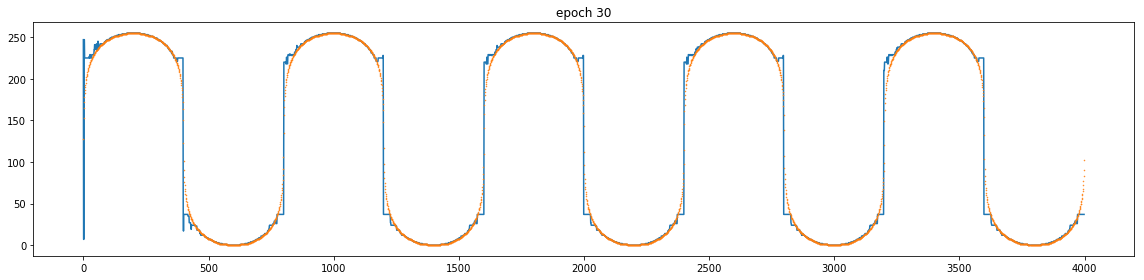

Batch 0 done
Batch 1 done
Batch 2 done
Batch 3 done
Batch 4 done
Batch 5 done
Batch 6 done
Batch 7 done
Batch 8 done
Batch 9 done
Batch 10 done
Batch 11 done
Batch 12 done
Batch 13 done
Batch 14 done
Batch 15 done
epoch 31, loss 1.45854556561


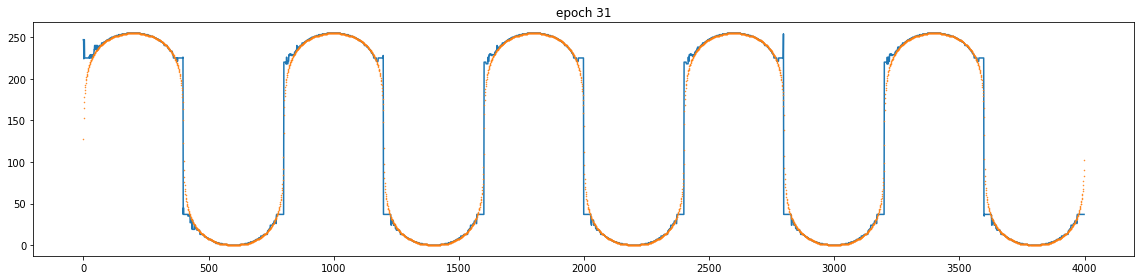

Batch 0 done
Batch 1 done
Batch 2 done
Batch 3 done
Batch 4 done
Batch 5 done
Batch 6 done
Batch 7 done
Batch 8 done
Batch 9 done
Batch 10 done
Batch 11 done
Batch 12 done
Batch 13 done
Batch 14 done
Batch 15 done
epoch 32, loss 1.39067018032


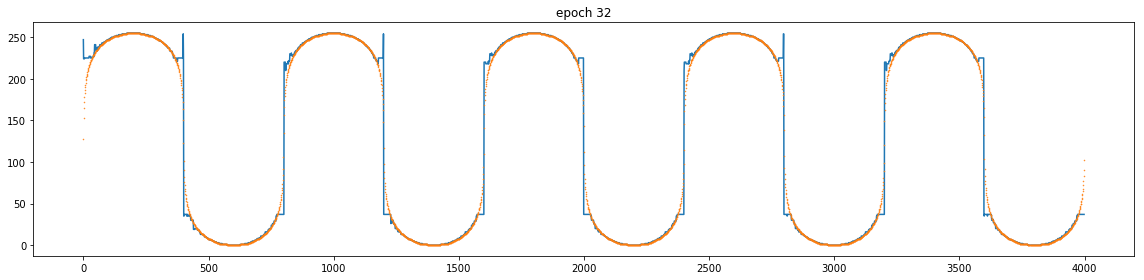

Batch 0 done
Batch 1 done
Batch 2 done
Batch 3 done
Batch 4 done
Batch 5 done
Batch 6 done
Batch 7 done
Batch 8 done
Batch 9 done
Batch 10 done
Batch 11 done
Batch 12 done
Batch 13 done
Batch 14 done
Batch 15 done
epoch 33, loss 1.30893445015


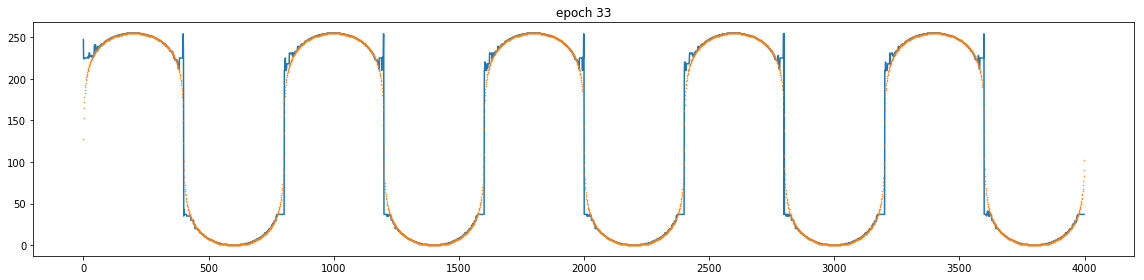

Batch 0 done
Batch 1 done
Batch 2 done
Batch 3 done
Batch 4 done
Batch 5 done
Batch 6 done
Batch 7 done
Batch 8 done
Batch 9 done
Batch 10 done
Batch 11 done
Batch 12 done
Batch 13 done
Batch 14 done
Batch 15 done
epoch 34, loss 1.23704457283


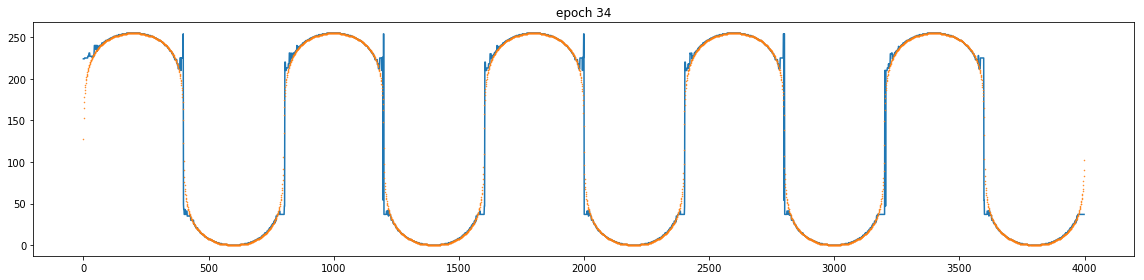

Batch 0 done
Batch 1 done
Batch 2 done
Batch 3 done
Batch 4 done
Batch 5 done
Batch 6 done
Batch 7 done
Batch 8 done
Batch 9 done
Batch 10 done
Batch 11 done
Batch 12 done
Batch 13 done
Batch 14 done
Batch 15 done
epoch 35, loss 1.16278243065


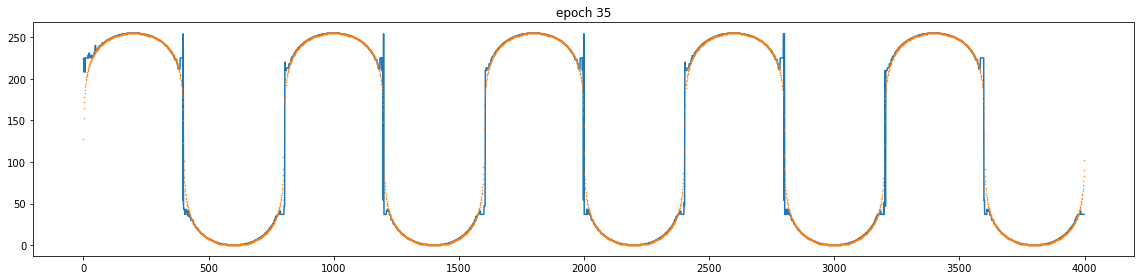

Batch 0 done
Batch 1 done
Batch 2 done
Batch 3 done
Batch 4 done
Batch 5 done
Batch 6 done
Batch 7 done
Batch 8 done
Batch 9 done
Batch 10 done
Batch 11 done
Batch 12 done
Batch 13 done
Batch 14 done
Batch 15 done
epoch 36, loss 1.09220409393


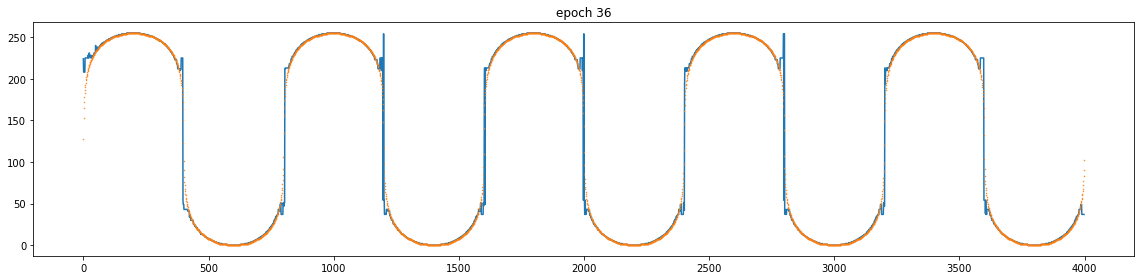

Batch 0 done
Batch 1 done
Batch 2 done
Batch 3 done
Batch 4 done
Batch 5 done
Batch 6 done
Batch 7 done
Batch 8 done
Batch 9 done
Batch 10 done
Batch 11 done
Batch 12 done
Batch 13 done
Batch 14 done
Batch 15 done
epoch 37, loss 1.03376758099


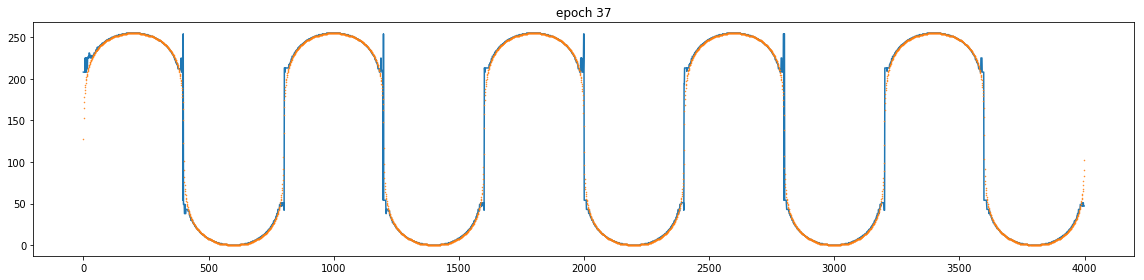

Batch 0 done
Batch 1 done
Batch 2 done
Batch 3 done
Batch 4 done
Batch 5 done
Batch 6 done
Batch 7 done
Batch 8 done
Batch 9 done
Batch 10 done
Batch 11 done
Batch 12 done
Batch 13 done
Batch 14 done
Batch 15 done
epoch 38, loss 0.967298567295


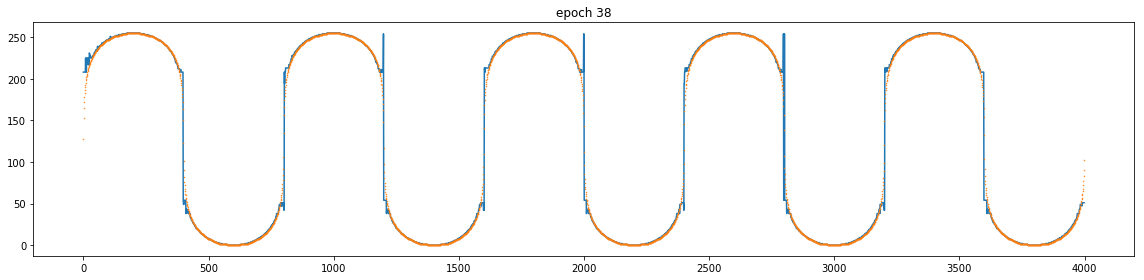

Batch 0 done
Batch 1 done
Batch 2 done
Batch 3 done
Batch 4 done
Batch 5 done
Batch 6 done
Batch 7 done
Batch 8 done
Batch 9 done
Batch 10 done
Batch 11 done
Batch 12 done
Batch 13 done
Batch 14 done
Batch 15 done
epoch 39, loss 0.909564077854


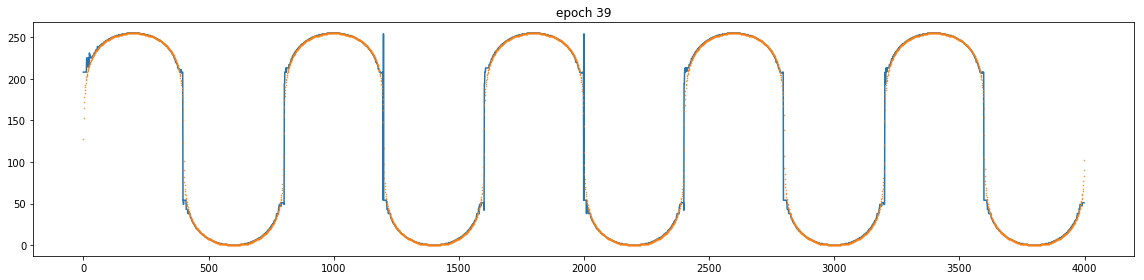

Batch 0 done
Batch 1 done
Batch 2 done
Batch 3 done
Batch 4 done
Batch 5 done
Batch 6 done
Batch 7 done
Batch 8 done
Batch 9 done
Batch 10 done
Batch 11 done
Batch 12 done
Batch 13 done
Batch 14 done
Batch 15 done
epoch 40, loss 0.853899717331


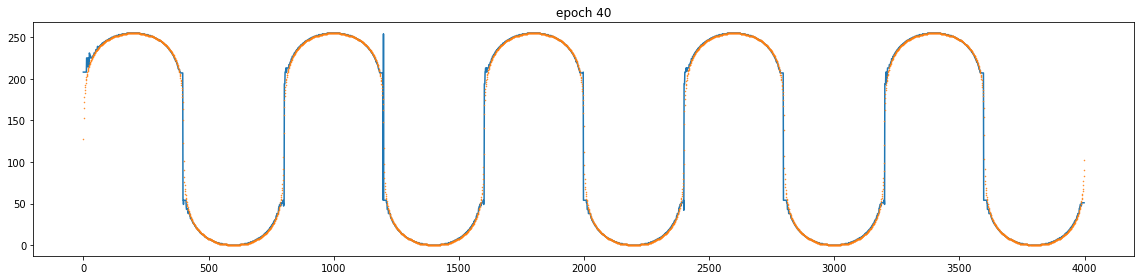

Batch 0 done
Batch 1 done
Batch 2 done
Batch 3 done
Batch 4 done
Batch 5 done
Batch 6 done
Batch 7 done
Batch 8 done
Batch 9 done
Batch 10 done
Batch 11 done
Batch 12 done
Batch 13 done
Batch 14 done
Batch 15 done
epoch 41, loss 0.804602563381


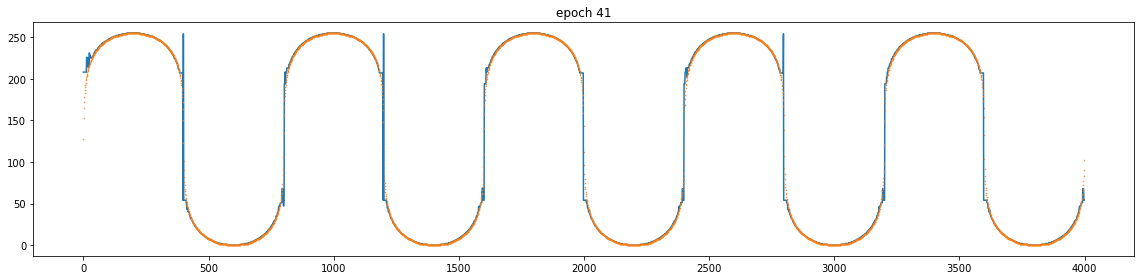

Batch 0 done
Batch 1 done
Batch 2 done
Batch 3 done
Batch 4 done
Batch 5 done
Batch 6 done
Batch 7 done
Batch 8 done
Batch 9 done
Batch 10 done
Batch 11 done
Batch 12 done
Batch 13 done
Batch 14 done
Batch 15 done
epoch 42, loss 0.760671913624


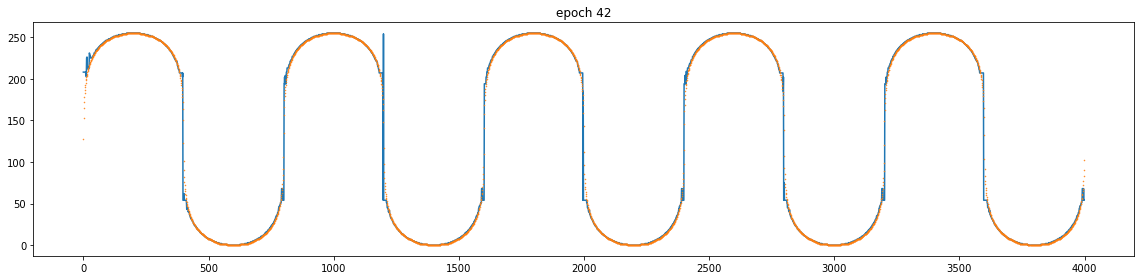

Batch 0 done
Batch 1 done
Batch 2 done
Batch 3 done
Batch 4 done
Batch 5 done
Batch 6 done
Batch 7 done
Batch 8 done
Batch 9 done
Batch 10 done
Batch 11 done
Batch 12 done
Batch 13 done
Batch 14 done
Batch 15 done
epoch 43, loss 0.737523913383


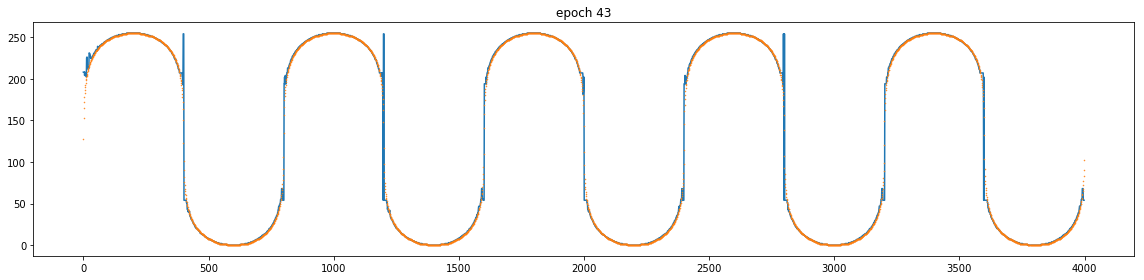

Batch 0 done
Batch 1 done
Batch 2 done
Batch 3 done
Batch 4 done
Batch 5 done
Batch 6 done
Batch 7 done
Batch 8 done
Batch 9 done
Batch 10 done
Batch 11 done
Batch 12 done
Batch 13 done
Batch 14 done
Batch 15 done
epoch 44, loss 0.732539832592


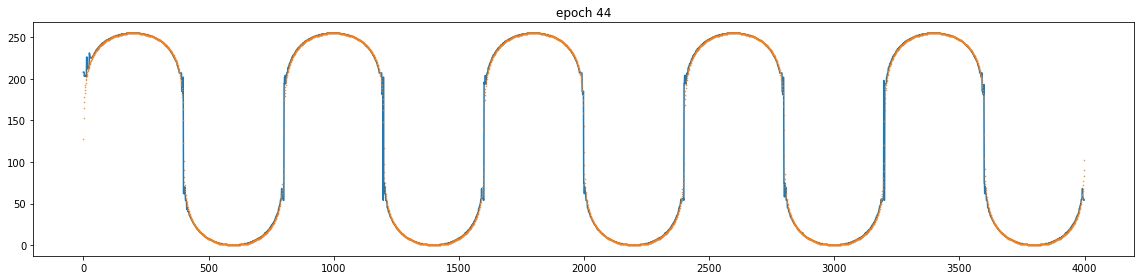

Batch 0 done
Batch 1 done
Batch 2 done
Batch 3 done
Batch 4 done
Batch 5 done
Batch 6 done
Batch 7 done
Batch 8 done
Batch 9 done
Batch 10 done
Batch 11 done
Batch 12 done
Batch 13 done
Batch 14 done
Batch 15 done
epoch 45, loss 0.693607389927


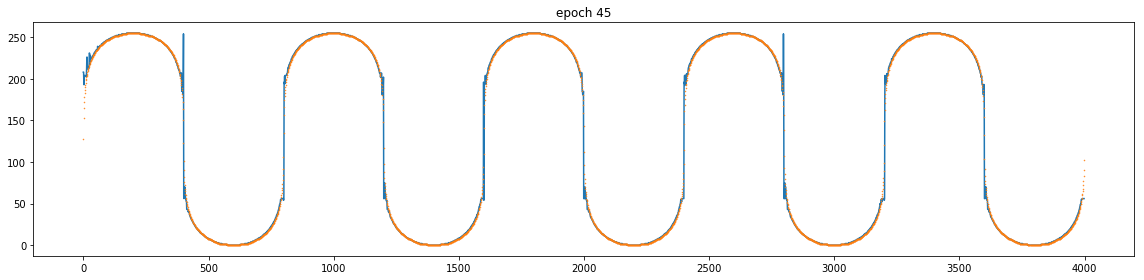

Batch 0 done
Batch 1 done
Batch 2 done
Batch 3 done
Batch 4 done
Batch 5 done
Batch 6 done
Batch 7 done
Batch 8 done
Batch 9 done
Batch 10 done
Batch 11 done
Batch 12 done
Batch 13 done
Batch 14 done
Batch 15 done
epoch 46, loss 0.60012447834


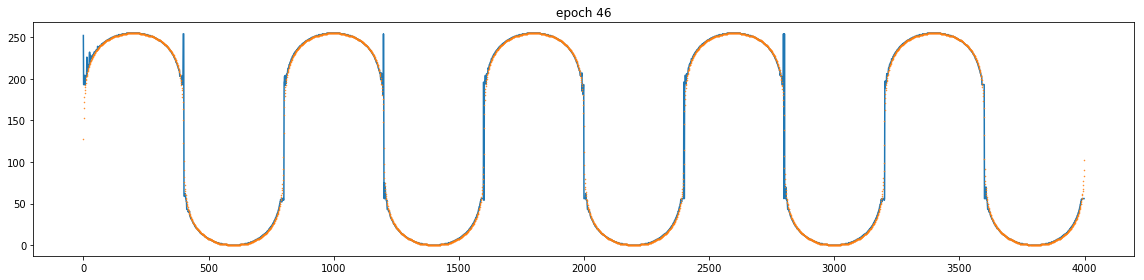

Batch 0 done
Batch 1 done
Batch 2 done
Batch 3 done
Batch 4 done
Batch 5 done
Batch 6 done
Batch 7 done
Batch 8 done
Batch 9 done
Batch 10 done
Batch 11 done
Batch 12 done
Batch 13 done
Batch 14 done
Batch 15 done
epoch 47, loss 0.59927713871


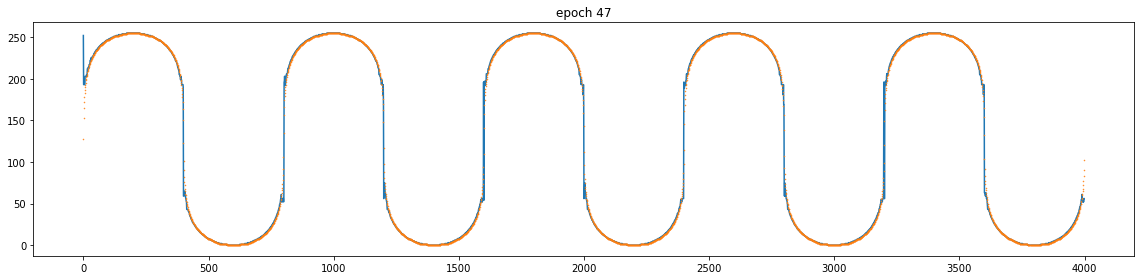

Batch 0 done
Batch 1 done
Batch 2 done
Batch 3 done
Batch 4 done
Batch 5 done
Batch 6 done
Batch 7 done
Batch 8 done
Batch 9 done
Batch 10 done
Batch 11 done
Batch 12 done
Batch 13 done
Batch 14 done
Batch 15 done
epoch 48, loss 0.548727571964


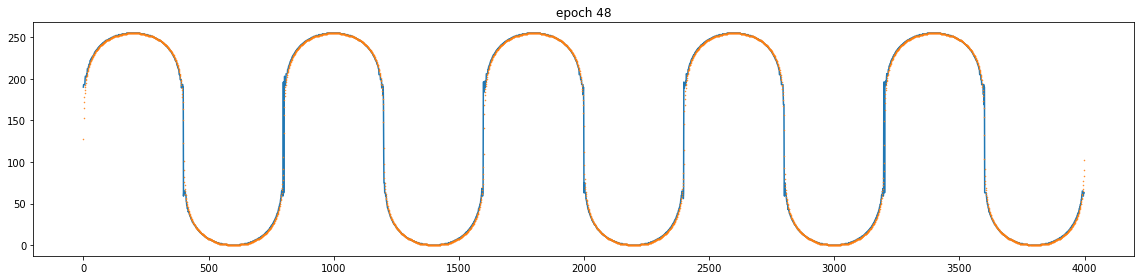

Batch 0 done
Batch 1 done
Batch 2 done
Batch 3 done
Batch 4 done
Batch 5 done
Batch 6 done
Batch 7 done
Batch 8 done
Batch 9 done
Batch 10 done
Batch 11 done
Batch 12 done
Batch 13 done
Batch 14 done
Batch 15 done
epoch 49, loss 0.522924304008


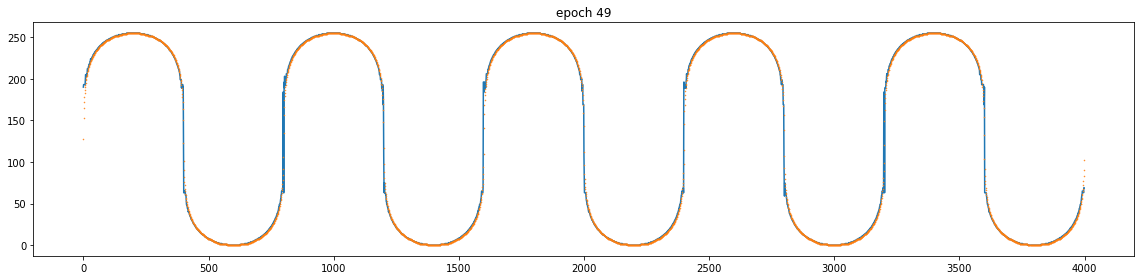

Batch 0 done
Batch 1 done
Batch 2 done
Batch 3 done
Batch 4 done
Batch 5 done
Batch 6 done
Batch 7 done
Batch 8 done
Batch 9 done
Batch 10 done
Batch 11 done
Batch 12 done
Batch 13 done
Batch 14 done
Batch 15 done
epoch 50, loss 0.485099196434


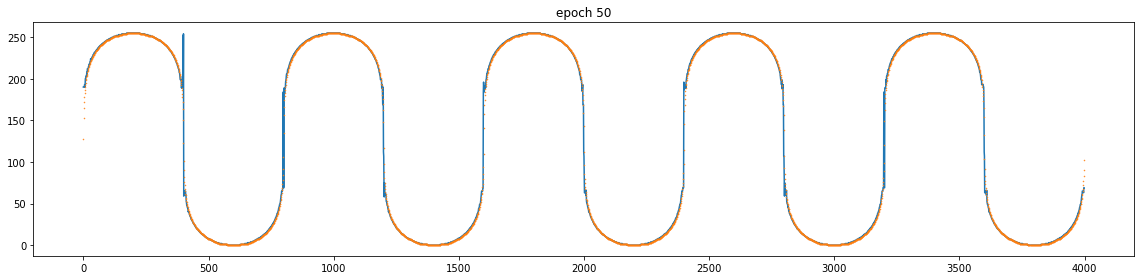

Batch 0 done
Batch 1 done
Batch 2 done
Batch 3 done
Batch 4 done
Batch 5 done
Batch 6 done
Batch 7 done
Batch 8 done
Batch 9 done
Batch 10 done
Batch 11 done
Batch 12 done
Batch 13 done
Batch 14 done
Batch 15 done
epoch 51, loss 0.46557328105


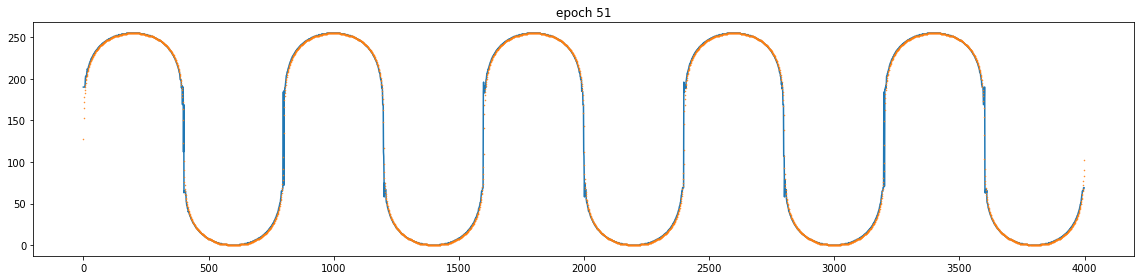

Batch 0 done
Batch 1 done
Batch 2 done
Batch 3 done
Batch 4 done
Batch 5 done
Batch 6 done
Batch 7 done
Batch 8 done
Batch 9 done
Batch 10 done
Batch 11 done
Batch 12 done
Batch 13 done
Batch 14 done
Batch 15 done
epoch 52, loss 0.427847981453


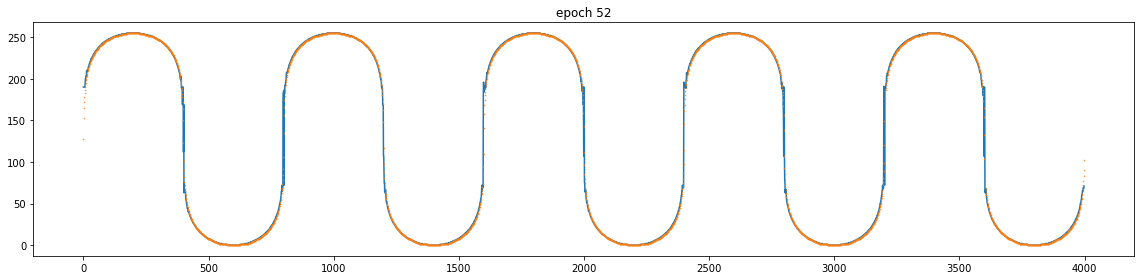

Batch 0 done
Batch 1 done
Batch 2 done
Batch 3 done
Batch 4 done
Batch 5 done
Batch 6 done
Batch 7 done
Batch 8 done
Batch 9 done
Batch 10 done
Batch 11 done
Batch 12 done
Batch 13 done
Batch 14 done
Batch 15 done
epoch 53, loss 0.406082123518


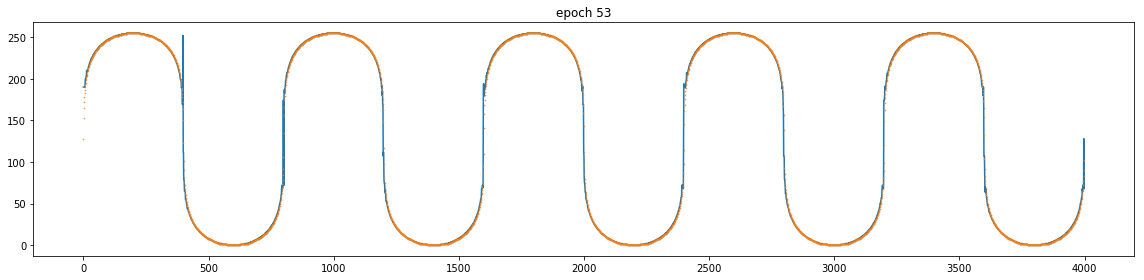

Batch 0 done
Batch 1 done
Batch 2 done
Batch 3 done
Batch 4 done
Batch 5 done
Batch 6 done
Batch 7 done
Batch 8 done
Batch 9 done
Batch 10 done
Batch 11 done
Batch 12 done
Batch 13 done
Batch 14 done
Batch 15 done
epoch 54, loss 0.379423290491


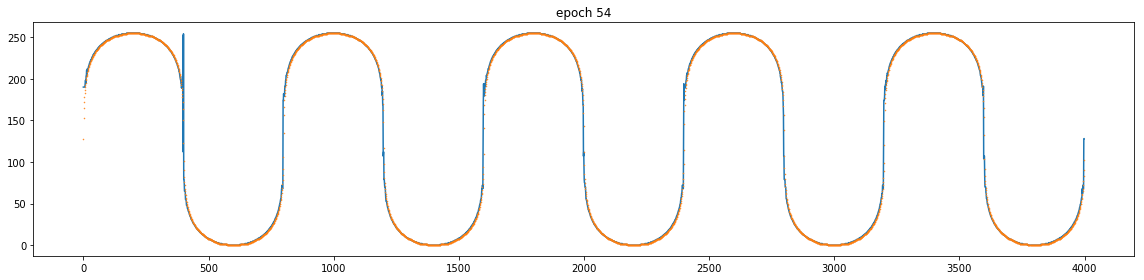

Batch 0 done
Batch 1 done
Batch 2 done
Batch 3 done
Batch 4 done
Batch 5 done
Batch 6 done
Batch 7 done
Batch 8 done
Batch 9 done
Batch 10 done
Batch 11 done
Batch 12 done
Batch 13 done
Batch 14 done
Batch 15 done
epoch 55, loss 0.355220764875


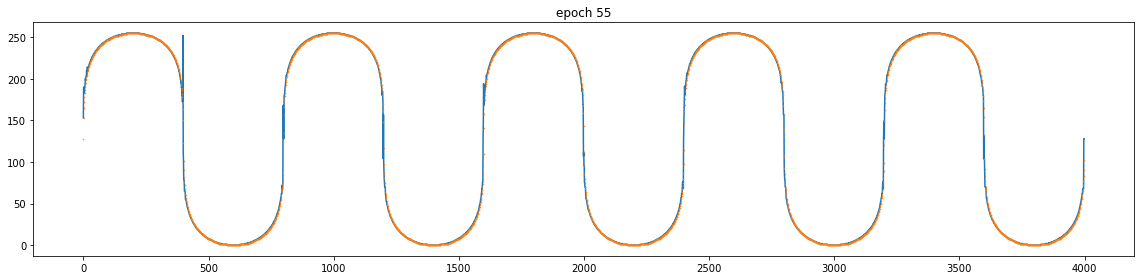

Batch 0 done
Batch 1 done
Batch 2 done
Batch 3 done
Batch 4 done
Batch 5 done
Batch 6 done
Batch 7 done
Batch 8 done
Batch 9 done
Batch 10 done
Batch 11 done
Batch 12 done
Batch 13 done
Batch 14 done
Batch 15 done
epoch 56, loss 0.331795722246


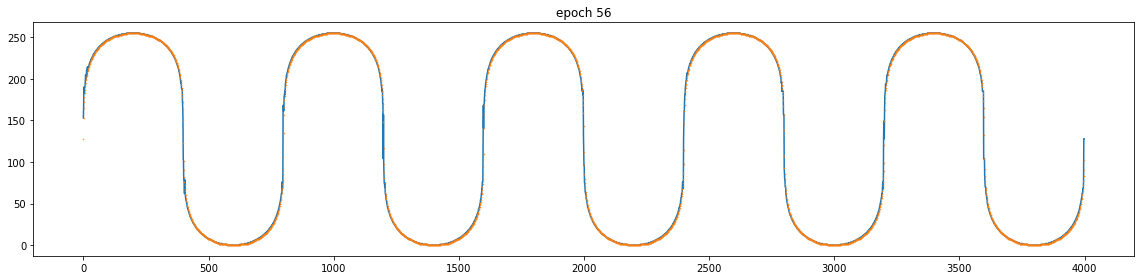

Batch 0 done
Batch 1 done
Batch 2 done
Batch 3 done
Batch 4 done
Batch 5 done
Batch 6 done
Batch 7 done
Batch 8 done
Batch 9 done
Batch 10 done
Batch 11 done
Batch 12 done
Batch 13 done
Batch 14 done
Batch 15 done
epoch 57, loss 0.309850156307


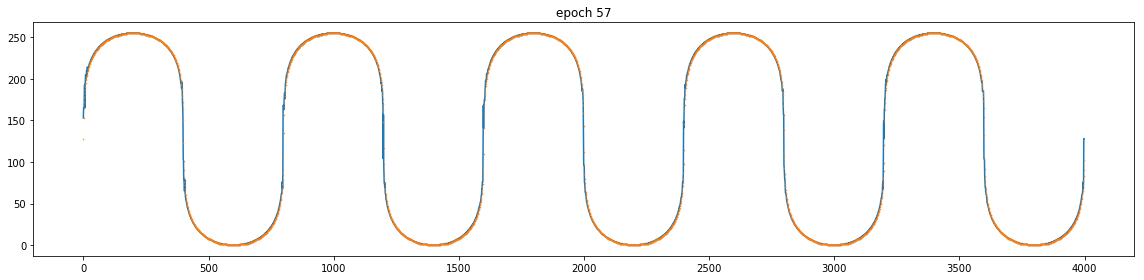

Batch 0 done
Batch 1 done
Batch 2 done
Batch 3 done
Batch 4 done
Batch 5 done
Batch 6 done
Batch 7 done
Batch 8 done
Batch 9 done
Batch 10 done
Batch 11 done
Batch 12 done
Batch 13 done
Batch 14 done
Batch 15 done
epoch 58, loss 0.288617163897


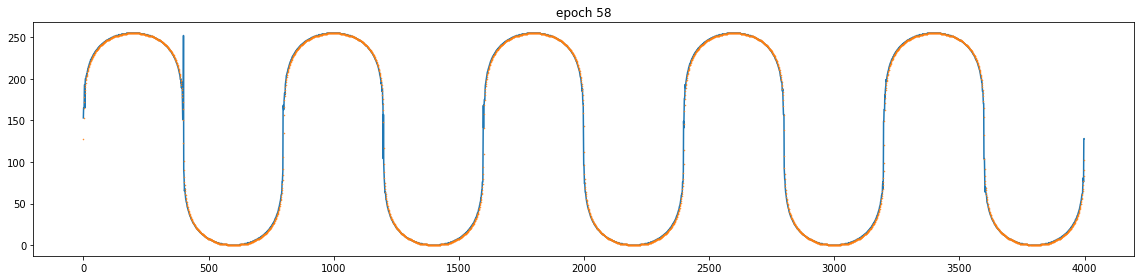

Batch 0 done
Batch 1 done
Batch 2 done
Batch 3 done
Batch 4 done
Batch 5 done
Batch 6 done
Batch 7 done
Batch 8 done
Batch 9 done
Batch 10 done
Batch 11 done
Batch 12 done
Batch 13 done
Batch 14 done
Batch 15 done
epoch 59, loss 0.26856020093


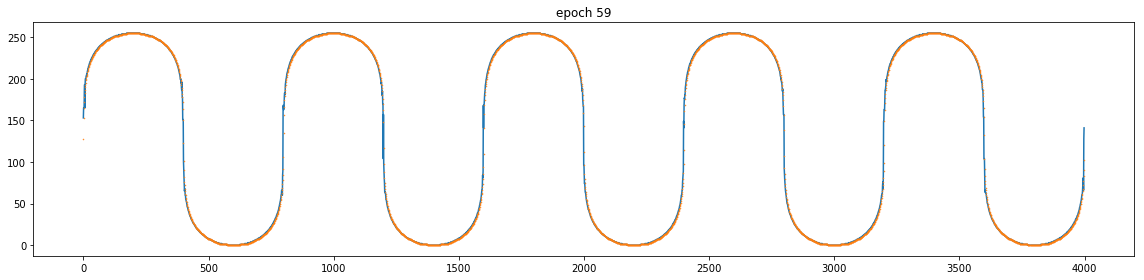

Batch 0 done
Batch 1 done
Batch 2 done
Batch 3 done
Batch 4 done
Batch 5 done
Batch 6 done
Batch 7 done
Batch 8 done
Batch 9 done
Batch 10 done
Batch 11 done
Batch 12 done
Batch 13 done
Batch 14 done
Batch 15 done
epoch 60, loss 0.249370038509


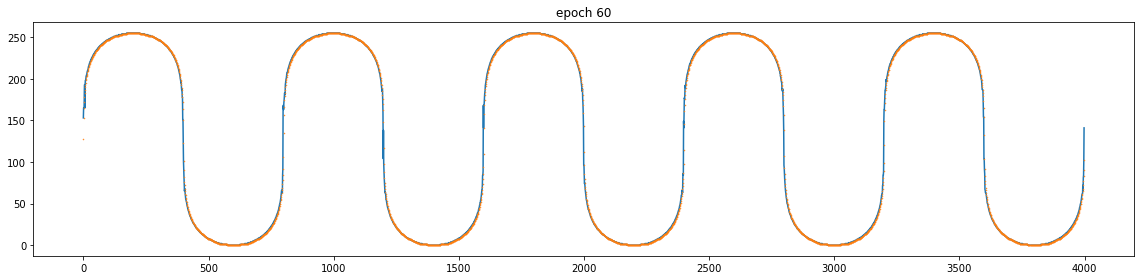

Batch 0 done
Batch 1 done
Batch 2 done
Batch 3 done
Batch 4 done
Batch 5 done
Batch 6 done
Batch 7 done
Batch 8 done
Batch 9 done
Batch 10 done
Batch 11 done
Batch 12 done
Batch 13 done
Batch 14 done
Batch 15 done
epoch 61, loss 0.231820598245


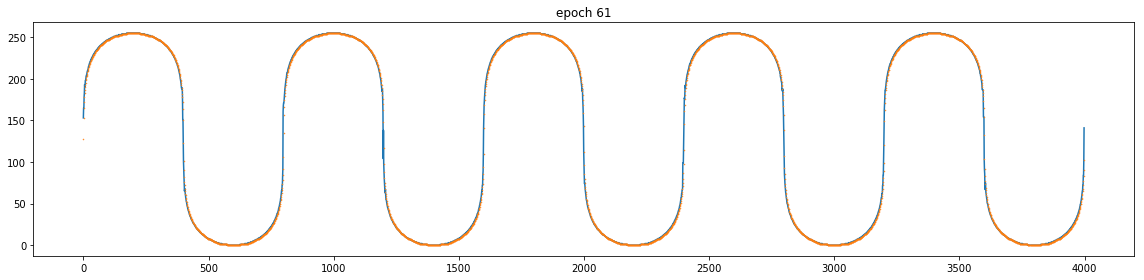

Batch 0 done
Batch 1 done
Batch 2 done
Batch 3 done
Batch 4 done
Batch 5 done
Batch 6 done
Batch 7 done
Batch 8 done
Batch 9 done
Batch 10 done
Batch 11 done
Batch 12 done
Batch 13 done
Batch 14 done
Batch 15 done
epoch 62, loss 0.214752689004


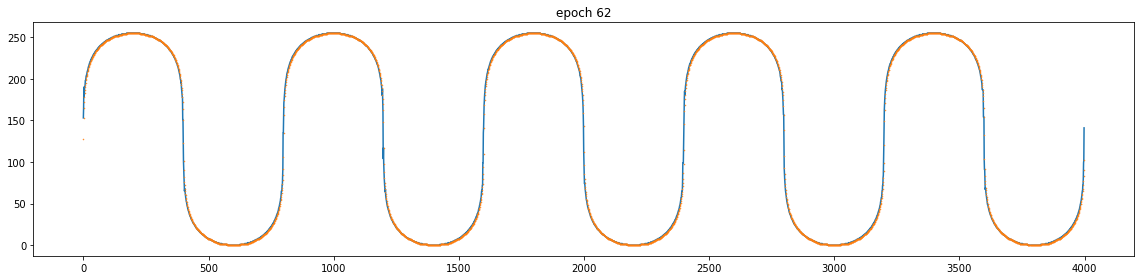

Batch 0 done
Batch 1 done
Batch 2 done
Batch 3 done
Batch 4 done
Batch 5 done
Batch 6 done
Batch 7 done
Batch 8 done
Batch 9 done
Batch 10 done
Batch 11 done
Batch 12 done
Batch 13 done
Batch 14 done
Batch 15 done
epoch 63, loss 0.19809396565


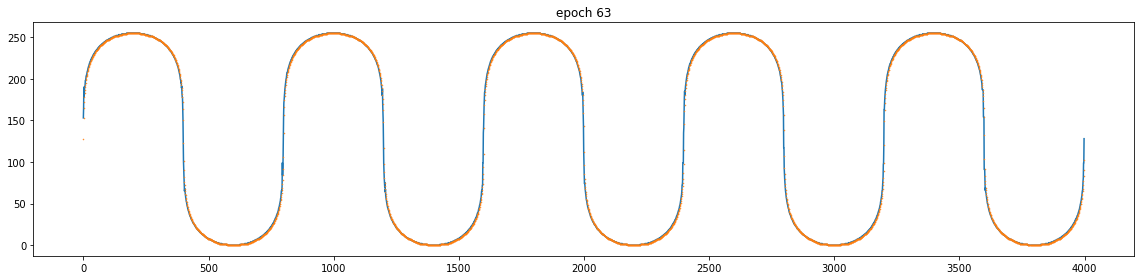

Batch 0 done
Batch 1 done
Batch 2 done
Batch 3 done
Batch 4 done
Batch 5 done
Batch 6 done
Batch 7 done
Batch 8 done
Batch 9 done
Batch 10 done
Batch 11 done
Batch 12 done
Batch 13 done
Batch 14 done
Batch 15 done
epoch 64, loss 0.183394253254


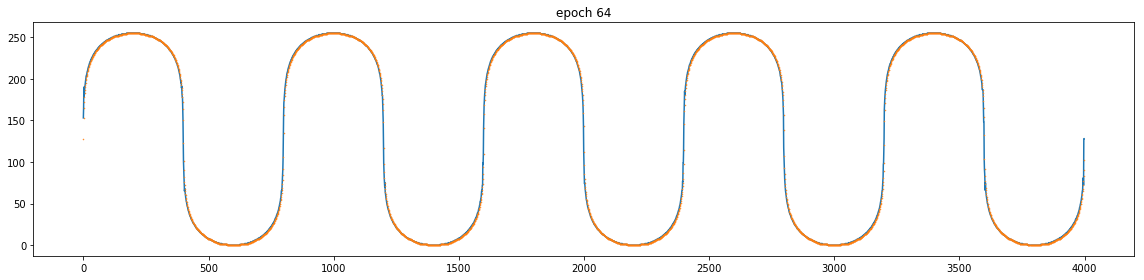

Batch 0 done
Batch 1 done
Batch 2 done
Batch 3 done
Batch 4 done
Batch 5 done
Batch 6 done
Batch 7 done
Batch 8 done
Batch 9 done
Batch 10 done
Batch 11 done
Batch 12 done
Batch 13 done
Batch 14 done
Batch 15 done
epoch 65, loss 0.169518008828


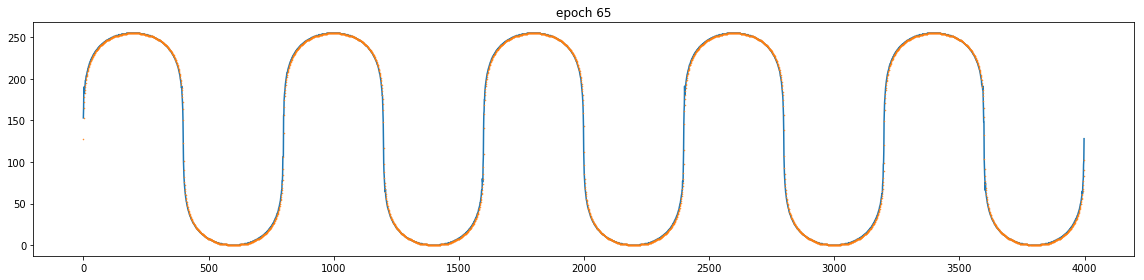

Batch 0 done
Batch 1 done
Batch 2 done
Batch 3 done
Batch 4 done
Batch 5 done
Batch 6 done
Batch 7 done
Batch 8 done
Batch 9 done
Batch 10 done
Batch 11 done
Batch 12 done
Batch 13 done
Batch 14 done
Batch 15 done
epoch 66, loss 0.158401712775


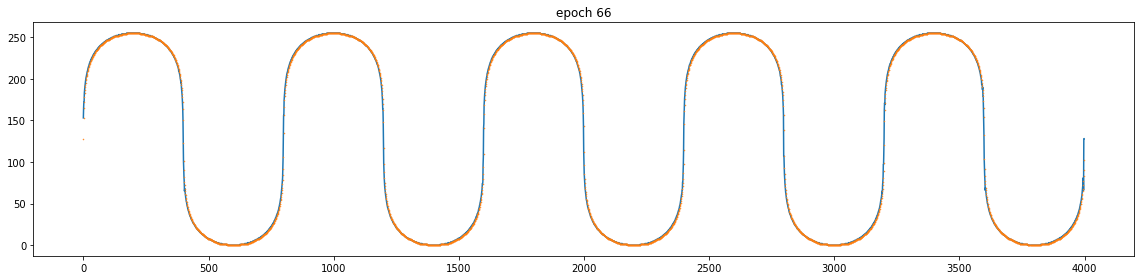

Batch 0 done
Batch 1 done
Batch 2 done
Batch 3 done
Batch 4 done
Batch 5 done
Batch 6 done
Batch 7 done
Batch 8 done
Batch 9 done
Batch 10 done
Batch 11 done
Batch 12 done
Batch 13 done
Batch 14 done
Batch 15 done
epoch 67, loss 0.149602666497


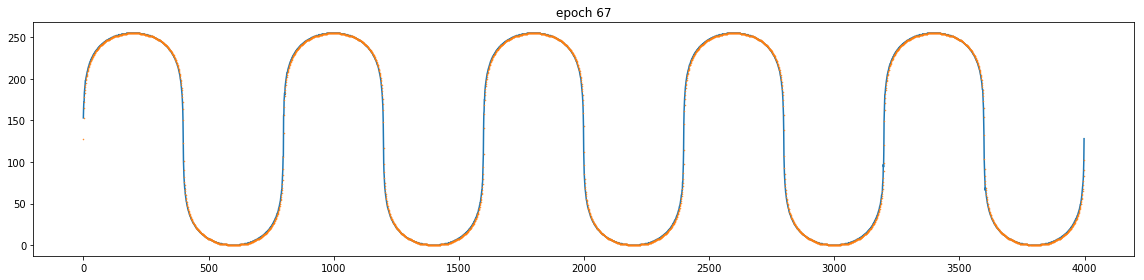

Batch 0 done
Batch 1 done
Batch 2 done
Batch 3 done
Batch 4 done
Batch 5 done
Batch 6 done
Batch 7 done
Batch 8 done
Batch 9 done
Batch 10 done
Batch 11 done
Batch 12 done
Batch 13 done
Batch 14 done
Batch 15 done
epoch 68, loss 0.141188651323


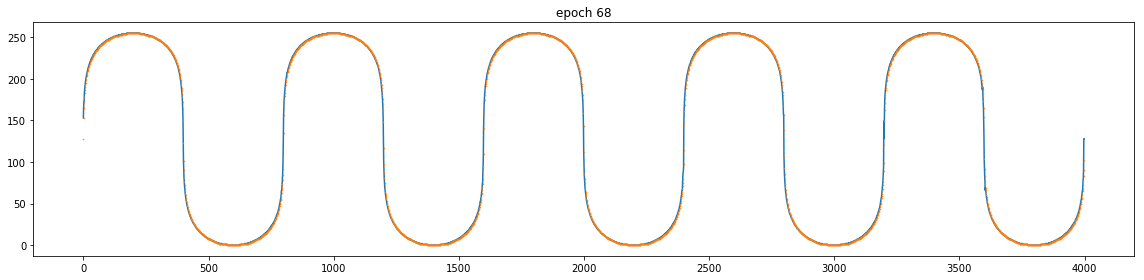

Batch 0 done
Batch 1 done
Batch 2 done
Batch 3 done
Batch 4 done
Batch 5 done
Batch 6 done
Batch 7 done
Batch 8 done
Batch 9 done
Batch 10 done
Batch 11 done
Batch 12 done
Batch 13 done
Batch 14 done
Batch 15 done
epoch 69, loss 0.135022506118


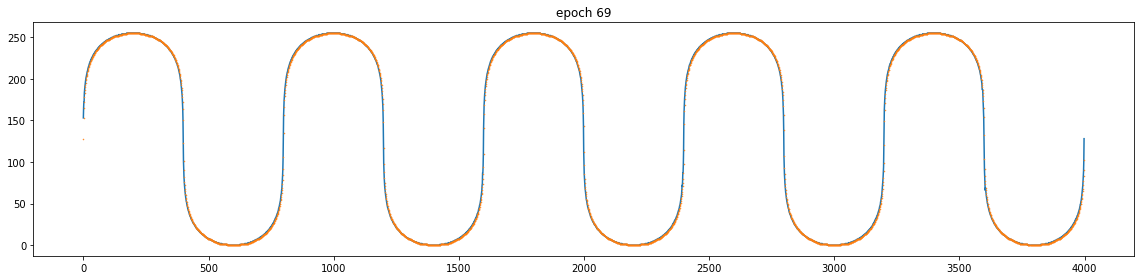

Batch 0 done
Batch 1 done
Batch 2 done
Batch 3 done
Batch 4 done
Batch 5 done
Batch 6 done
Batch 7 done
Batch 8 done
Batch 9 done
Batch 10 done
Batch 11 done
Batch 12 done
Batch 13 done
Batch 14 done
Batch 15 done
epoch 70, loss 0.120198994875


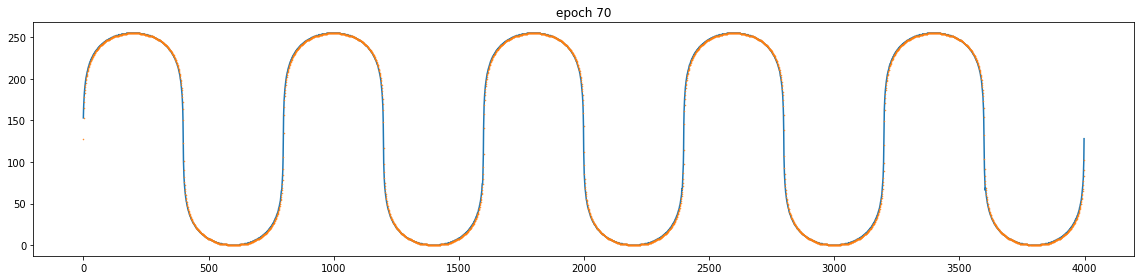

Batch 0 done
Batch 1 done
Batch 2 done
Batch 3 done
Batch 4 done
Batch 5 done
Batch 6 done
Batch 7 done
Batch 8 done
Batch 9 done
Batch 10 done
Batch 11 done
Batch 12 done
Batch 13 done
Batch 14 done
Batch 15 done
epoch 71, loss 0.101812966168


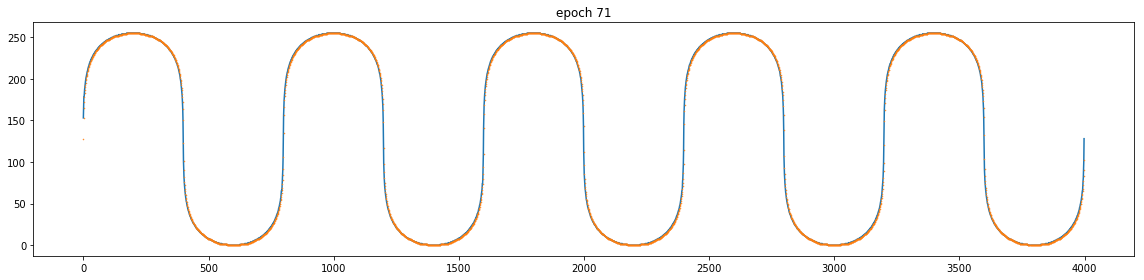

Batch 0 done
Batch 1 done
Batch 2 done
Batch 3 done
Batch 4 done
Batch 5 done
Batch 6 done
Batch 7 done
Batch 8 done
Batch 9 done
Batch 10 done
Batch 11 done
Batch 12 done
Batch 13 done
Batch 14 done
Batch 15 done
epoch 72, loss 0.0907788202167


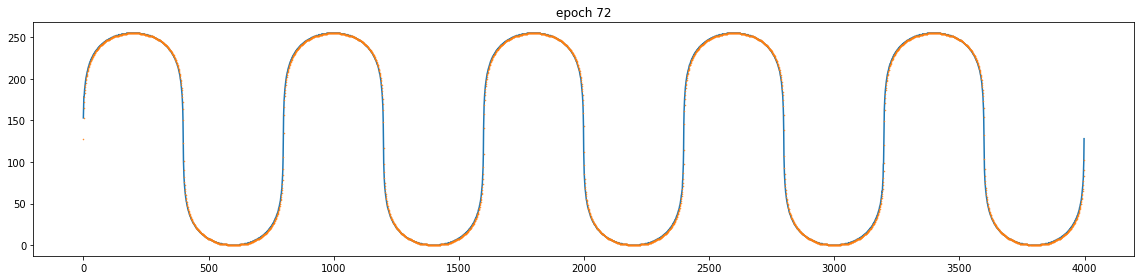

Batch 0 done
Batch 1 done
Batch 2 done
Batch 3 done
Batch 4 done
Batch 5 done
Batch 6 done
Batch 7 done
Batch 8 done
Batch 9 done
Batch 10 done
Batch 11 done
Batch 12 done
Batch 13 done
Batch 14 done
Batch 15 done
epoch 73, loss 0.085416637361


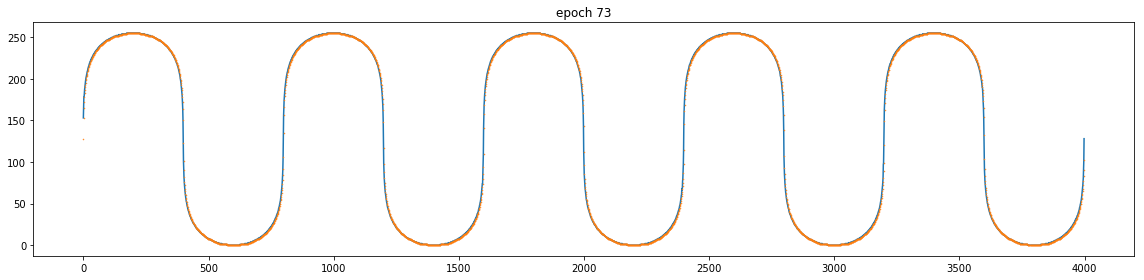

Batch 0 done
Batch 1 done
Batch 2 done
Batch 3 done
Batch 4 done
Batch 5 done
Batch 6 done
Batch 7 done
Batch 8 done
Batch 9 done
Batch 10 done
Batch 11 done
Batch 12 done
Batch 13 done
Batch 14 done
Batch 15 done
epoch 74, loss 0.0729077979922


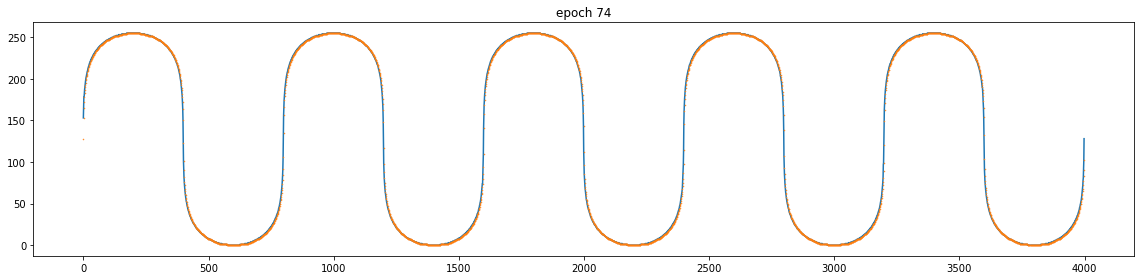

Batch 0 done
Batch 1 done
Batch 2 done
Batch 3 done
Batch 4 done
Batch 5 done
Batch 6 done
Batch 7 done
Batch 8 done
Batch 9 done
Batch 10 done
Batch 11 done
Batch 12 done
Batch 13 done
Batch 14 done
Batch 15 done
epoch 75, loss 0.0690847784281


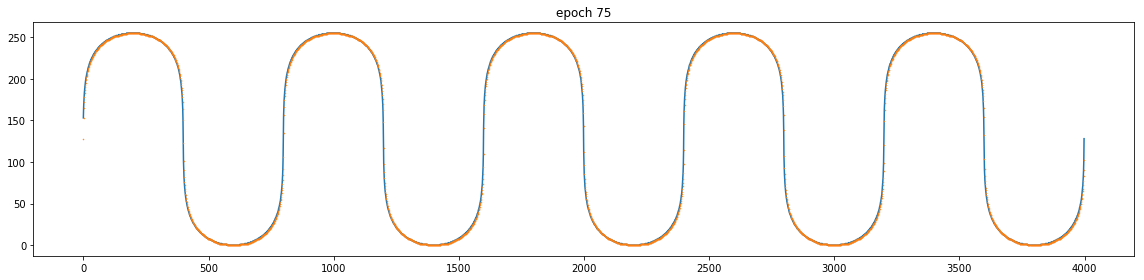

Batch 0 done
Batch 1 done
Batch 2 done
Batch 3 done
Batch 4 done
Batch 5 done
Batch 6 done
Batch 7 done
Batch 8 done
Batch 9 done
Batch 10 done
Batch 11 done
Batch 12 done
Batch 13 done
Batch 14 done
Batch 15 done
epoch 76, loss 0.0596920102835


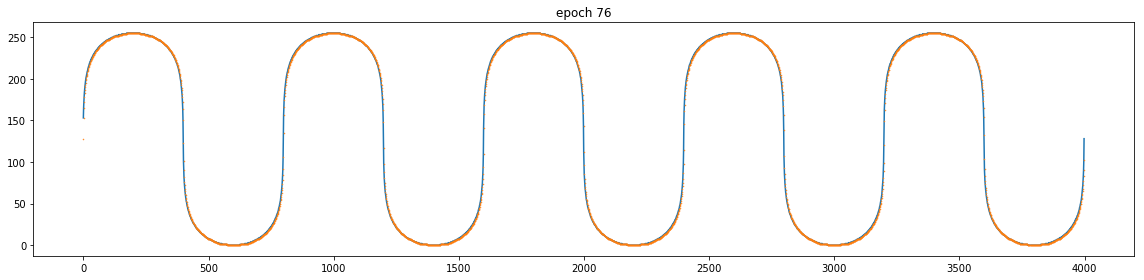

Batch 0 done
Batch 1 done
Batch 2 done
Batch 3 done
Batch 4 done
Batch 5 done
Batch 6 done
Batch 7 done
Batch 8 done
Batch 9 done
Batch 10 done
Batch 11 done
Batch 12 done
Batch 13 done
Batch 14 done
Batch 15 done
epoch 77, loss 0.0547763668001


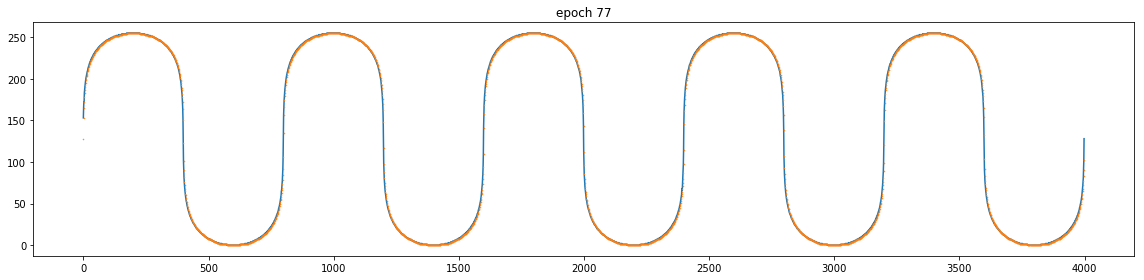

Batch 0 done
Batch 1 done
Batch 2 done
Batch 3 done
Batch 4 done
Batch 5 done
Batch 6 done
Batch 7 done
Batch 8 done
Batch 9 done
Batch 10 done
Batch 11 done
Batch 12 done
Batch 13 done
Batch 14 done
Batch 15 done
epoch 78, loss 0.0490958765149


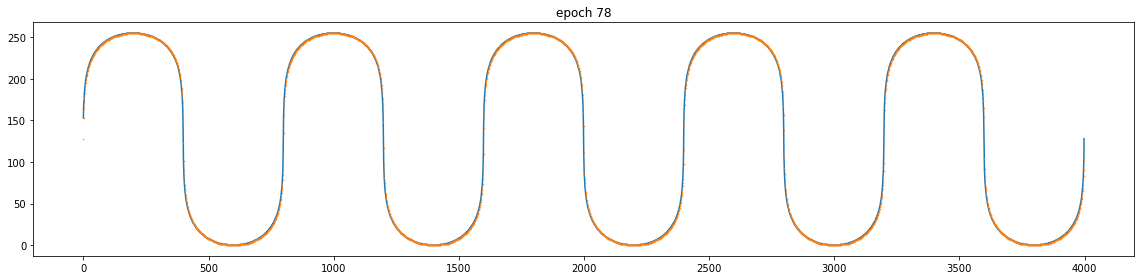

Batch 0 done
Batch 1 done
Batch 2 done
Batch 3 done
Batch 4 done
Batch 5 done
Batch 6 done
Batch 7 done
Batch 8 done
Batch 9 done
Batch 10 done
Batch 11 done
Batch 12 done
Batch 13 done
Batch 14 done
Batch 15 done
epoch 79, loss 0.0442962013185


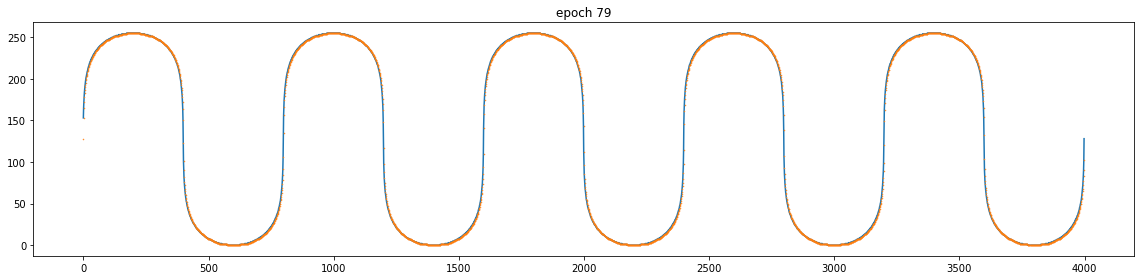

Batch 0 done
Batch 1 done
Batch 2 done
Batch 3 done
Batch 4 done
Batch 5 done
Batch 6 done
Batch 7 done
Batch 8 done
Batch 9 done
Batch 10 done
Batch 11 done
Batch 12 done
Batch 13 done
Batch 14 done
Batch 15 done
epoch 80, loss 0.0396476611495


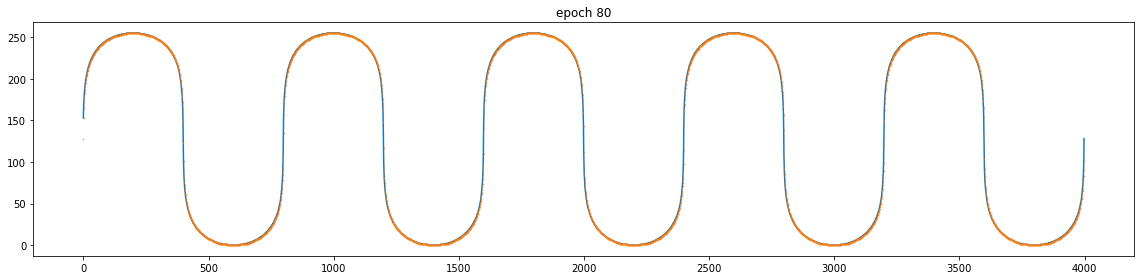

Batch 0 done
Batch 1 done
Batch 2 done
Batch 3 done
Batch 4 done
Batch 5 done
Batch 6 done
Batch 7 done
Batch 8 done
Batch 9 done
Batch 10 done
Batch 11 done
Batch 12 done
Batch 13 done
Batch 14 done
Batch 15 done
epoch 81, loss 0.0363517329097


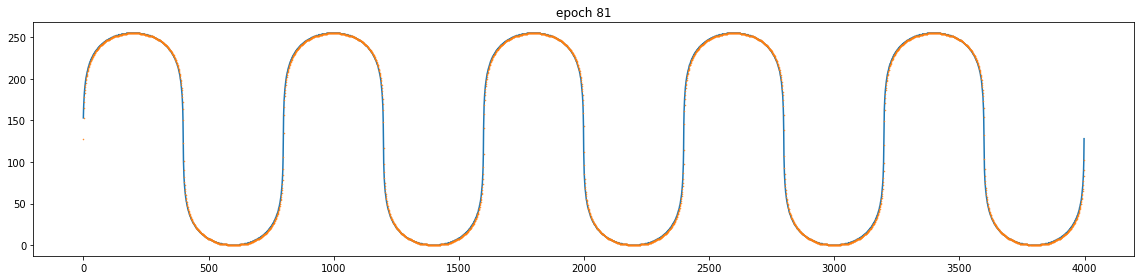

Batch 0 done
Batch 1 done
Batch 2 done
Batch 3 done
Batch 4 done
Batch 5 done
Batch 6 done
Batch 7 done
Batch 8 done
Batch 9 done
Batch 10 done
Batch 11 done
Batch 12 done
Batch 13 done
Batch 14 done
Batch 15 done
epoch 82, loss 0.0322019159794


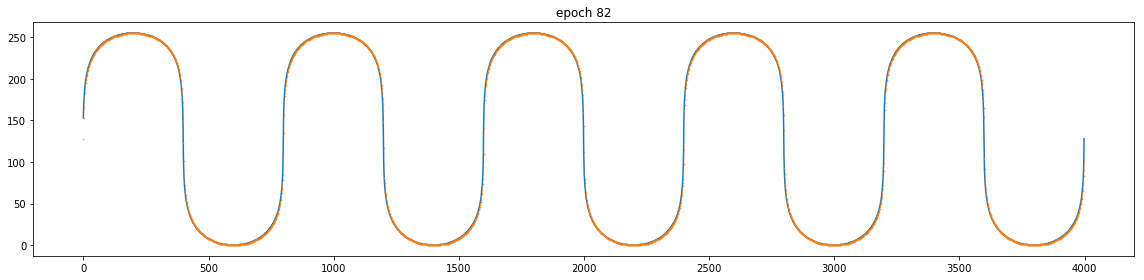

Batch 0 done
Batch 1 done
Batch 2 done
Batch 3 done
Batch 4 done
Batch 5 done
Batch 6 done
Batch 7 done
Batch 8 done
Batch 9 done
Batch 10 done
Batch 11 done
Batch 12 done
Batch 13 done
Batch 14 done
Batch 15 done
epoch 83, loss 0.0298674758524


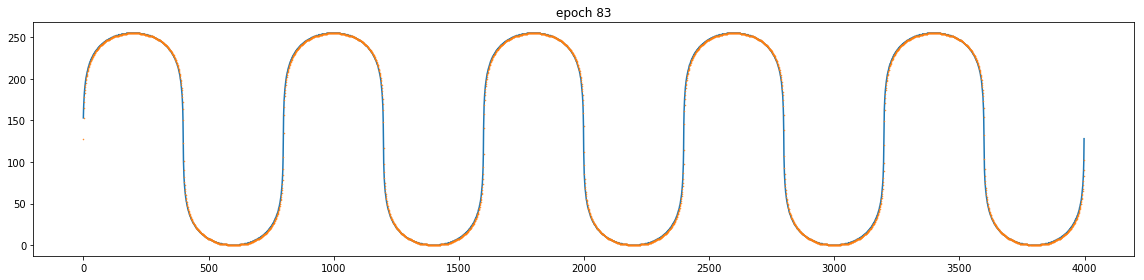

Batch 0 done
Batch 1 done
Batch 2 done
Batch 3 done
Batch 4 done
Batch 5 done
Batch 6 done
Batch 7 done
Batch 8 done
Batch 9 done
Batch 10 done
Batch 11 done
Batch 12 done
Batch 13 done
Batch 14 done
Batch 15 done
epoch 84, loss 0.0265791434795


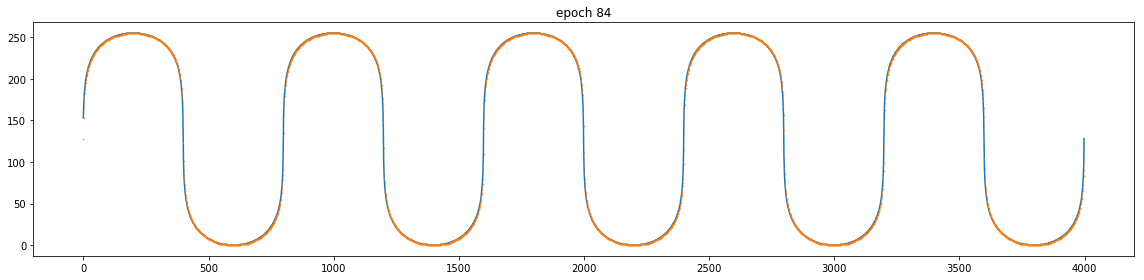

Batch 0 done
Batch 1 done
Batch 2 done
Batch 3 done
Batch 4 done
Batch 5 done
Batch 6 done
Batch 7 done
Batch 8 done
Batch 9 done
Batch 10 done
Batch 11 done
Batch 12 done
Batch 13 done
Batch 14 done
Batch 15 done
epoch 85, loss 0.0245113577694


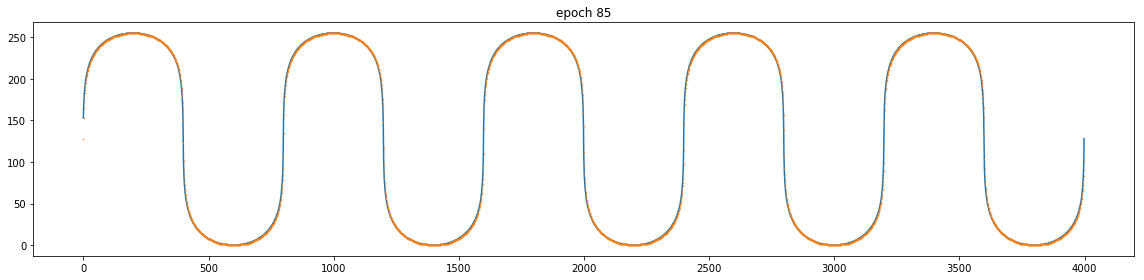

Batch 0 done
Batch 1 done
Batch 2 done
Batch 3 done
Batch 4 done
Batch 5 done
Batch 6 done
Batch 7 done
Batch 8 done
Batch 9 done
Batch 10 done
Batch 11 done
Batch 12 done
Batch 13 done
Batch 14 done
Batch 15 done
epoch 86, loss 0.0220839884132


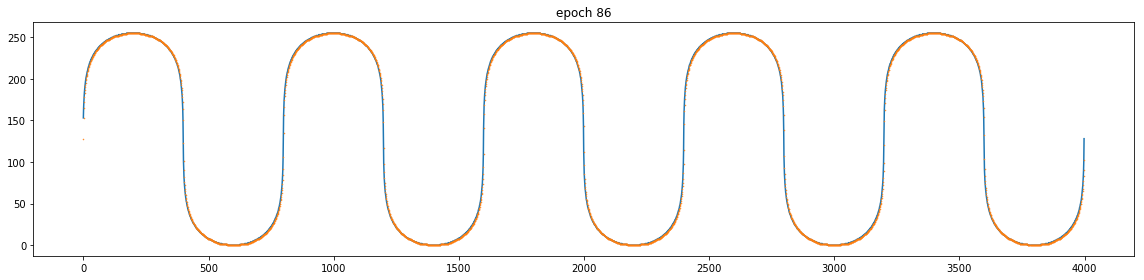

Batch 0 done
Batch 1 done
Batch 2 done
Batch 3 done
Batch 4 done
Batch 5 done
Batch 6 done
Batch 7 done
Batch 8 done
Batch 9 done
Batch 10 done
Batch 11 done
Batch 12 done
Batch 13 done
Batch 14 done
Batch 15 done
epoch 87, loss 0.0203019659966


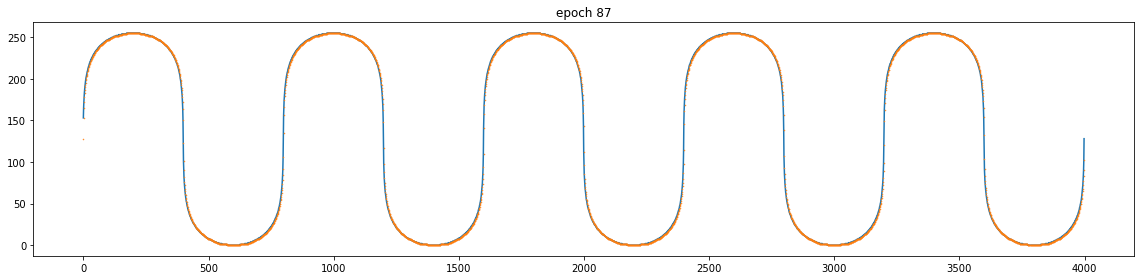

Batch 0 done
Batch 1 done
Batch 2 done
Batch 3 done
Batch 4 done
Batch 5 done
Batch 6 done
Batch 7 done
Batch 8 done
Batch 9 done
Batch 10 done
Batch 11 done
Batch 12 done
Batch 13 done
Batch 14 done
Batch 15 done
epoch 88, loss 0.0184386949986


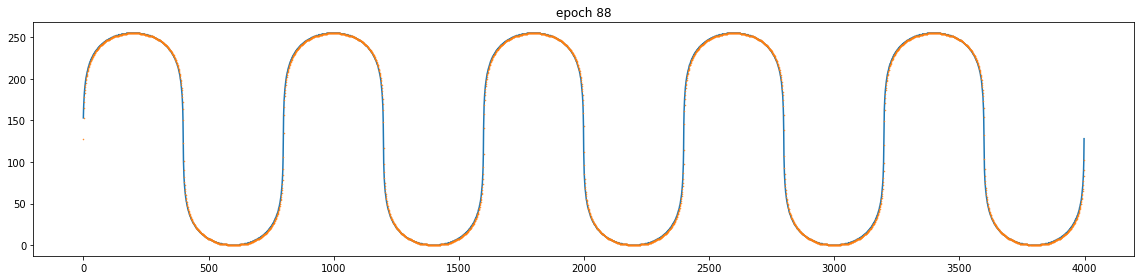

Batch 0 done
Batch 1 done
Batch 2 done
Batch 3 done
Batch 4 done
Batch 5 done
Batch 6 done
Batch 7 done
Batch 8 done
Batch 9 done
Batch 10 done
Batch 11 done
Batch 12 done
Batch 13 done
Batch 14 done
Batch 15 done
epoch 89, loss 0.0169911719859


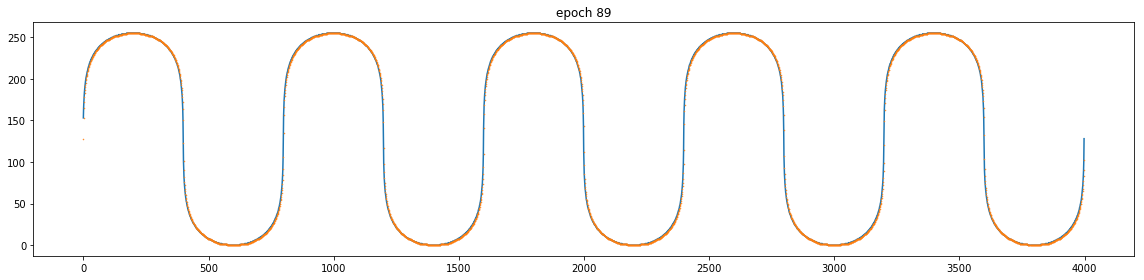

Batch 0 done
Batch 1 done
Batch 2 done
Batch 3 done
Batch 4 done
Batch 5 done
Batch 6 done
Batch 7 done
Batch 8 done
Batch 9 done
Batch 10 done
Batch 11 done
Batch 12 done
Batch 13 done
Batch 14 done
Batch 15 done
epoch 90, loss 0.0155114233494


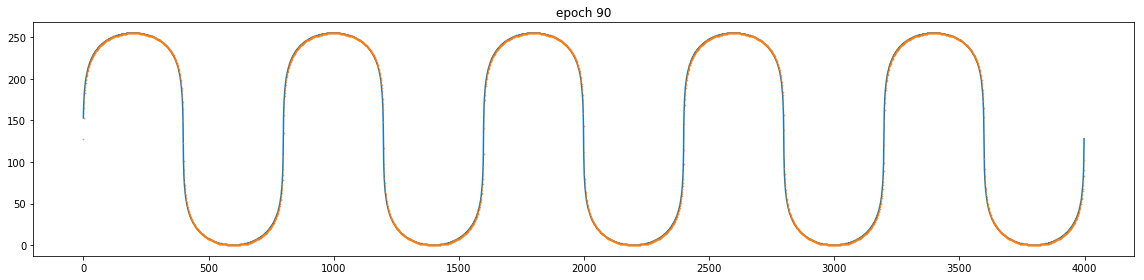

Batch 0 done
Batch 1 done
Batch 2 done
Batch 3 done
Batch 4 done
Batch 5 done
Batch 6 done
Batch 7 done
Batch 8 done
Batch 9 done
Batch 10 done
Batch 11 done
Batch 12 done
Batch 13 done
Batch 14 done
Batch 15 done
epoch 91, loss 0.0144210746512


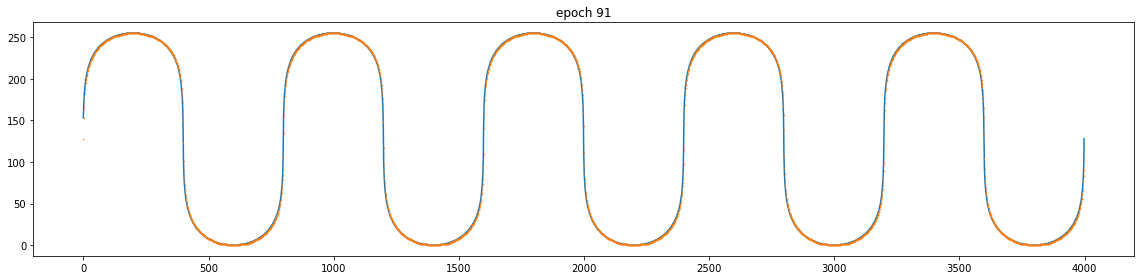

Batch 0 done
Batch 1 done
Batch 2 done
Batch 3 done
Batch 4 done
Batch 5 done
Batch 6 done
Batch 7 done
Batch 8 done
Batch 9 done
Batch 10 done
Batch 11 done
Batch 12 done
Batch 13 done
Batch 14 done
Batch 15 done
epoch 92, loss 0.0130938133225


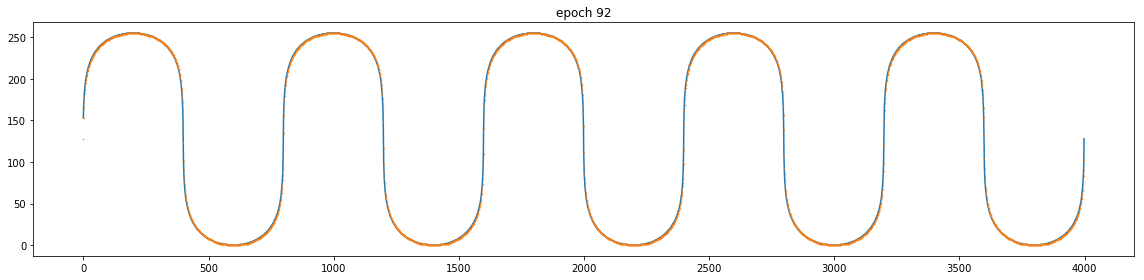

Batch 0 done
Batch 1 done
Batch 2 done
Batch 3 done
Batch 4 done
Batch 5 done
Batch 6 done
Batch 7 done
Batch 8 done
Batch 9 done
Batch 10 done
Batch 11 done
Batch 12 done
Batch 13 done
Batch 14 done
Batch 15 done
epoch 93, loss 0.01230958011


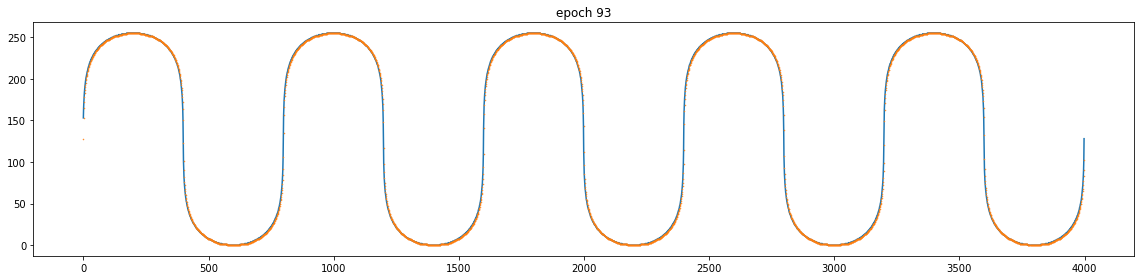

Batch 0 done
Batch 1 done
Batch 2 done
Batch 3 done
Batch 4 done
Batch 5 done
Batch 6 done
Batch 7 done
Batch 8 done
Batch 9 done
Batch 10 done
Batch 11 done
Batch 12 done
Batch 13 done
Batch 14 done
Batch 15 done
epoch 94, loss 0.0112673938274


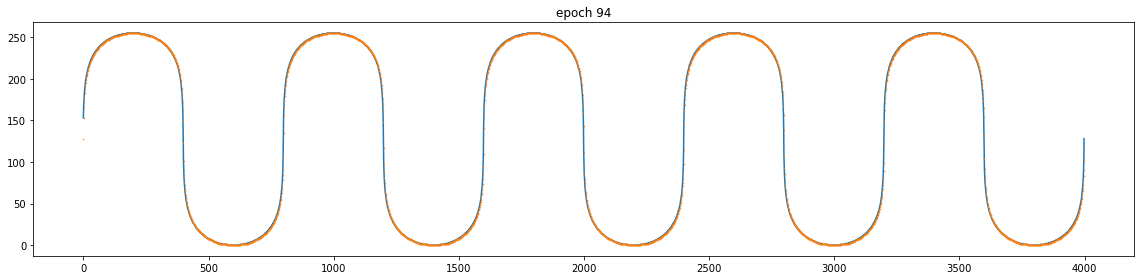

Batch 0 done
Batch 1 done
Batch 2 done
Batch 3 done
Batch 4 done
Batch 5 done
Batch 6 done
Batch 7 done
Batch 8 done
Batch 9 done
Batch 10 done
Batch 11 done
Batch 12 done
Batch 13 done
Batch 14 done
Batch 15 done
epoch 95, loss 0.0105058802292


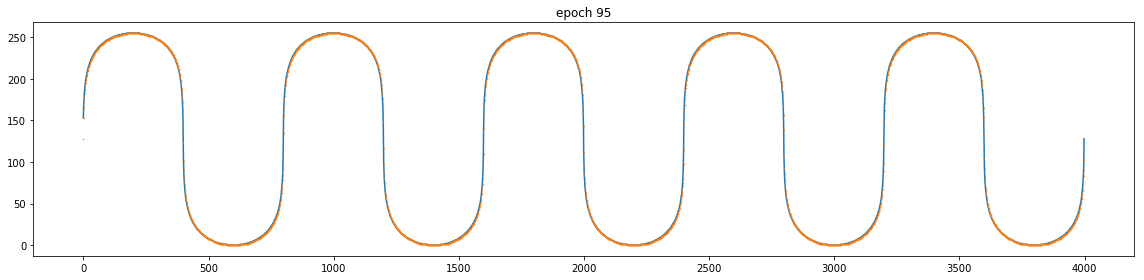

Batch 0 done
Batch 1 done
Batch 2 done
Batch 3 done
Batch 4 done
Batch 5 done
Batch 6 done
Batch 7 done
Batch 8 done
Batch 9 done
Batch 10 done
Batch 11 done
Batch 12 done
Batch 13 done
Batch 14 done
Batch 15 done
epoch 96, loss 0.00980441458523


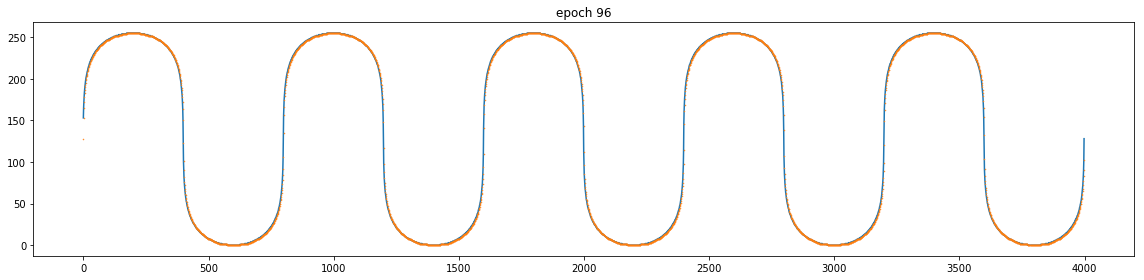

Batch 0 done
Batch 1 done
Batch 2 done
Batch 3 done
Batch 4 done
Batch 5 done
Batch 6 done
Batch 7 done
Batch 8 done
Batch 9 done
Batch 10 done
Batch 11 done
Batch 12 done
Batch 13 done
Batch 14 done
Batch 15 done
epoch 97, loss 0.0091096451506


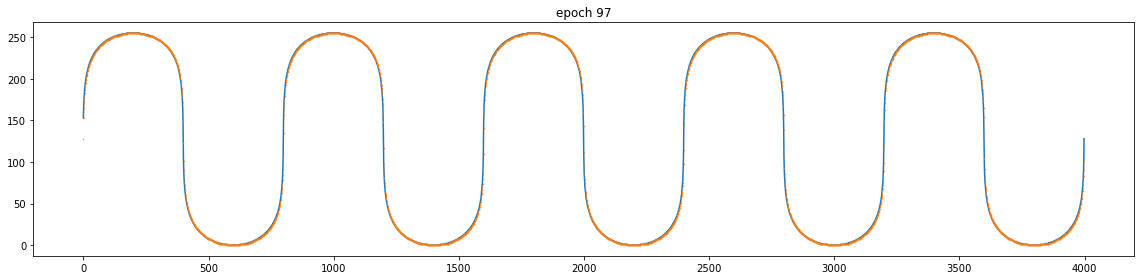

Batch 0 done
Batch 1 done
Batch 2 done
Batch 3 done
Batch 4 done
Batch 5 done
Batch 6 done
Batch 7 done
Batch 8 done
Batch 9 done
Batch 10 done
Batch 11 done
Batch 12 done
Batch 13 done
Batch 14 done
Batch 15 done
epoch 98, loss 0.00847848597914


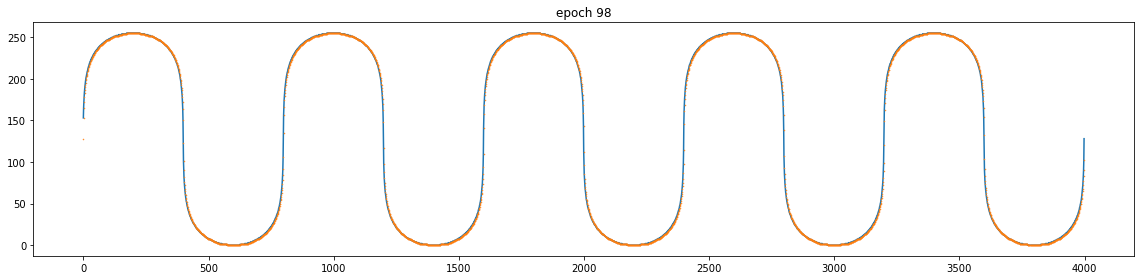

Batch 0 done
Batch 1 done
Batch 2 done
Batch 3 done
Batch 4 done
Batch 5 done
Batch 6 done
Batch 7 done
Batch 8 done
Batch 9 done
Batch 10 done
Batch 11 done
Batch 12 done
Batch 13 done
Batch 14 done
Batch 15 done
epoch 99, loss 0.00805823504925


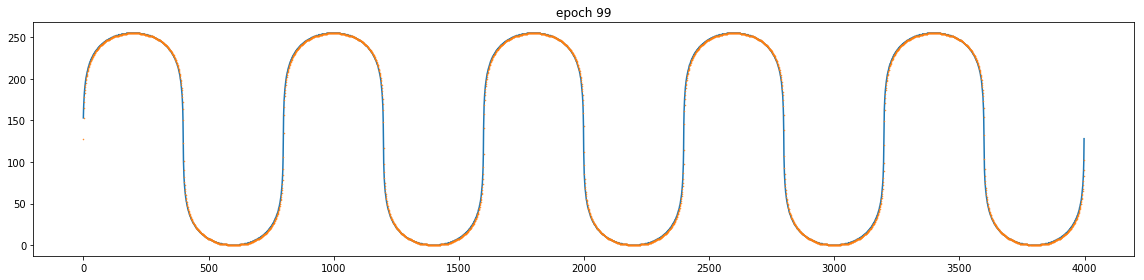

Batch 0 done
Batch 1 done
Batch 2 done
Batch 3 done
Batch 4 done
Batch 5 done
Batch 6 done
Batch 7 done
Batch 8 done
Batch 9 done
Batch 10 done
Batch 11 done
Batch 12 done
Batch 13 done
Batch 14 done
Batch 15 done
epoch 100, loss 0.00746486382559


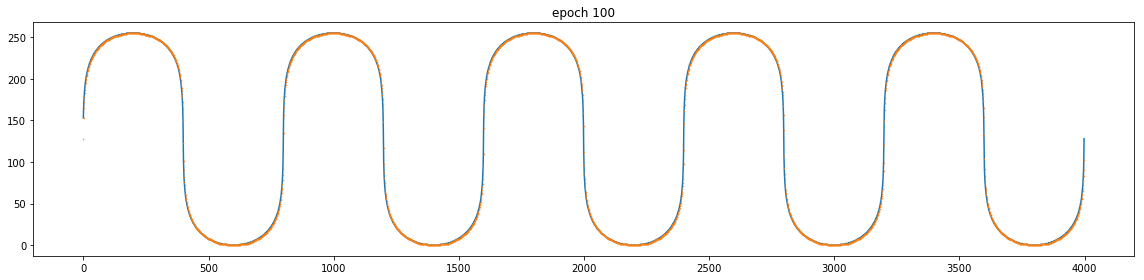

Batch 0 done
Batch 1 done
Batch 2 done
Batch 3 done
Batch 4 done
Batch 5 done
Batch 6 done
Batch 7 done
Batch 8 done
Batch 9 done
Batch 10 done
Batch 11 done
Batch 12 done
Batch 13 done
Batch 14 done
Batch 15 done
epoch 101, loss 0.00703519396484


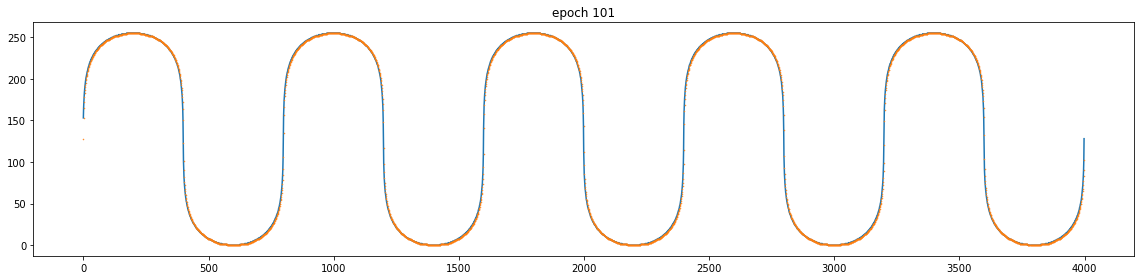

Batch 0 done
Batch 1 done
Batch 2 done
Batch 3 done
Batch 4 done
Batch 5 done
Batch 6 done
Batch 7 done
Batch 8 done
Batch 9 done
Batch 10 done
Batch 11 done
Batch 12 done
Batch 13 done
Batch 14 done
Batch 15 done
epoch 102, loss 0.00666568474844


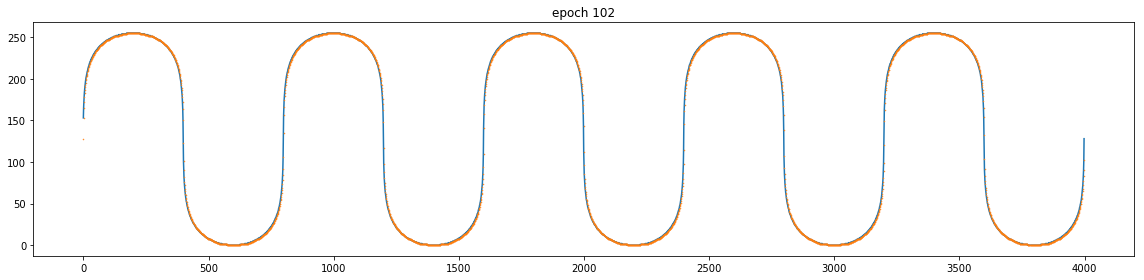

Batch 0 done
Batch 1 done
Batch 2 done
Batch 3 done
Batch 4 done
Batch 5 done
Batch 6 done
Batch 7 done
Batch 8 done
Batch 9 done
Batch 10 done
Batch 11 done
Batch 12 done
Batch 13 done
Batch 14 done
Batch 15 done
epoch 103, loss 0.00626776413992


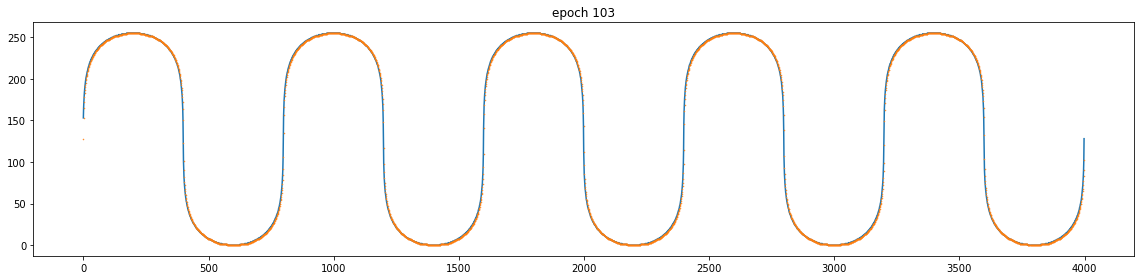

Batch 0 done
Batch 1 done
Batch 2 done
Batch 3 done
Batch 4 done
Batch 5 done
Batch 6 done
Batch 7 done
Batch 8 done
Batch 9 done
Batch 10 done
Batch 11 done
Batch 12 done
Batch 13 done
Batch 14 done
Batch 15 done
epoch 104, loss 0.00592156965286


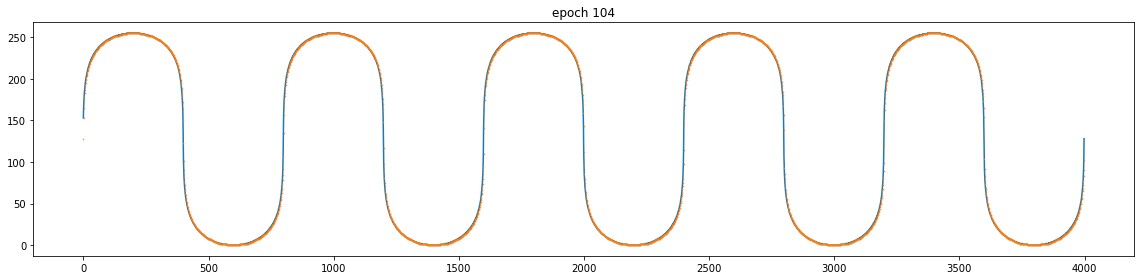

Batch 0 done
Batch 1 done
Batch 2 done
Batch 3 done
Batch 4 done
Batch 5 done
Batch 6 done
Batch 7 done
Batch 8 done
Batch 9 done
Batch 10 done
Batch 11 done
Batch 12 done
Batch 13 done
Batch 14 done
Batch 15 done
epoch 105, loss 0.00564394379035


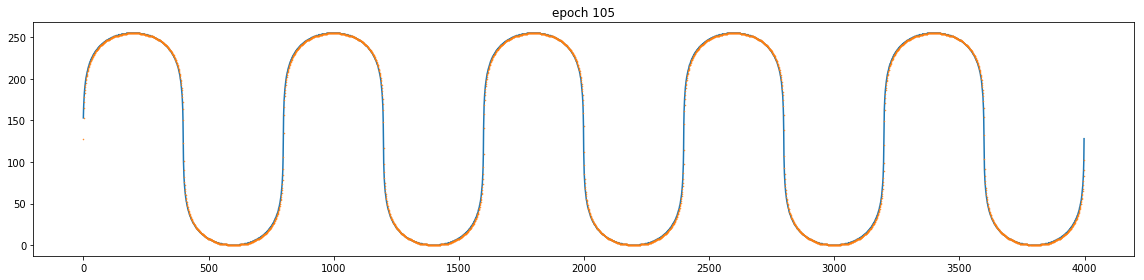

Batch 0 done
Batch 1 done
Batch 2 done
Batch 3 done
Batch 4 done
Batch 5 done
Batch 6 done
Batch 7 done
Batch 8 done
Batch 9 done
Batch 10 done
Batch 11 done
Batch 12 done
Batch 13 done
Batch 14 done
Batch 15 done
epoch 106, loss 0.00532839540392


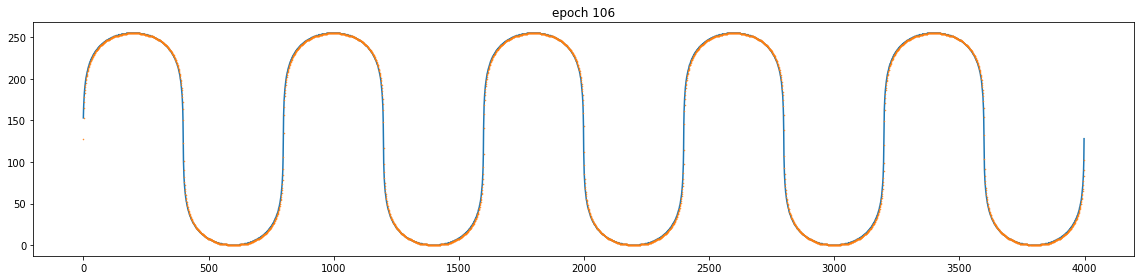

Batch 0 done
Batch 1 done
Batch 2 done
Batch 3 done
Batch 4 done
Batch 5 done
Batch 6 done
Batch 7 done
Batch 8 done
Batch 9 done
Batch 10 done
Batch 11 done
Batch 12 done
Batch 13 done
Batch 14 done
Batch 15 done
epoch 107, loss 0.00506919901818


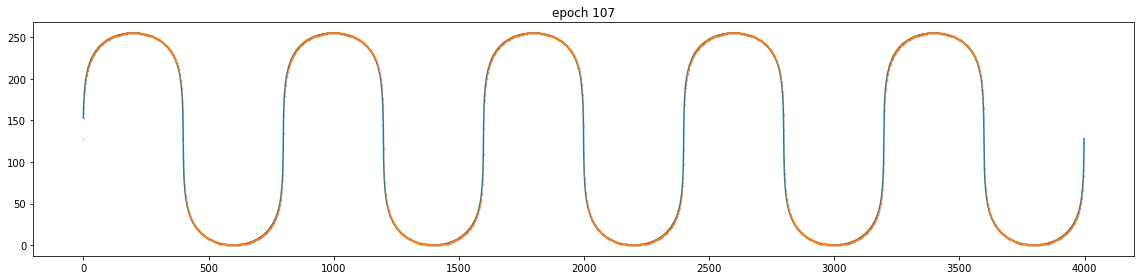

Batch 0 done
Batch 1 done
Batch 2 done
Batch 3 done
Batch 4 done
Batch 5 done
Batch 6 done
Batch 7 done
Batch 8 done
Batch 9 done
Batch 10 done
Batch 11 done
Batch 12 done
Batch 13 done
Batch 14 done
Batch 15 done
epoch 108, loss 0.00484747206792


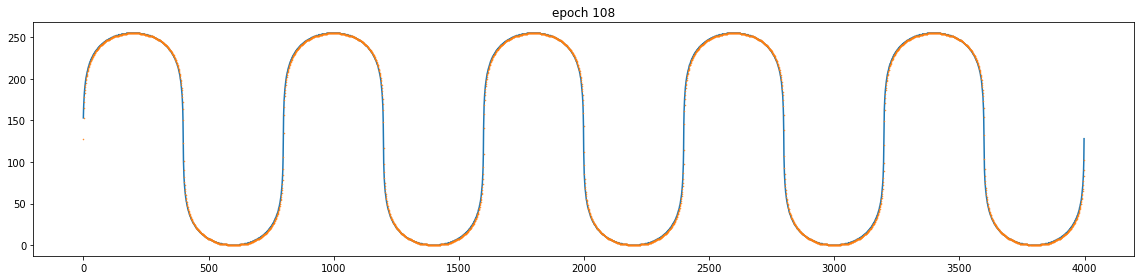

Batch 0 done
Batch 1 done
Batch 2 done
Batch 3 done
Batch 4 done
Batch 5 done
Batch 6 done
Batch 7 done
Batch 8 done
Batch 9 done
Batch 10 done
Batch 11 done
Batch 12 done
Batch 13 done
Batch 14 done
Batch 15 done
epoch 109, loss 0.00461510568857


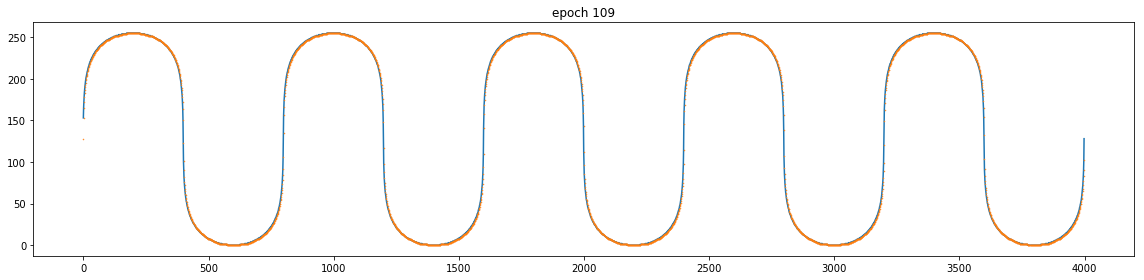

Batch 0 done
Batch 1 done
Batch 2 done
Batch 3 done
Batch 4 done
Batch 5 done
Batch 6 done
Batch 7 done
Batch 8 done
Batch 9 done
Batch 10 done
Batch 11 done
Batch 12 done
Batch 13 done
Batch 14 done
Batch 15 done
epoch 110, loss 0.00440174993128


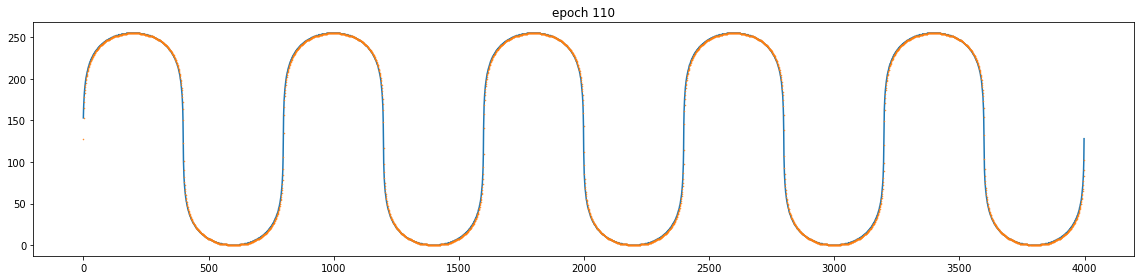

Batch 0 done
Batch 1 done
Batch 2 done
Batch 3 done
Batch 4 done
Batch 5 done
Batch 6 done
Batch 7 done
Batch 8 done
Batch 9 done
Batch 10 done
Batch 11 done
Batch 12 done
Batch 13 done
Batch 14 done
Batch 15 done
epoch 111, loss 0.00421487120911


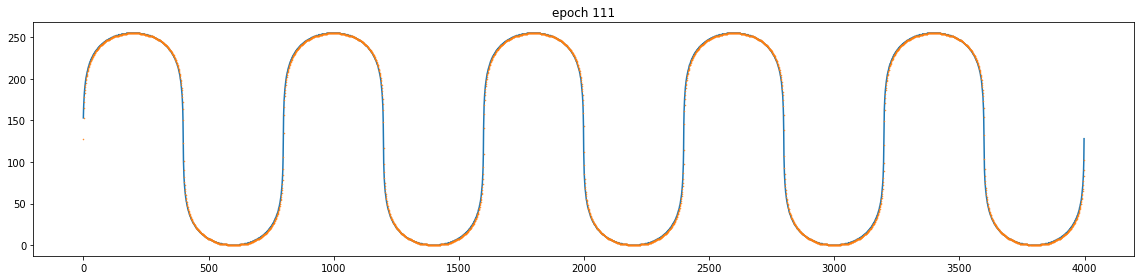

Batch 0 done
Batch 1 done
Batch 2 done
Batch 3 done
Batch 4 done
Batch 5 done
Batch 6 done
Batch 7 done
Batch 8 done
Batch 9 done
Batch 10 done
Batch 11 done
Batch 12 done
Batch 13 done
Batch 14 done
Batch 15 done
epoch 112, loss 0.00404882151634


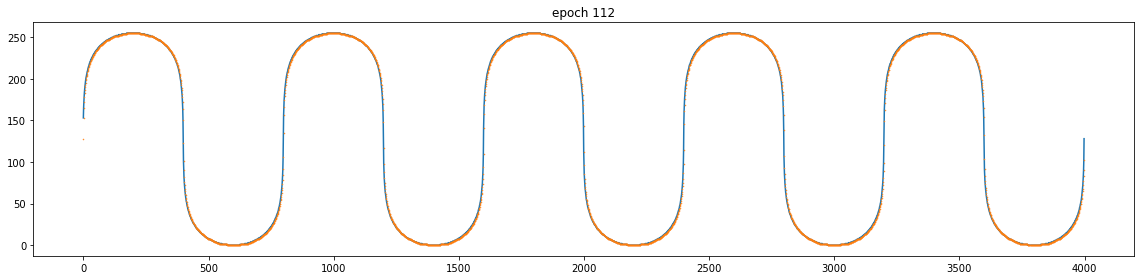

Batch 0 done
Batch 1 done
Batch 2 done
Batch 3 done
Batch 4 done
Batch 5 done
Batch 6 done
Batch 7 done
Batch 8 done
Batch 9 done
Batch 10 done
Batch 11 done
Batch 12 done
Batch 13 done
Batch 14 done
Batch 15 done
epoch 113, loss 0.00388747104444


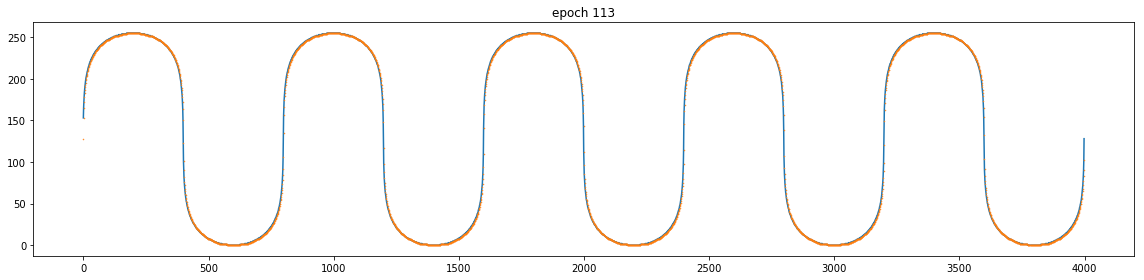

Batch 0 done
Batch 1 done
Batch 2 done
Batch 3 done
Batch 4 done
Batch 5 done
Batch 6 done
Batch 7 done
Batch 8 done
Batch 9 done
Batch 10 done
Batch 11 done
Batch 12 done
Batch 13 done
Batch 14 done
Batch 15 done
epoch 114, loss 0.00372404209338


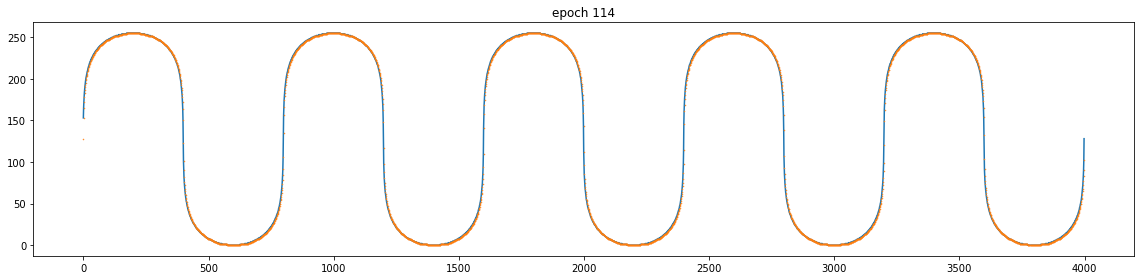

Batch 0 done
Batch 1 done
Batch 2 done
Batch 3 done
Batch 4 done
Batch 5 done
Batch 6 done
Batch 7 done
Batch 8 done
Batch 9 done
Batch 10 done
Batch 11 done
Batch 12 done
Batch 13 done
Batch 14 done
Batch 15 done
epoch 115, loss 0.0035832489375


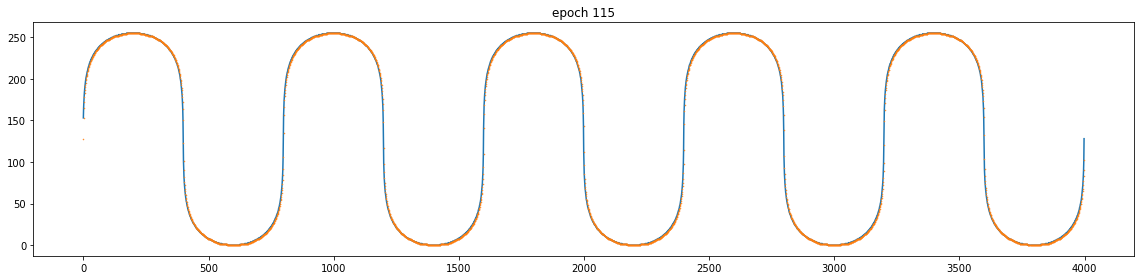

Batch 0 done
Batch 1 done
Batch 2 done
Batch 3 done
Batch 4 done
Batch 5 done
Batch 6 done
Batch 7 done
Batch 8 done
Batch 9 done
Batch 10 done
Batch 11 done
Batch 12 done
Batch 13 done
Batch 14 done
Batch 15 done
epoch 116, loss 0.00346418493427


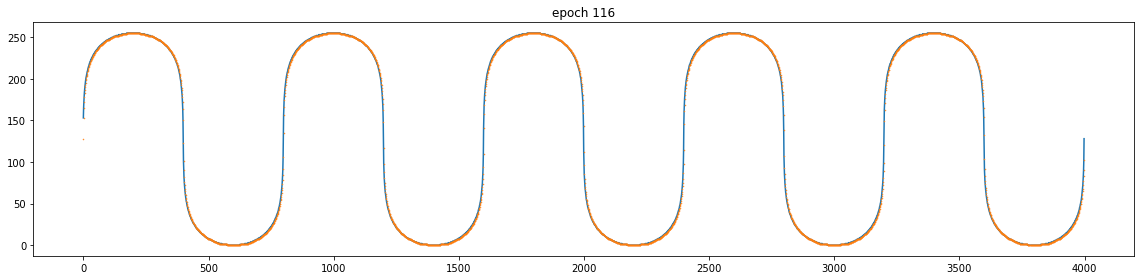

Batch 0 done
Batch 1 done
Batch 2 done
Batch 3 done
Batch 4 done
Batch 5 done
Batch 6 done
Batch 7 done
Batch 8 done
Batch 9 done
Batch 10 done
Batch 11 done
Batch 12 done
Batch 13 done
Batch 14 done
Batch 15 done
epoch 117, loss 0.00333687686361


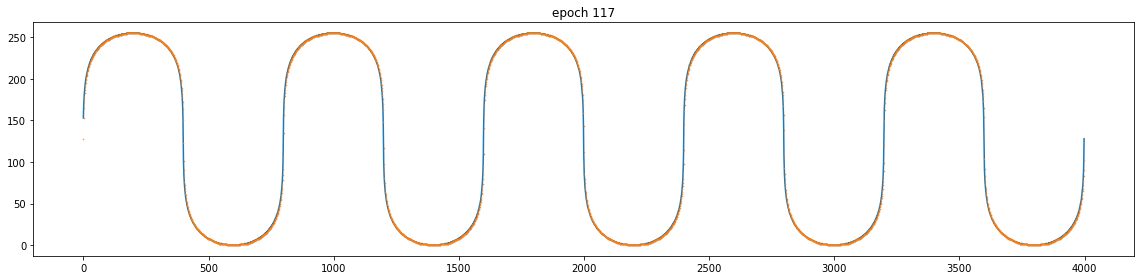

Batch 0 done
Batch 1 done
Batch 2 done
Batch 3 done
Batch 4 done
Batch 5 done
Batch 6 done
Batch 7 done
Batch 8 done
Batch 9 done
Batch 10 done
Batch 11 done
Batch 12 done
Batch 13 done
Batch 14 done
Batch 15 done
epoch 118, loss 0.00321691762656


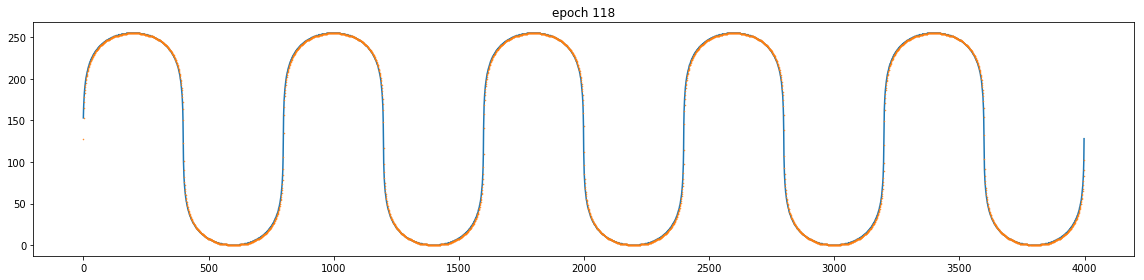

Batch 0 done
Batch 1 done
Batch 2 done
Batch 3 done
Batch 4 done
Batch 5 done
Batch 6 done
Batch 7 done
Batch 8 done
Batch 9 done
Batch 10 done
Batch 11 done
Batch 12 done
Batch 13 done
Batch 14 done
Batch 15 done
epoch 119, loss 0.00310696545057


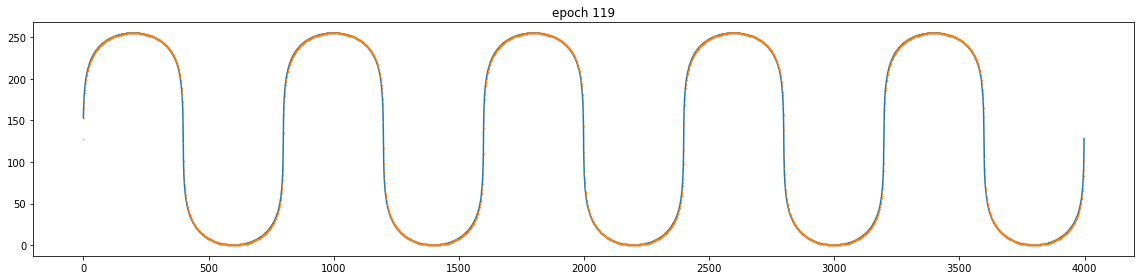

Batch 0 done
Batch 1 done
Batch 2 done
Batch 3 done
Batch 4 done
Batch 5 done
Batch 6 done
Batch 7 done
Batch 8 done
Batch 9 done
Batch 10 done
Batch 11 done
Batch 12 done
Batch 13 done
Batch 14 done
Batch 15 done
epoch 120, loss 0.00301200151443


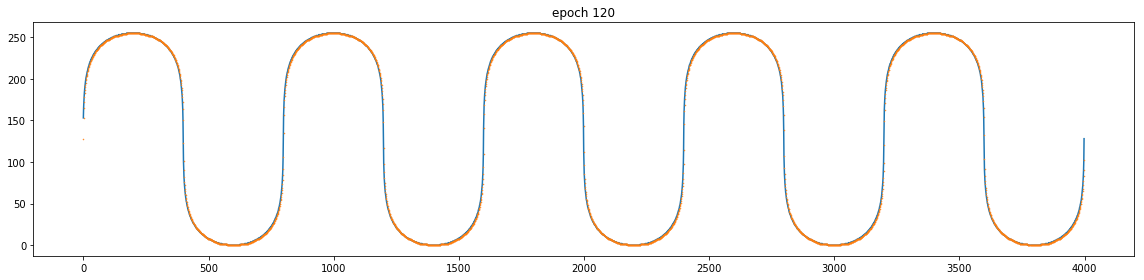

Batch 0 done
Batch 1 done
Batch 2 done
Batch 3 done
Batch 4 done
Batch 5 done
Batch 6 done
Batch 7 done
Batch 8 done
Batch 9 done
Batch 10 done
Batch 11 done
Batch 12 done
Batch 13 done
Batch 14 done
Batch 15 done
epoch 121, loss 0.00291475746781


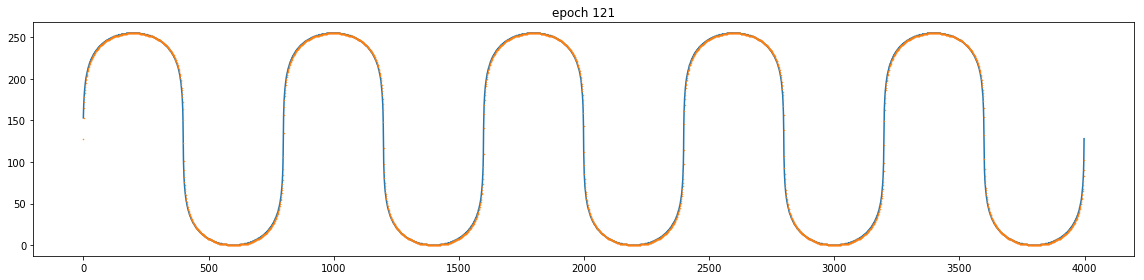

Batch 0 done
Batch 1 done
Batch 2 done
Batch 3 done
Batch 4 done
Batch 5 done
Batch 6 done
Batch 7 done
Batch 8 done
Batch 9 done
Batch 10 done
Batch 11 done
Batch 12 done
Batch 13 done
Batch 14 done
Batch 15 done
epoch 122, loss 0.00282247224823


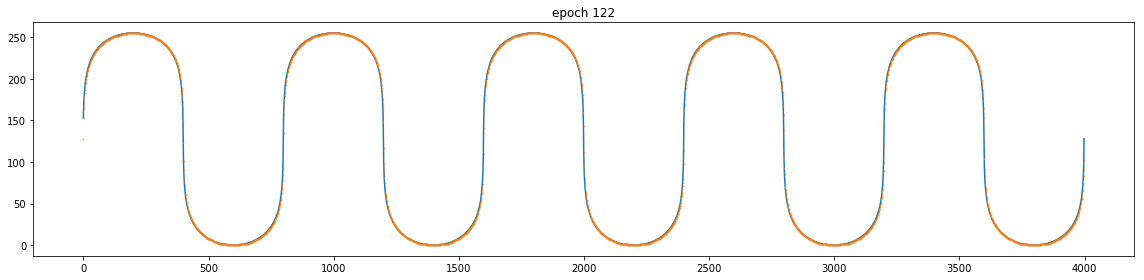

Batch 0 done
Batch 1 done
Batch 2 done
Batch 3 done
Batch 4 done
Batch 5 done
Batch 6 done
Batch 7 done
Batch 8 done
Batch 9 done
Batch 10 done
Batch 11 done
Batch 12 done
Batch 13 done
Batch 14 done
Batch 15 done
epoch 123, loss 0.00273685762659


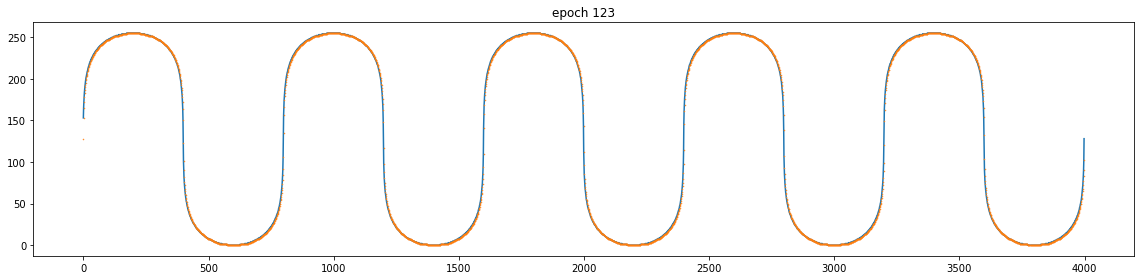

Batch 0 done
Batch 1 done
Batch 2 done
Batch 3 done
Batch 4 done
Batch 5 done
Batch 6 done
Batch 7 done
Batch 8 done
Batch 9 done
Batch 10 done
Batch 11 done
Batch 12 done
Batch 13 done
Batch 14 done
Batch 15 done
epoch 124, loss 0.00265766633675


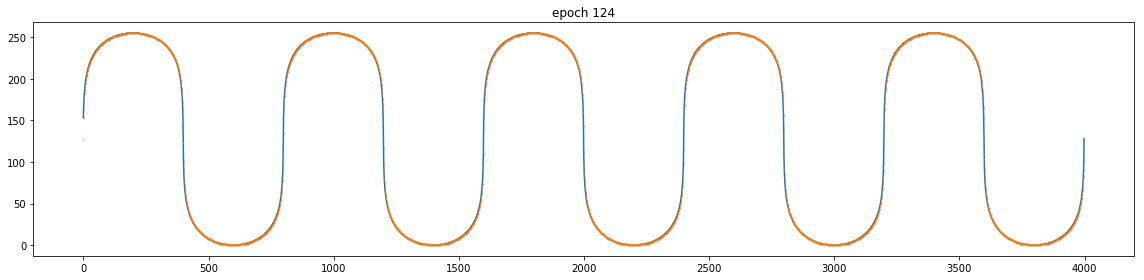

Batch 0 done
Batch 1 done
Batch 2 done
Batch 3 done
Batch 4 done
Batch 5 done
Batch 6 done
Batch 7 done
Batch 8 done
Batch 9 done
Batch 10 done
Batch 11 done
Batch 12 done
Batch 13 done
Batch 14 done
Batch 15 done
epoch 125, loss 0.00258153676987


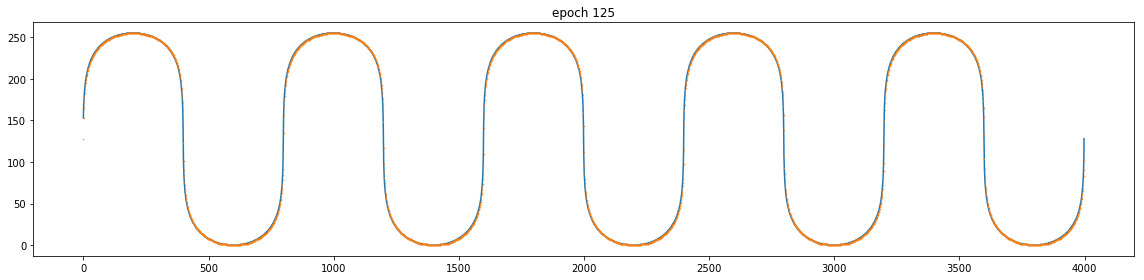

Batch 0 done
Batch 1 done
Batch 2 done
Batch 3 done
Batch 4 done
Batch 5 done
Batch 6 done
Batch 7 done
Batch 8 done
Batch 9 done
Batch 10 done
Batch 11 done
Batch 12 done
Batch 13 done
Batch 14 done
Batch 15 done
epoch 126, loss 0.00250939512625


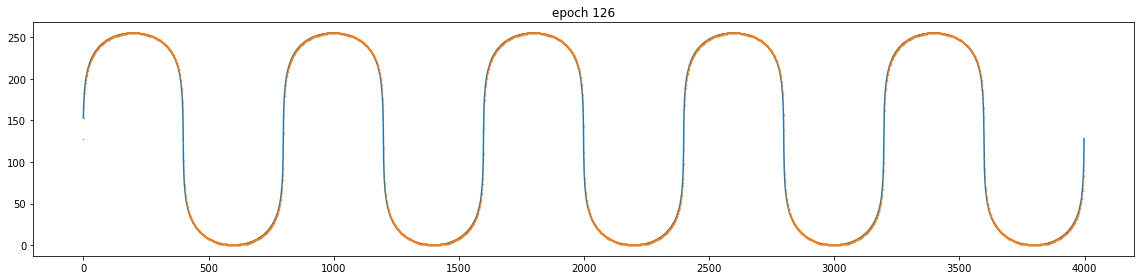

Batch 0 done
Batch 1 done
Batch 2 done
Batch 3 done
Batch 4 done
Batch 5 done
Batch 6 done
Batch 7 done
Batch 8 done
Batch 9 done
Batch 10 done
Batch 11 done
Batch 12 done
Batch 13 done
Batch 14 done
Batch 15 done
epoch 127, loss 0.00243984954432


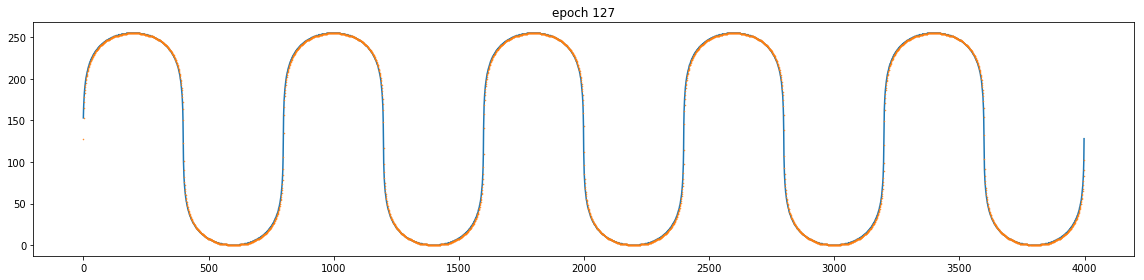

Batch 0 done
Batch 1 done
Batch 2 done
Batch 3 done
Batch 4 done
Batch 5 done
Batch 6 done
Batch 7 done
Batch 8 done
Batch 9 done
Batch 10 done
Batch 11 done
Batch 12 done
Batch 13 done
Batch 14 done
Batch 15 done
epoch 128, loss 0.00237420620397


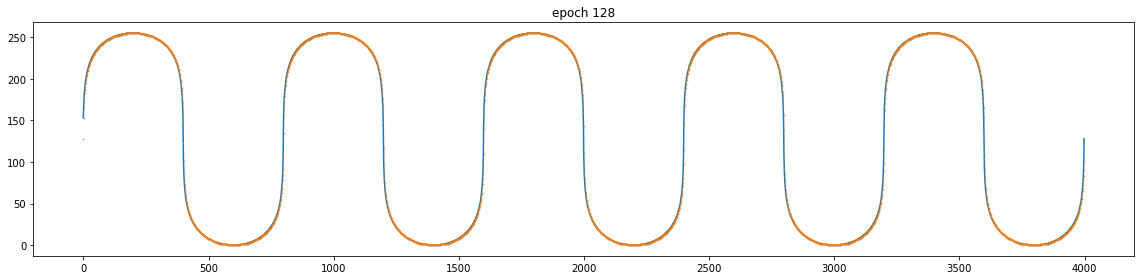

Batch 0 done
Batch 1 done
Batch 2 done
Batch 3 done
Batch 4 done
Batch 5 done
Batch 6 done
Batch 7 done
Batch 8 done
Batch 9 done
Batch 10 done
Batch 11 done
Batch 12 done
Batch 13 done
Batch 14 done
Batch 15 done
epoch 129, loss 0.0023127195891


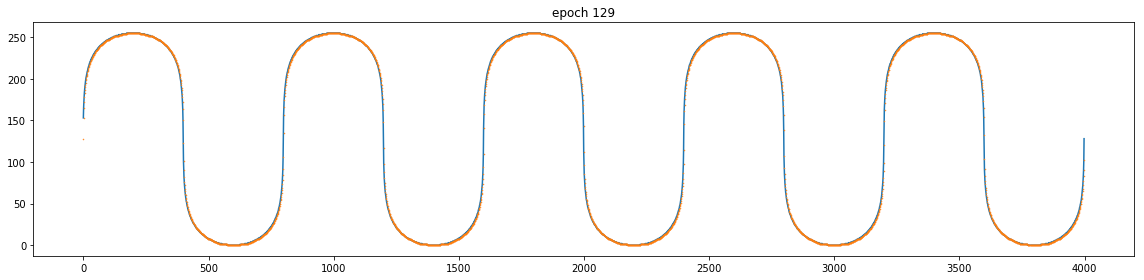

Batch 0 done
Batch 1 done
Batch 2 done
Batch 3 done
Batch 4 done
Batch 5 done
Batch 6 done
Batch 7 done
Batch 8 done
Batch 9 done
Batch 10 done
Batch 11 done
Batch 12 done
Batch 13 done
Batch 14 done
Batch 15 done
epoch 130, loss 0.0022531603463


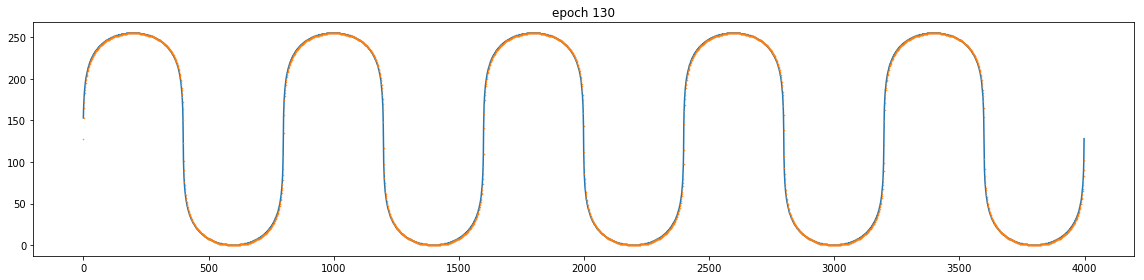

Batch 0 done
Batch 1 done
Batch 2 done
Batch 3 done
Batch 4 done
Batch 5 done
Batch 6 done
Batch 7 done
Batch 8 done
Batch 9 done
Batch 10 done
Batch 11 done
Batch 12 done
Batch 13 done
Batch 14 done
Batch 15 done
epoch 131, loss 0.00219609006308


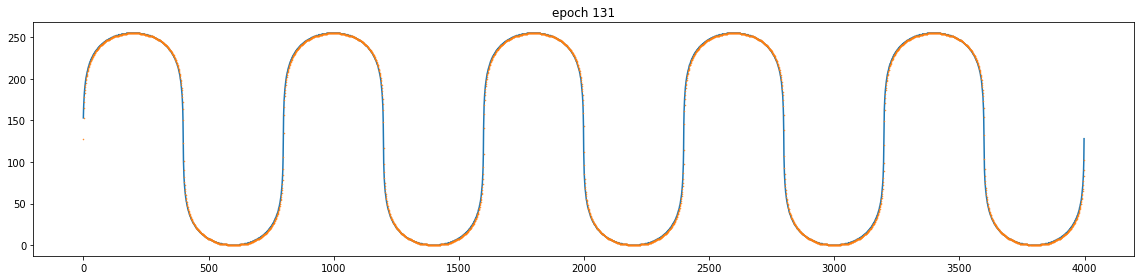

Batch 0 done
Batch 1 done
Batch 2 done
Batch 3 done
Batch 4 done
Batch 5 done
Batch 6 done
Batch 7 done
Batch 8 done
Batch 9 done
Batch 10 done
Batch 11 done
Batch 12 done
Batch 13 done
Batch 14 done
Batch 15 done
epoch 132, loss 0.0021407045424


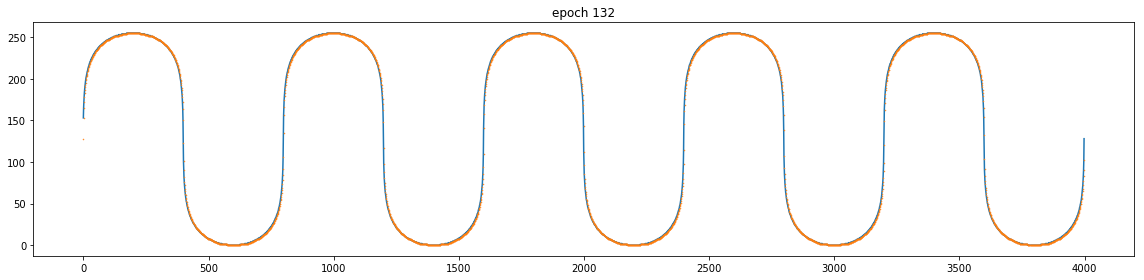

Batch 0 done
Batch 1 done
Batch 2 done
Batch 3 done
Batch 4 done
Batch 5 done
Batch 6 done
Batch 7 done
Batch 8 done
Batch 9 done
Batch 10 done
Batch 11 done
Batch 12 done
Batch 13 done
Batch 14 done
Batch 15 done
epoch 133, loss 0.00208735652268


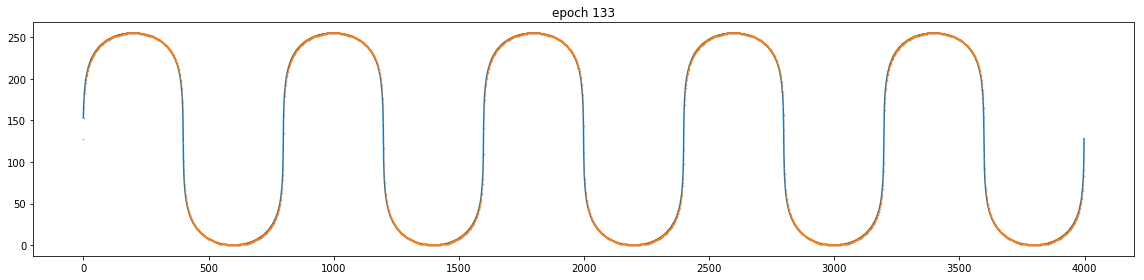

Batch 0 done
Batch 1 done
Batch 2 done
Batch 3 done
Batch 4 done
Batch 5 done
Batch 6 done
Batch 7 done
Batch 8 done
Batch 9 done
Batch 10 done
Batch 11 done
Batch 12 done
Batch 13 done
Batch 14 done
Batch 15 done
epoch 134, loss 0.00203768559732


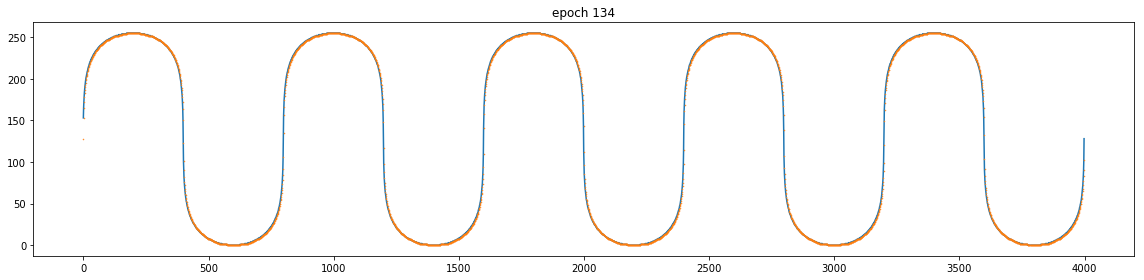

Batch 0 done
Batch 1 done
Batch 2 done
Batch 3 done
Batch 4 done
Batch 5 done
Batch 6 done
Batch 7 done
Batch 8 done
Batch 9 done
Batch 10 done
Batch 11 done
Batch 12 done
Batch 13 done
Batch 14 done
Batch 15 done
epoch 135, loss 0.00198956998065


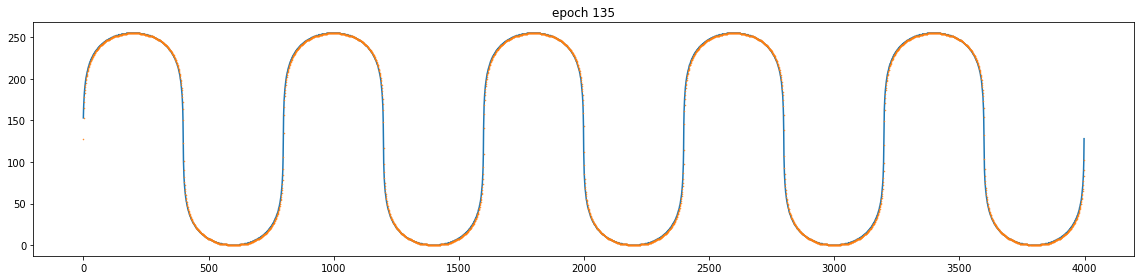

Batch 0 done
Batch 1 done
Batch 2 done
Batch 3 done
Batch 4 done
Batch 5 done
Batch 6 done
Batch 7 done
Batch 8 done
Batch 9 done
Batch 10 done
Batch 11 done
Batch 12 done
Batch 13 done
Batch 14 done
Batch 15 done
epoch 136, loss 0.00194289896172


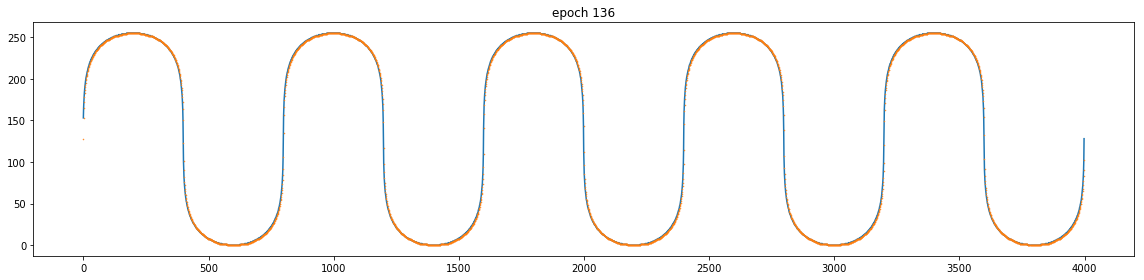

Batch 0 done
Batch 1 done
Batch 2 done
Batch 3 done
Batch 4 done
Batch 5 done
Batch 6 done
Batch 7 done
Batch 8 done
Batch 9 done
Batch 10 done
Batch 11 done
Batch 12 done
Batch 13 done
Batch 14 done
Batch 15 done
epoch 137, loss 0.00189752492588


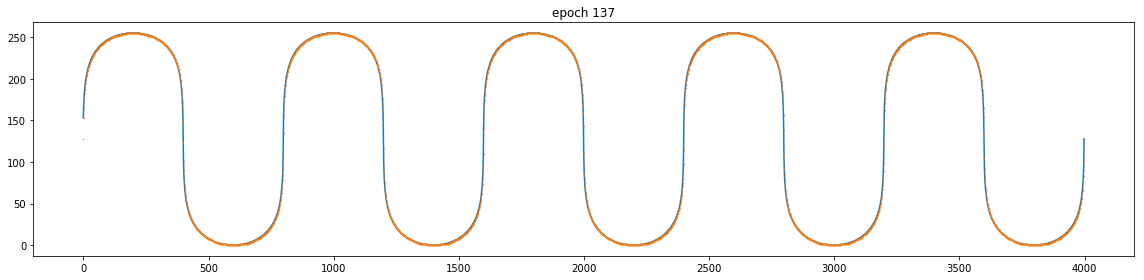

Batch 0 done
Batch 1 done
Batch 2 done
Batch 3 done
Batch 4 done
Batch 5 done
Batch 6 done
Batch 7 done
Batch 8 done
Batch 9 done
Batch 10 done
Batch 11 done
Batch 12 done
Batch 13 done
Batch 14 done
Batch 15 done
epoch 138, loss 0.00185437919572


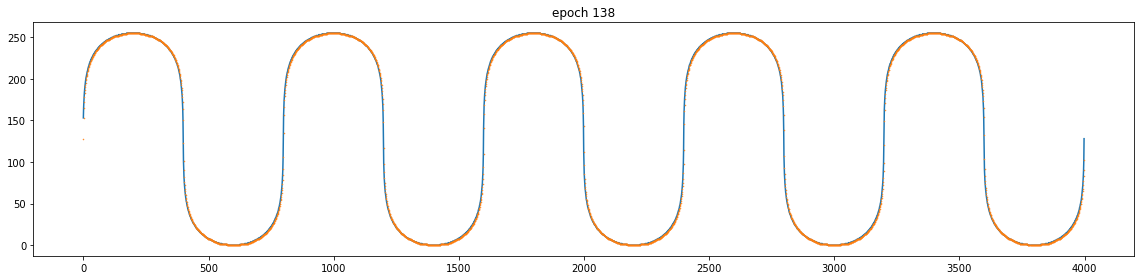

Batch 0 done
Batch 1 done
Batch 2 done
Batch 3 done
Batch 4 done
Batch 5 done
Batch 6 done
Batch 7 done
Batch 8 done
Batch 9 done
Batch 10 done
Batch 11 done
Batch 12 done
Batch 13 done
Batch 14 done
Batch 15 done
epoch 139, loss 0.00181271333713


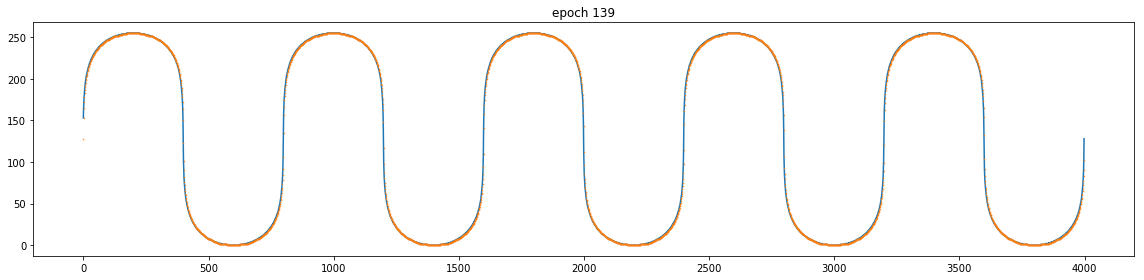

Batch 0 done
Batch 1 done
Batch 2 done
Batch 3 done
Batch 4 done
Batch 5 done
Batch 6 done
Batch 7 done
Batch 8 done
Batch 9 done
Batch 10 done
Batch 11 done
Batch 12 done
Batch 13 done
Batch 14 done
Batch 15 done
epoch 140, loss 0.00177275005262


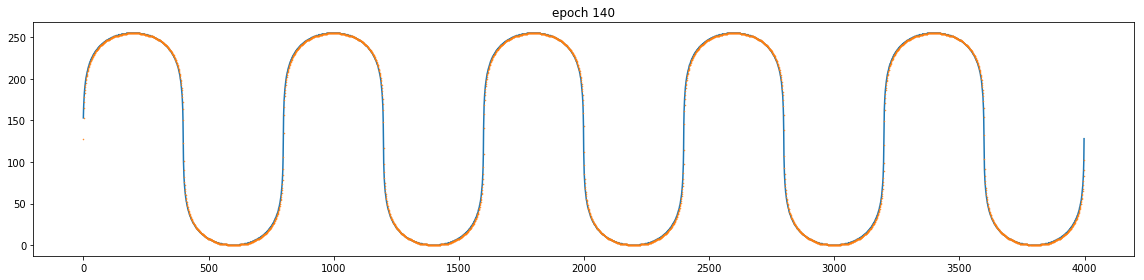

Batch 0 done
Batch 1 done
Batch 2 done
Batch 3 done
Batch 4 done
Batch 5 done
Batch 6 done
Batch 7 done
Batch 8 done
Batch 9 done
Batch 10 done
Batch 11 done
Batch 12 done
Batch 13 done
Batch 14 done
Batch 15 done
epoch 141, loss 0.00173374405131


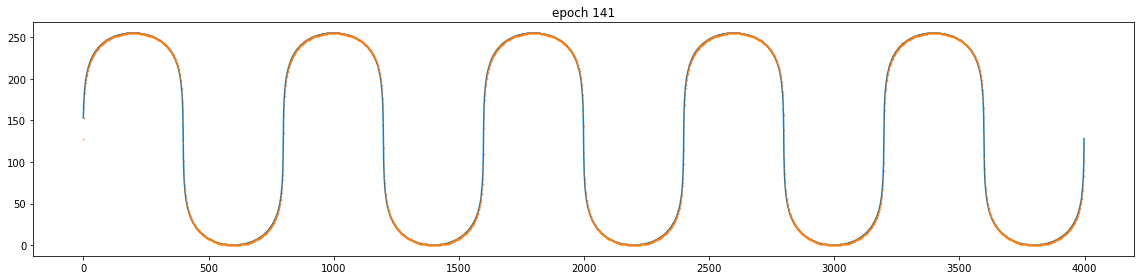

Batch 0 done
Batch 1 done
Batch 2 done
Batch 3 done
Batch 4 done
Batch 5 done
Batch 6 done
Batch 7 done
Batch 8 done
Batch 9 done
Batch 10 done
Batch 11 done
Batch 12 done
Batch 13 done
Batch 14 done
Batch 15 done
epoch 142, loss 0.00169647531584


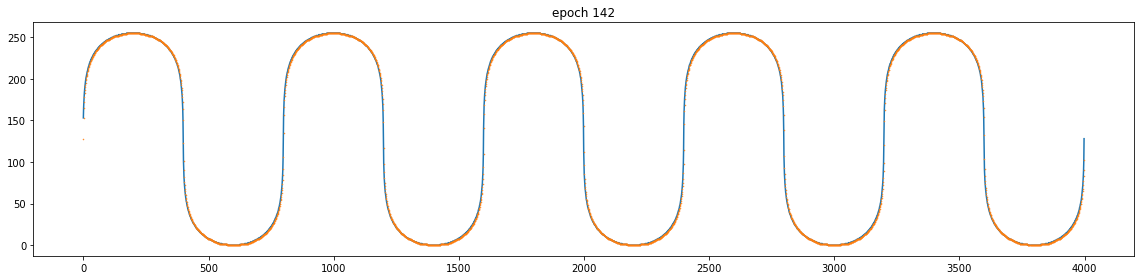

Batch 0 done
Batch 1 done
Batch 2 done
Batch 3 done
Batch 4 done
Batch 5 done
Batch 6 done
Batch 7 done
Batch 8 done
Batch 9 done
Batch 10 done
Batch 11 done
Batch 12 done
Batch 13 done
Batch 14 done
Batch 15 done
epoch 143, loss 0.00166077900212


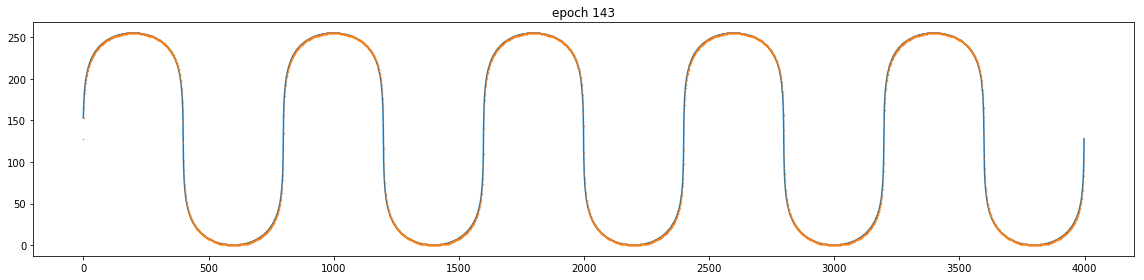

Batch 0 done
Batch 1 done
Batch 2 done
Batch 3 done
Batch 4 done
Batch 5 done
Batch 6 done
Batch 7 done
Batch 8 done
Batch 9 done
Batch 10 done
Batch 11 done
Batch 12 done
Batch 13 done
Batch 14 done
Batch 15 done
epoch 144, loss 0.00162694533356


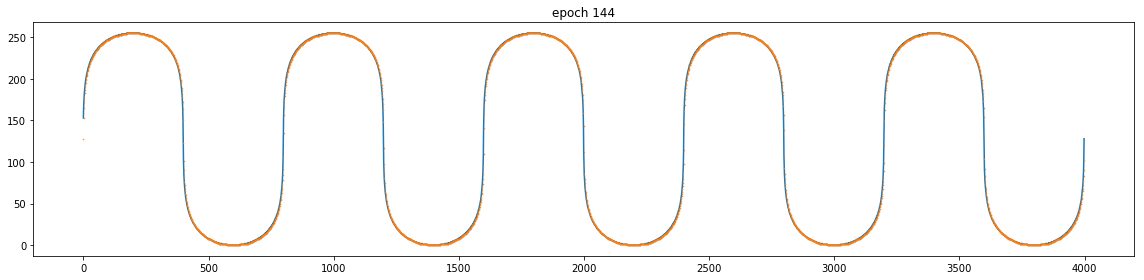

Batch 0 done
Batch 1 done
Batch 2 done
Batch 3 done
Batch 4 done
Batch 5 done
Batch 6 done
Batch 7 done
Batch 8 done
Batch 9 done
Batch 10 done
Batch 11 done
Batch 12 done
Batch 13 done
Batch 14 done
Batch 15 done
epoch 145, loss 0.00159440748394


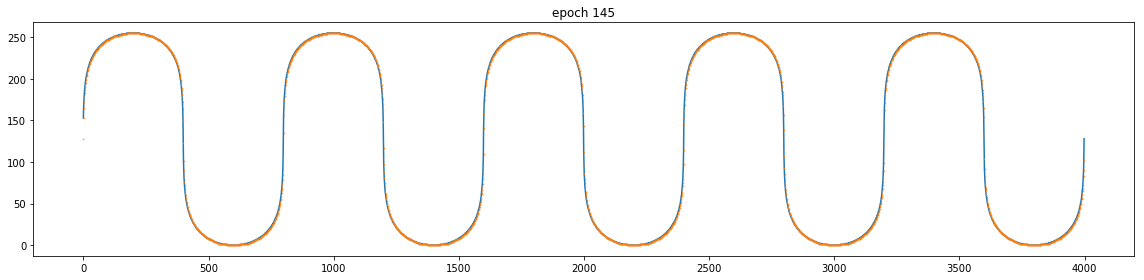

Batch 0 done
Batch 1 done
Batch 2 done
Batch 3 done
Batch 4 done
Batch 5 done
Batch 6 done
Batch 7 done
Batch 8 done
Batch 9 done
Batch 10 done
Batch 11 done
Batch 12 done
Batch 13 done
Batch 14 done
Batch 15 done
epoch 146, loss 0.00156304787379


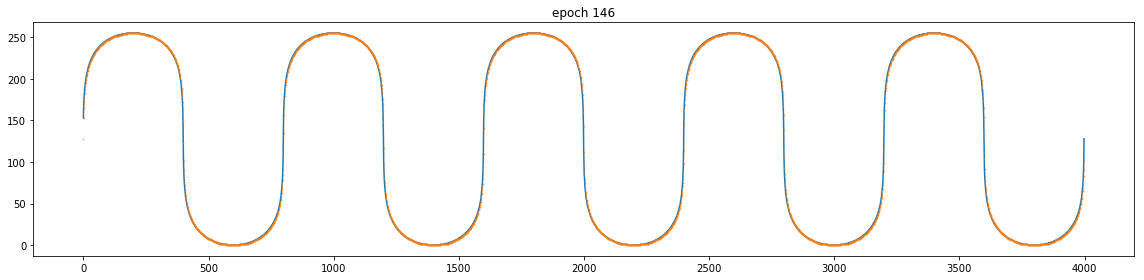

Batch 0 done
Batch 1 done
Batch 2 done
Batch 3 done
Batch 4 done
Batch 5 done
Batch 6 done
Batch 7 done
Batch 8 done
Batch 9 done
Batch 10 done
Batch 11 done
Batch 12 done
Batch 13 done
Batch 14 done
Batch 15 done
epoch 147, loss 0.00153287744615


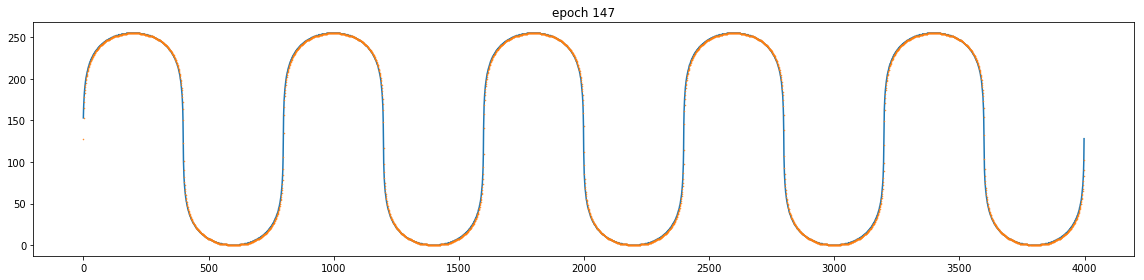

Batch 0 done
Batch 1 done
Batch 2 done
Batch 3 done
Batch 4 done
Batch 5 done
Batch 6 done
Batch 7 done
Batch 8 done
Batch 9 done
Batch 10 done
Batch 11 done
Batch 12 done
Batch 13 done
Batch 14 done
Batch 15 done
epoch 148, loss 0.00150384951849


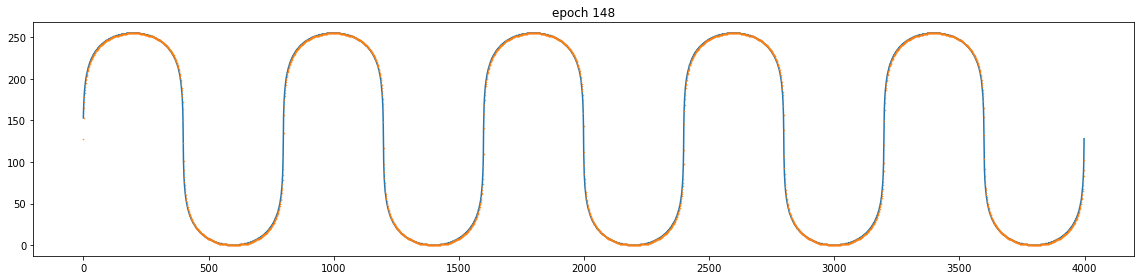

Batch 0 done
Batch 1 done
Batch 2 done
Batch 3 done
Batch 4 done
Batch 5 done
Batch 6 done
Batch 7 done
Batch 8 done
Batch 9 done
Batch 10 done
Batch 11 done
Batch 12 done
Batch 13 done
Batch 14 done
Batch 15 done
epoch 149, loss 0.00147595268209


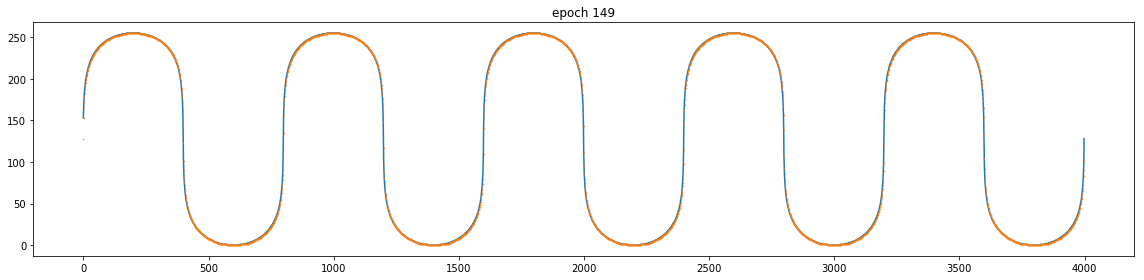

Batch 0 done
Batch 1 done
Batch 2 done
Batch 3 done
Batch 4 done
Batch 5 done
Batch 6 done
Batch 7 done
Batch 8 done
Batch 9 done
Batch 10 done
Batch 11 done
Batch 12 done
Batch 13 done
Batch 14 done
Batch 15 done
epoch 150, loss 0.00144887296483


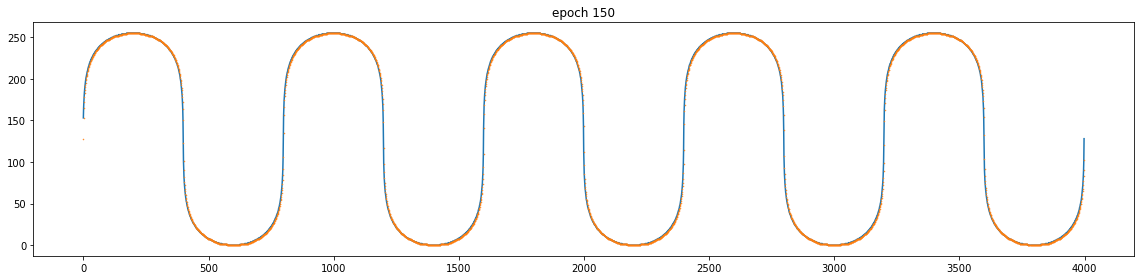

Batch 0 done
Batch 1 done
Batch 2 done
Batch 3 done
Batch 4 done
Batch 5 done
Batch 6 done
Batch 7 done
Batch 8 done
Batch 9 done
Batch 10 done
Batch 11 done
Batch 12 done
Batch 13 done
Batch 14 done
Batch 15 done
epoch 151, loss 0.00142273120582


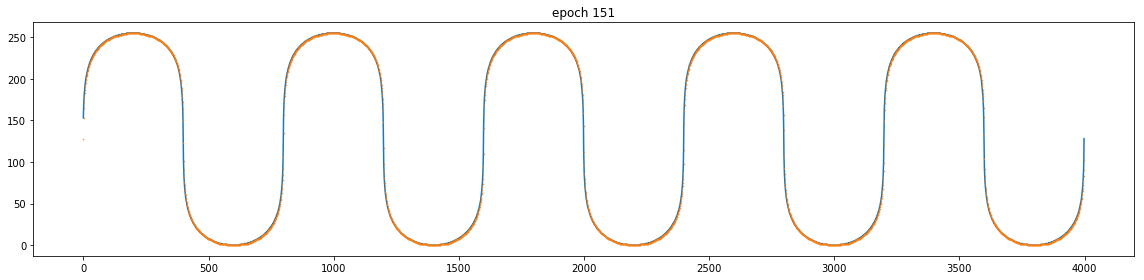

Batch 0 done
Batch 1 done
Batch 2 done
Batch 3 done
Batch 4 done
Batch 5 done
Batch 6 done
Batch 7 done
Batch 8 done
Batch 9 done
Batch 10 done
Batch 11 done
Batch 12 done
Batch 13 done
Batch 14 done
Batch 15 done
epoch 152, loss 0.00139707897324


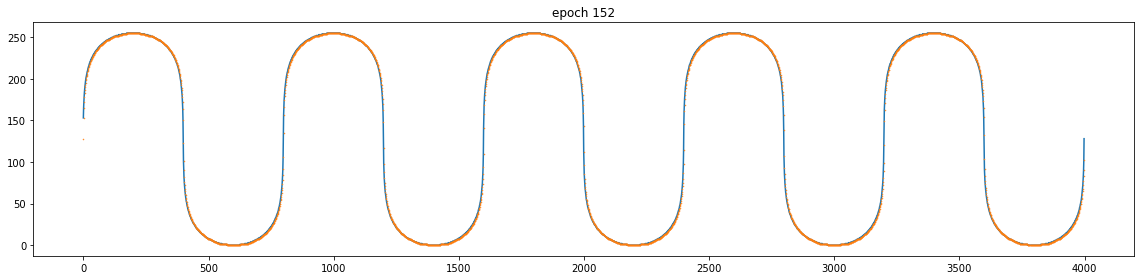

Batch 0 done
Batch 1 done
Batch 2 done
Batch 3 done
Batch 4 done
Batch 5 done
Batch 6 done
Batch 7 done
Batch 8 done
Batch 9 done
Batch 10 done
Batch 11 done
Batch 12 done
Batch 13 done
Batch 14 done
Batch 15 done
epoch 153, loss 0.00137233932037


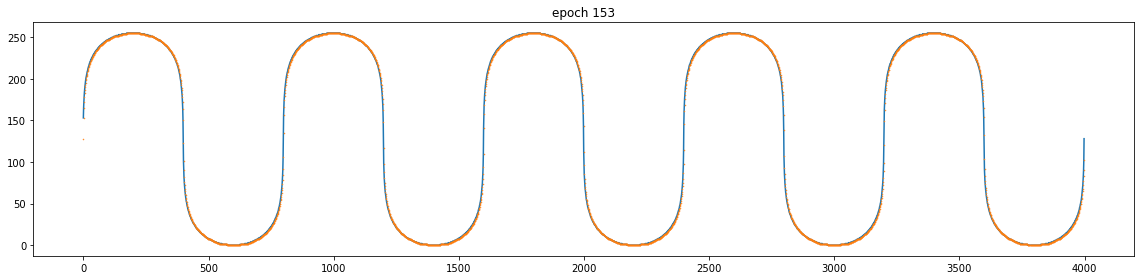

Batch 0 done
Batch 1 done
Batch 2 done
Batch 3 done
Batch 4 done
Batch 5 done
Batch 6 done
Batch 7 done
Batch 8 done
Batch 9 done
Batch 10 done
Batch 11 done
Batch 12 done
Batch 13 done
Batch 14 done
Batch 15 done
epoch 154, loss 0.00134835590143


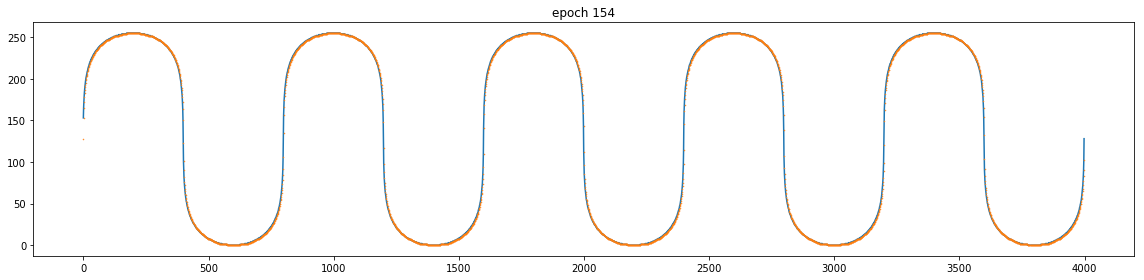

Batch 0 done
Batch 1 done
Batch 2 done
Batch 3 done
Batch 4 done
Batch 5 done
Batch 6 done
Batch 7 done
Batch 8 done
Batch 9 done
Batch 10 done
Batch 11 done
Batch 12 done
Batch 13 done
Batch 14 done
Batch 15 done
epoch 155, loss 0.00132519949693


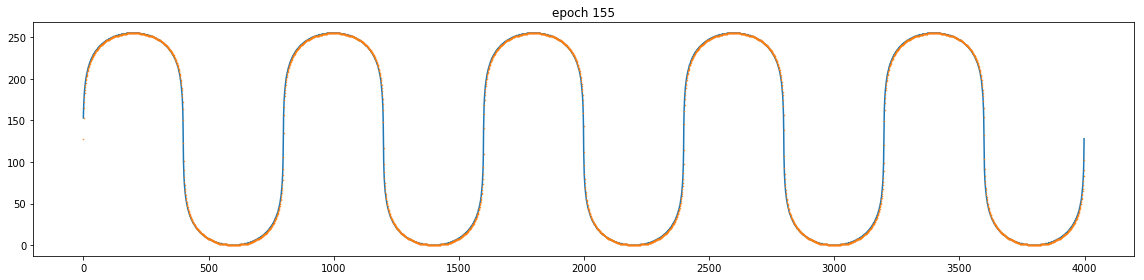

Batch 0 done
Batch 1 done
Batch 2 done
Batch 3 done
Batch 4 done
Batch 5 done
Batch 6 done
Batch 7 done
Batch 8 done
Batch 9 done
Batch 10 done
Batch 11 done
Batch 12 done
Batch 13 done
Batch 14 done
Batch 15 done
epoch 156, loss 0.00130289036315


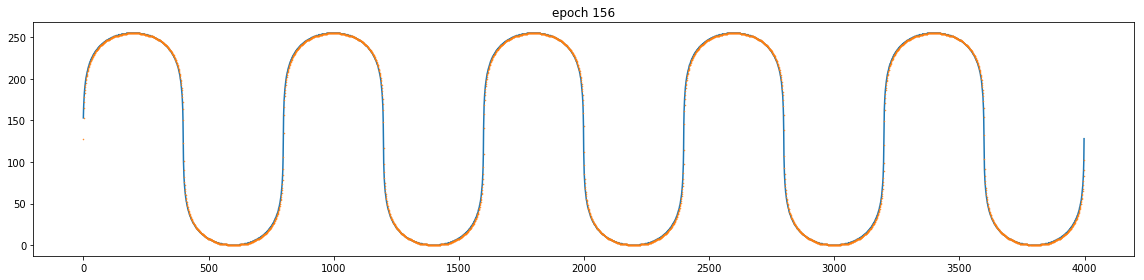

Batch 0 done
Batch 1 done
Batch 2 done
Batch 3 done
Batch 4 done
Batch 5 done
Batch 6 done
Batch 7 done
Batch 8 done
Batch 9 done
Batch 10 done
Batch 11 done
Batch 12 done
Batch 13 done
Batch 14 done
Batch 15 done
epoch 157, loss 0.00128124107141


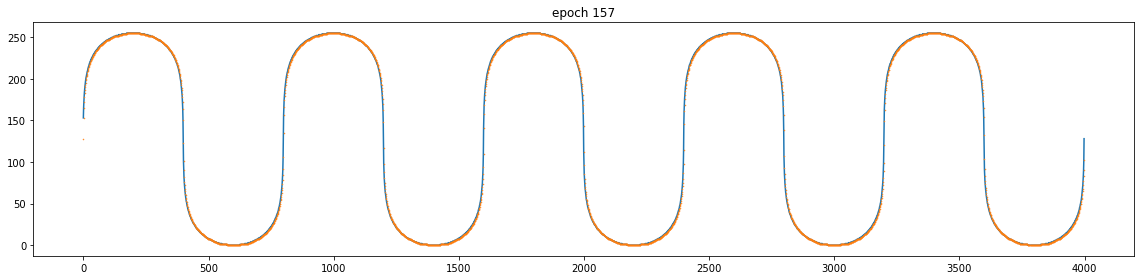

Batch 0 done
Batch 1 done
Batch 2 done
Batch 3 done
Batch 4 done
Batch 5 done
Batch 6 done
Batch 7 done
Batch 8 done
Batch 9 done
Batch 10 done
Batch 11 done
Batch 12 done
Batch 13 done
Batch 14 done
Batch 15 done
epoch 158, loss 0.00126030552201


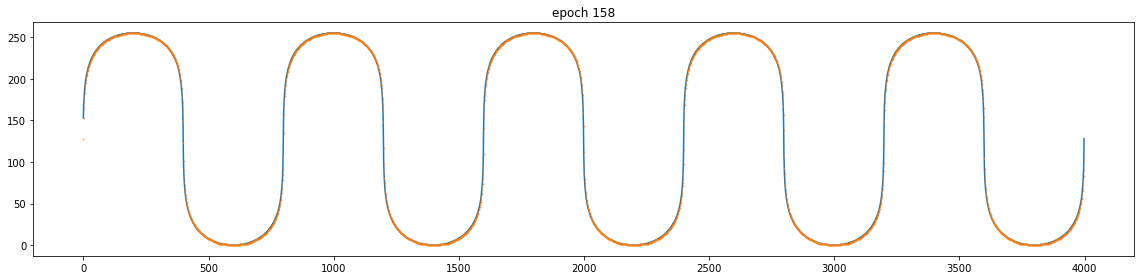

Batch 0 done
Batch 1 done
Batch 2 done
Batch 3 done
Batch 4 done
Batch 5 done
Batch 6 done
Batch 7 done
Batch 8 done
Batch 9 done
Batch 10 done
Batch 11 done
Batch 12 done
Batch 13 done
Batch 14 done
Batch 15 done
epoch 159, loss 0.00123996171169


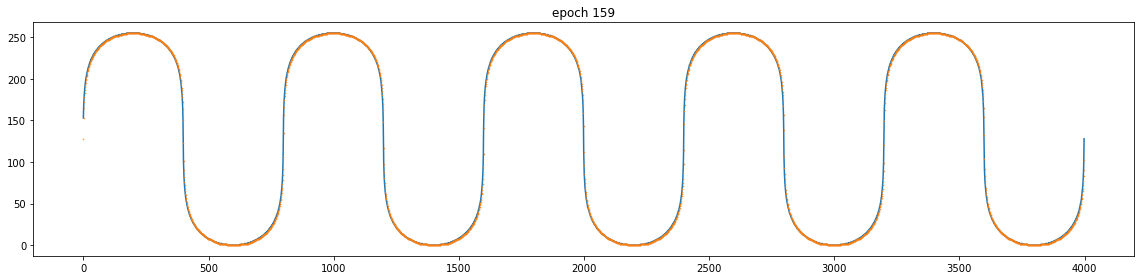

Batch 0 done
Batch 1 done
Batch 2 done
Batch 3 done
Batch 4 done
Batch 5 done
Batch 6 done
Batch 7 done
Batch 8 done
Batch 9 done
Batch 10 done
Batch 11 done
Batch 12 done
Batch 13 done
Batch 14 done
Batch 15 done
epoch 160, loss 0.00122039881535


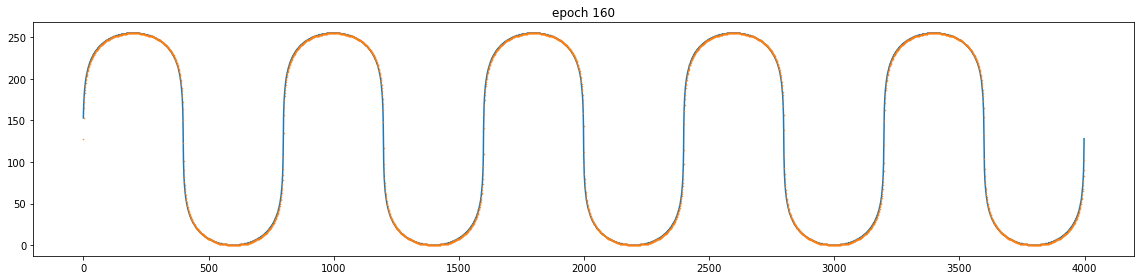

Batch 0 done
Batch 1 done
Batch 2 done
Batch 3 done
Batch 4 done
Batch 5 done
Batch 6 done
Batch 7 done
Batch 8 done
Batch 9 done
Batch 10 done
Batch 11 done
Batch 12 done
Batch 13 done
Batch 14 done
Batch 15 done
epoch 161, loss 0.00120153813623


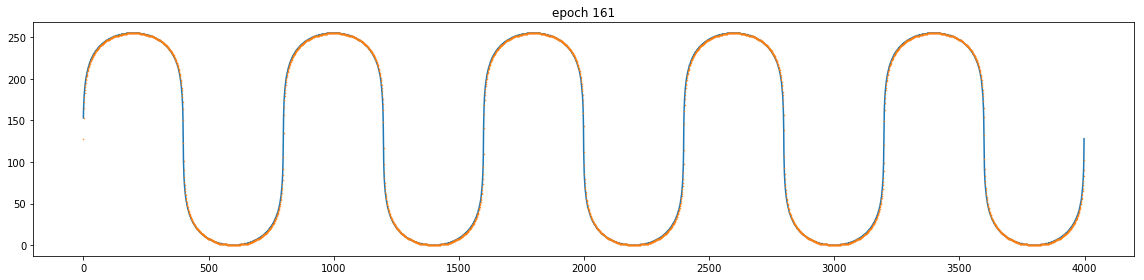

Batch 0 done
Batch 1 done
Batch 2 done
Batch 3 done
Batch 4 done
Batch 5 done
Batch 6 done
Batch 7 done
Batch 8 done
Batch 9 done
Batch 10 done
Batch 11 done
Batch 12 done
Batch 13 done
Batch 14 done
Batch 15 done
epoch 162, loss 0.00118320796173


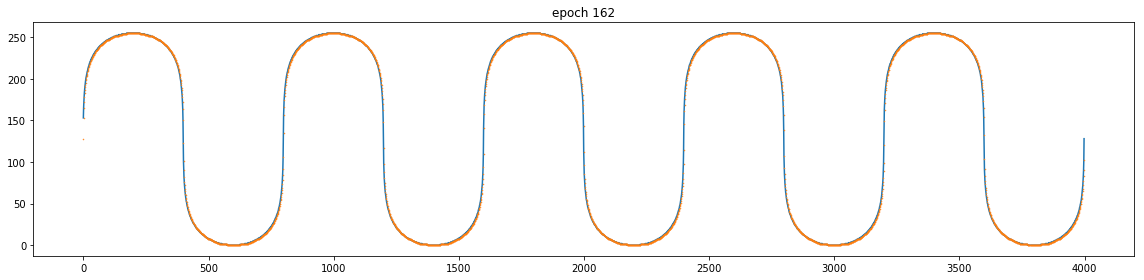

Batch 0 done
Batch 1 done
Batch 2 done
Batch 3 done
Batch 4 done
Batch 5 done
Batch 6 done
Batch 7 done
Batch 8 done
Batch 9 done
Batch 10 done
Batch 11 done
Batch 12 done
Batch 13 done
Batch 14 done
Batch 15 done
epoch 163, loss 0.00116542482283


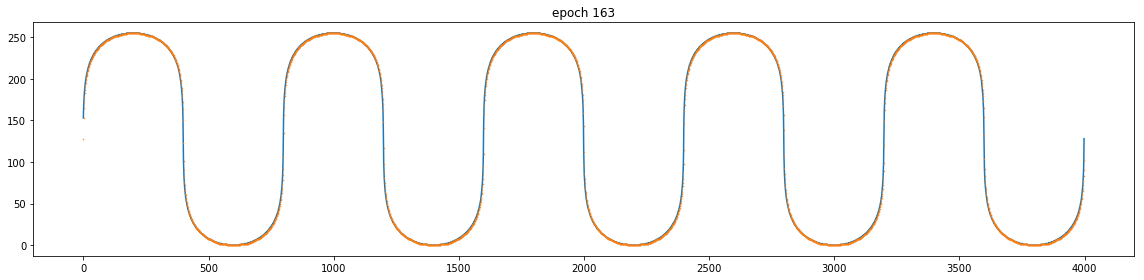

Batch 0 done
Batch 1 done
Batch 2 done
Batch 3 done
Batch 4 done
Batch 5 done
Batch 6 done
Batch 7 done
Batch 8 done
Batch 9 done
Batch 10 done
Batch 11 done
Batch 12 done
Batch 13 done
Batch 14 done
Batch 15 done
epoch 164, loss 0.00114816613495


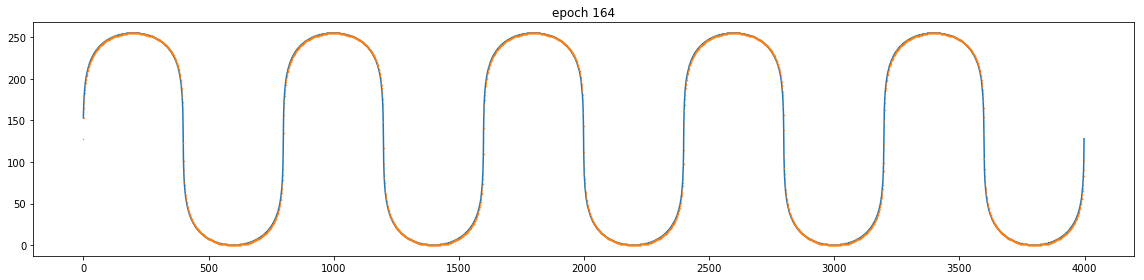

Batch 0 done
Batch 1 done
Batch 2 done
Batch 3 done
Batch 4 done
Batch 5 done
Batch 6 done
Batch 7 done
Batch 8 done
Batch 9 done
Batch 10 done
Batch 11 done
Batch 12 done
Batch 13 done
Batch 14 done
Batch 15 done
epoch 165, loss 0.0011313984869


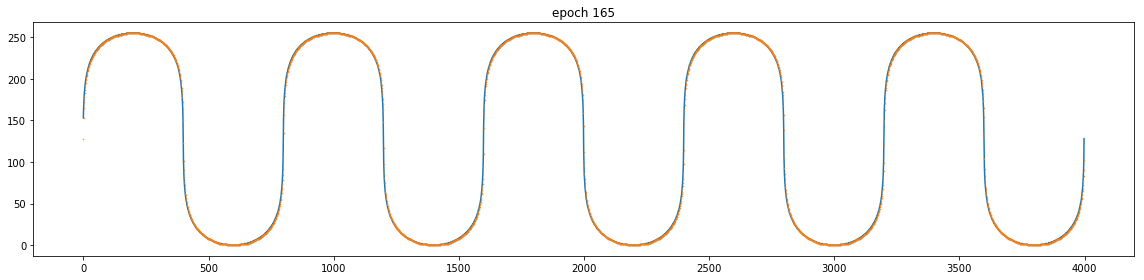

Batch 0 done
Batch 1 done
Batch 2 done
Batch 3 done
Batch 4 done
Batch 5 done
Batch 6 done
Batch 7 done
Batch 8 done
Batch 9 done
Batch 10 done
Batch 11 done
Batch 12 done
Batch 13 done
Batch 14 done
Batch 15 done
epoch 166, loss 0.00111507519614


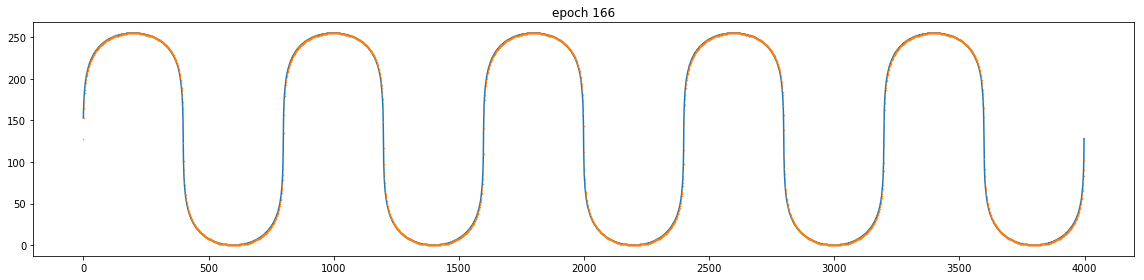

Batch 0 done
Batch 1 done
Batch 2 done
Batch 3 done
Batch 4 done
Batch 5 done
Batch 6 done
Batch 7 done
Batch 8 done
Batch 9 done
Batch 10 done
Batch 11 done
Batch 12 done
Batch 13 done
Batch 14 done
Batch 15 done
epoch 167, loss 0.00109917658847


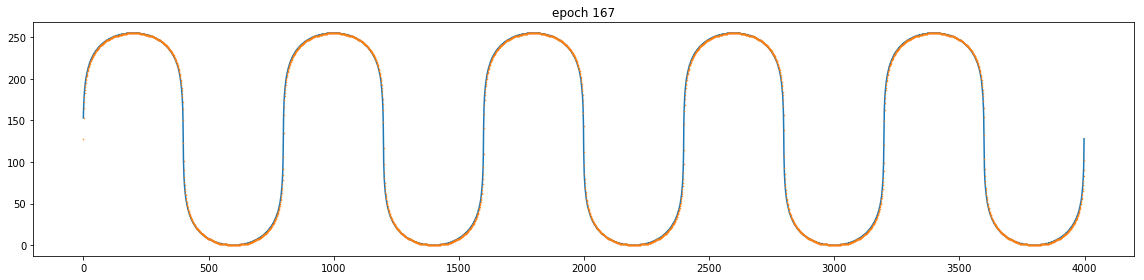

Batch 0 done
Batch 1 done
Batch 2 done
Batch 3 done
Batch 4 done
Batch 5 done
Batch 6 done
Batch 7 done
Batch 8 done
Batch 9 done
Batch 10 done
Batch 11 done
Batch 12 done
Batch 13 done
Batch 14 done
Batch 15 done
epoch 168, loss 0.00108370755333


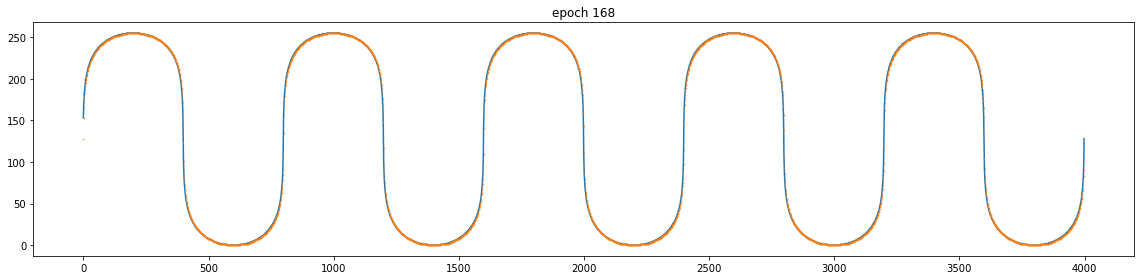

Batch 0 done
Batch 1 done
Batch 2 done
Batch 3 done
Batch 4 done
Batch 5 done
Batch 6 done
Batch 7 done
Batch 8 done
Batch 9 done
Batch 10 done
Batch 11 done
Batch 12 done
Batch 13 done
Batch 14 done
Batch 15 done
epoch 169, loss 0.00106862722896


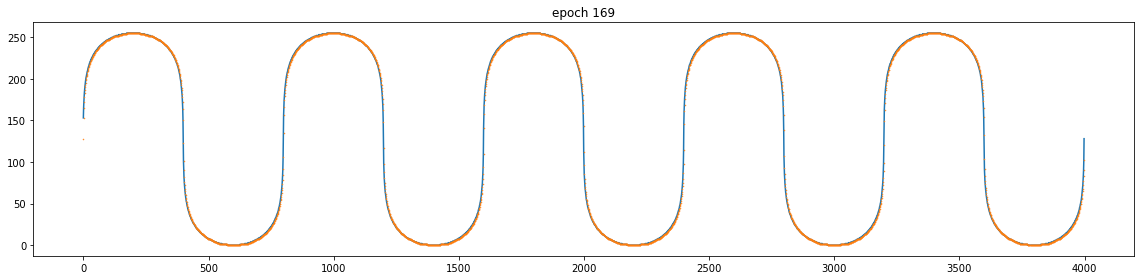

Batch 0 done
Batch 1 done
Batch 2 done
Batch 3 done
Batch 4 done
Batch 5 done
Batch 6 done
Batch 7 done
Batch 8 done
Batch 9 done
Batch 10 done
Batch 11 done
Batch 12 done
Batch 13 done
Batch 14 done
Batch 15 done
epoch 170, loss 0.00105394446291


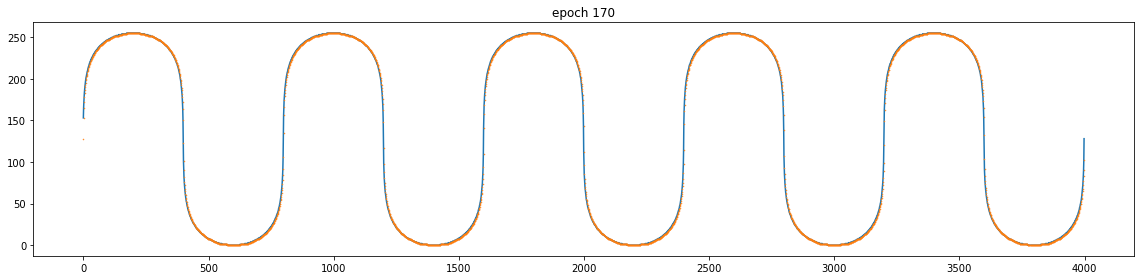

Batch 0 done
Batch 1 done
Batch 2 done
Batch 3 done
Batch 4 done
Batch 5 done
Batch 6 done
Batch 7 done
Batch 8 done
Batch 9 done
Batch 10 done
Batch 11 done
Batch 12 done
Batch 13 done
Batch 14 done
Batch 15 done
epoch 171, loss 0.00103963934816


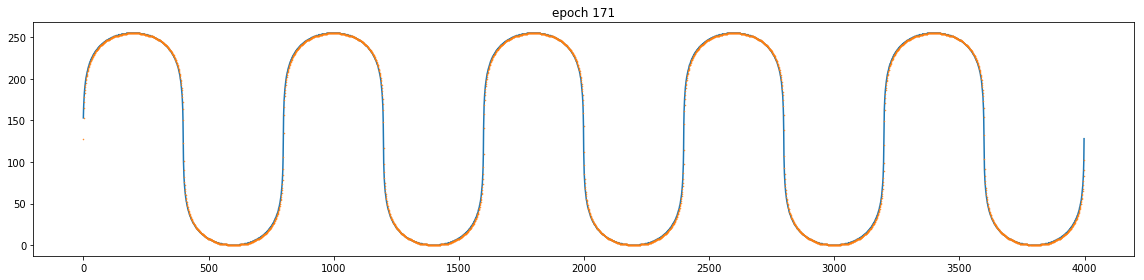

Batch 0 done
Batch 1 done
Batch 2 done
Batch 3 done
Batch 4 done
Batch 5 done
Batch 6 done
Batch 7 done
Batch 8 done
Batch 9 done
Batch 10 done
Batch 11 done
Batch 12 done
Batch 13 done
Batch 14 done
Batch 15 done
epoch 172, loss 0.00102570536546


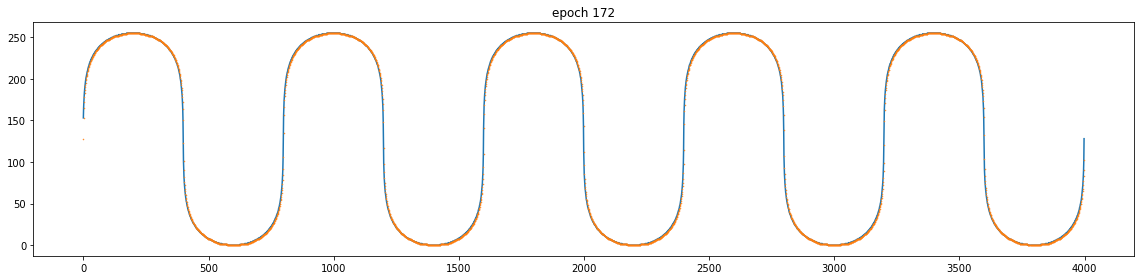

Batch 0 done
Batch 1 done
Batch 2 done
Batch 3 done
Batch 4 done
Batch 5 done
Batch 6 done
Batch 7 done
Batch 8 done
Batch 9 done
Batch 10 done
Batch 11 done
Batch 12 done
Batch 13 done
Batch 14 done
Batch 15 done
epoch 173, loss 0.00101211562287


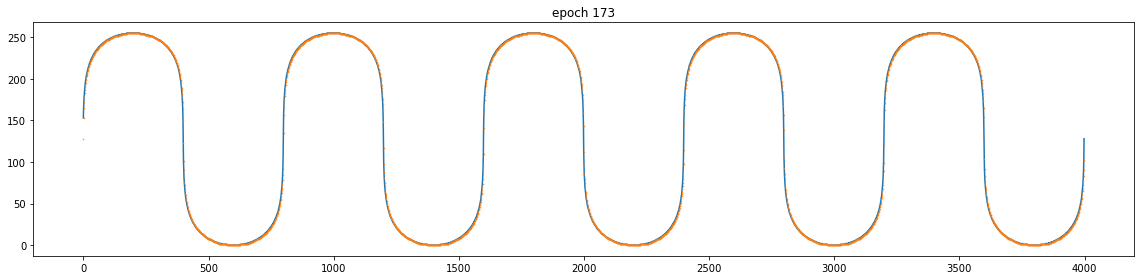

Batch 0 done
Batch 1 done
Batch 2 done
Batch 3 done
Batch 4 done
Batch 5 done
Batch 6 done
Batch 7 done
Batch 8 done
Batch 9 done
Batch 10 done
Batch 11 done
Batch 12 done
Batch 13 done
Batch 14 done
Batch 15 done
epoch 174, loss 0.000998866045848


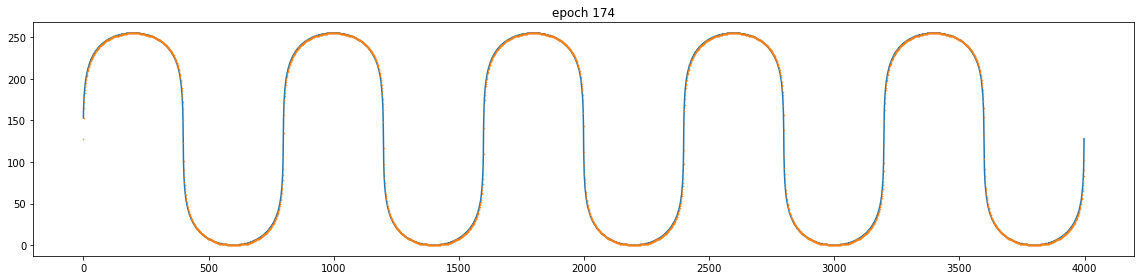

Batch 0 done
Batch 1 done
Batch 2 done
Batch 3 done
Batch 4 done
Batch 5 done
Batch 6 done
Batch 7 done
Batch 8 done
Batch 9 done
Batch 10 done
Batch 11 done
Batch 12 done
Batch 13 done
Batch 14 done
Batch 15 done
epoch 175, loss 0.000985952210613


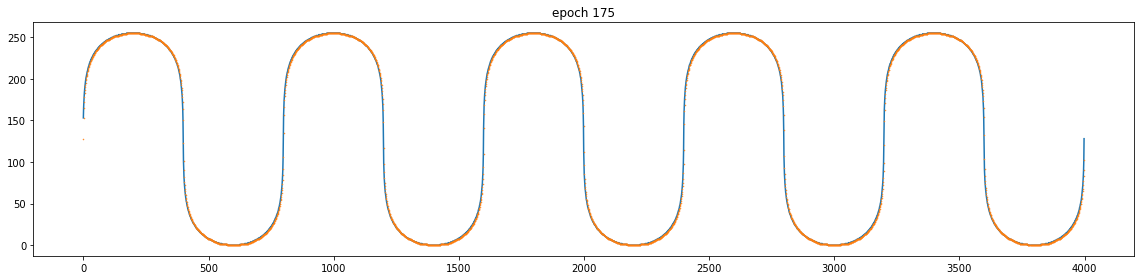

Batch 0 done
Batch 1 done
Batch 2 done
Batch 3 done
Batch 4 done
Batch 5 done
Batch 6 done
Batch 7 done
Batch 8 done
Batch 9 done
Batch 10 done
Batch 11 done
Batch 12 done
Batch 13 done
Batch 14 done
Batch 15 done
epoch 176, loss 0.000973346584942


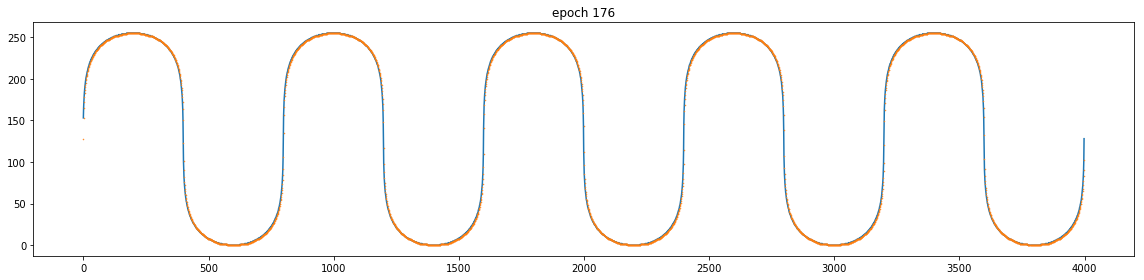

Batch 0 done
Batch 1 done
Batch 2 done
Batch 3 done
Batch 4 done
Batch 5 done
Batch 6 done
Batch 7 done
Batch 8 done
Batch 9 done
Batch 10 done
Batch 11 done
Batch 12 done
Batch 13 done
Batch 14 done
Batch 15 done
epoch 177, loss 0.000961049401667


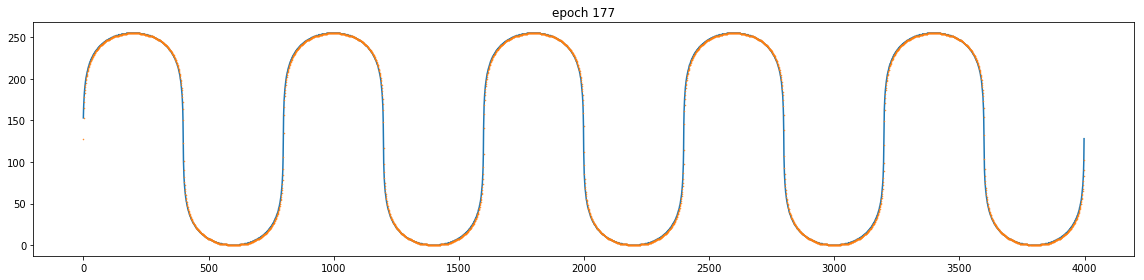

Batch 0 done
Batch 1 done
Batch 2 done
Batch 3 done
Batch 4 done
Batch 5 done
Batch 6 done
Batch 7 done
Batch 8 done
Batch 9 done
Batch 10 done
Batch 11 done
Batch 12 done
Batch 13 done
Batch 14 done
Batch 15 done
epoch 178, loss 0.000949017703533


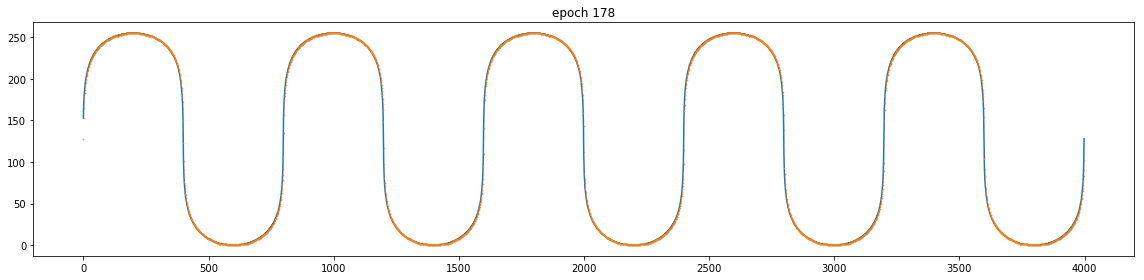

Batch 0 done
Batch 1 done
Batch 2 done
Batch 3 done
Batch 4 done
Batch 5 done
Batch 6 done
Batch 7 done
Batch 8 done
Batch 9 done
Batch 10 done
Batch 11 done
Batch 12 done
Batch 13 done
Batch 14 done
Batch 15 done
epoch 179, loss 0.000937251548748


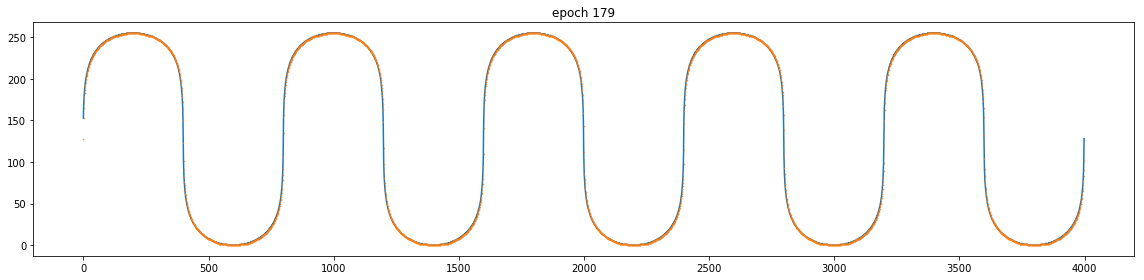

Batch 0 done
Batch 1 done
Batch 2 done
Batch 3 done
Batch 4 done
Batch 5 done
Batch 6 done
Batch 7 done
Batch 8 done
Batch 9 done
Batch 10 done
Batch 11 done
Batch 12 done
Batch 13 done
Batch 14 done
Batch 15 done
epoch 180, loss 0.000925757165533


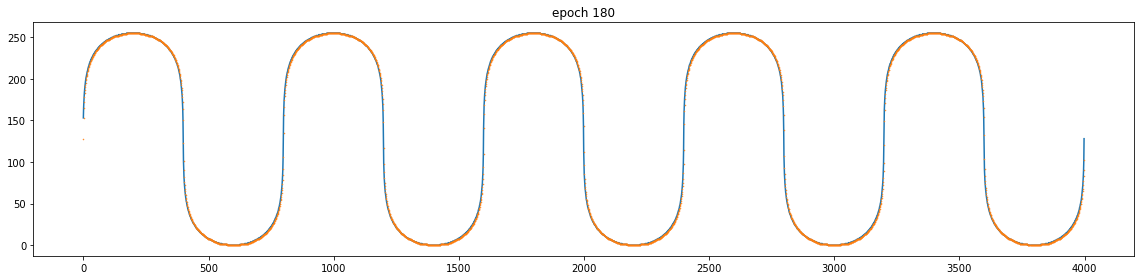

Batch 0 done
Batch 1 done
Batch 2 done
Batch 3 done
Batch 4 done
Batch 5 done
Batch 6 done
Batch 7 done
Batch 8 done
Batch 9 done
Batch 10 done
Batch 11 done
Batch 12 done
Batch 13 done
Batch 14 done
Batch 15 done
epoch 181, loss 0.000914516800549


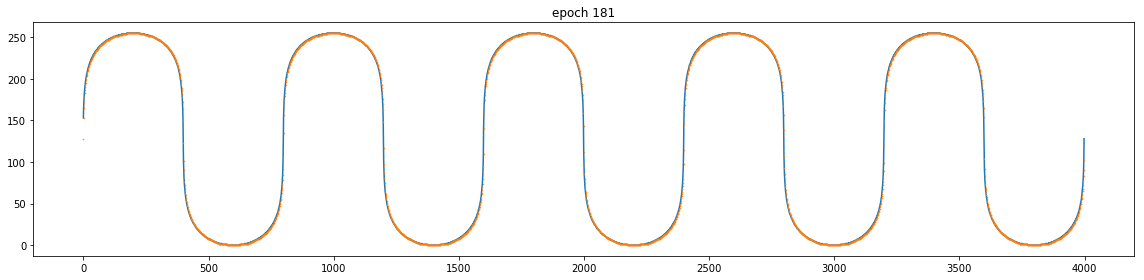

Batch 0 done
Batch 1 done
Batch 2 done
Batch 3 done
Batch 4 done
Batch 5 done
Batch 6 done
Batch 7 done
Batch 8 done
Batch 9 done
Batch 10 done
Batch 11 done
Batch 12 done
Batch 13 done
Batch 14 done
Batch 15 done
epoch 182, loss 0.000903508393094


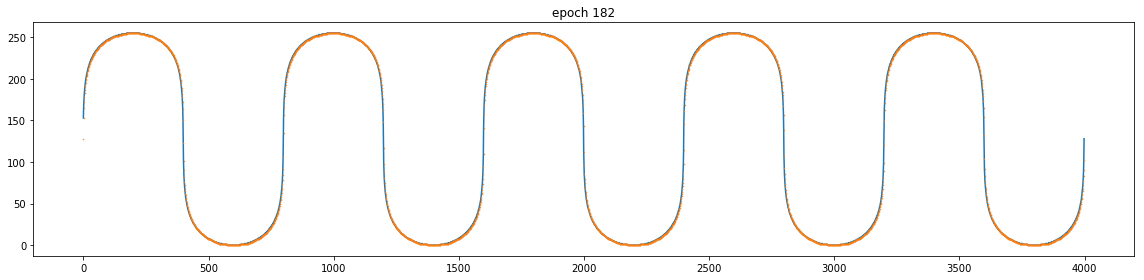

Batch 0 done
Batch 1 done
Batch 2 done
Batch 3 done
Batch 4 done
Batch 5 done
Batch 6 done
Batch 7 done
Batch 8 done
Batch 9 done
Batch 10 done
Batch 11 done
Batch 12 done
Batch 13 done
Batch 14 done
Batch 15 done
epoch 183, loss 0.000892732234206


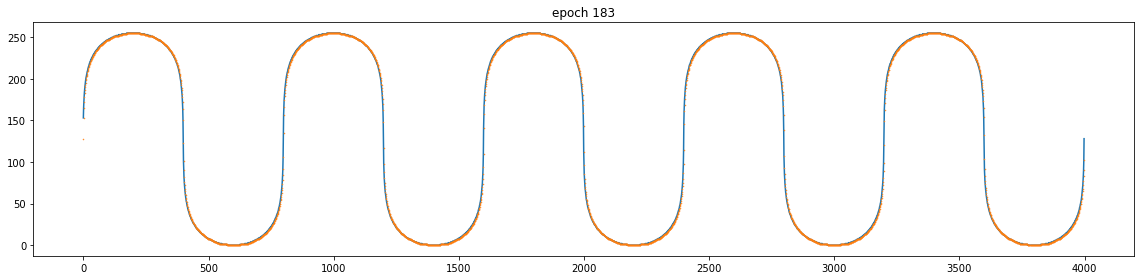

Batch 0 done
Batch 1 done
Batch 2 done
Batch 3 done
Batch 4 done
Batch 5 done
Batch 6 done
Batch 7 done
Batch 8 done
Batch 9 done
Batch 10 done
Batch 11 done
Batch 12 done
Batch 13 done
Batch 14 done
Batch 15 done
epoch 184, loss 0.000882192573044


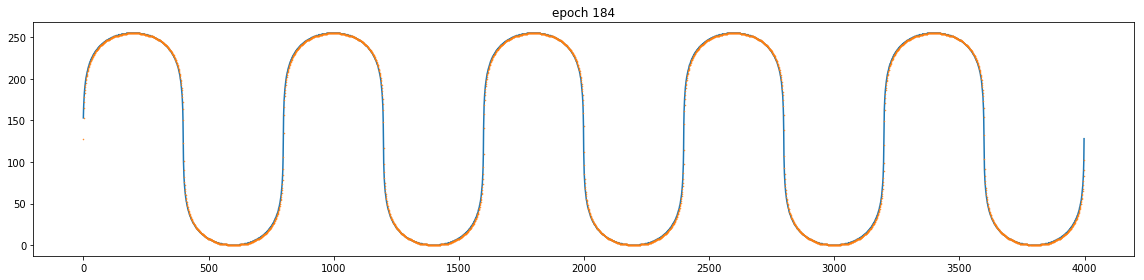

Batch 0 done
Batch 1 done
Batch 2 done
Batch 3 done
Batch 4 done
Batch 5 done
Batch 6 done
Batch 7 done
Batch 8 done
Batch 9 done
Batch 10 done
Batch 11 done
Batch 12 done
Batch 13 done
Batch 14 done
Batch 15 done
epoch 185, loss 0.000871876312885


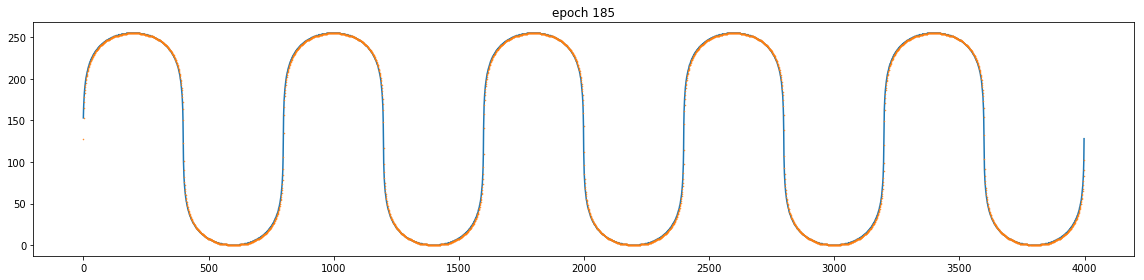

Batch 0 done
Batch 1 done
Batch 2 done
Batch 3 done
Batch 4 done
Batch 5 done
Batch 6 done
Batch 7 done
Batch 8 done
Batch 9 done
Batch 10 done
Batch 11 done
Batch 12 done
Batch 13 done
Batch 14 done
Batch 15 done
epoch 186, loss 0.000861758133397


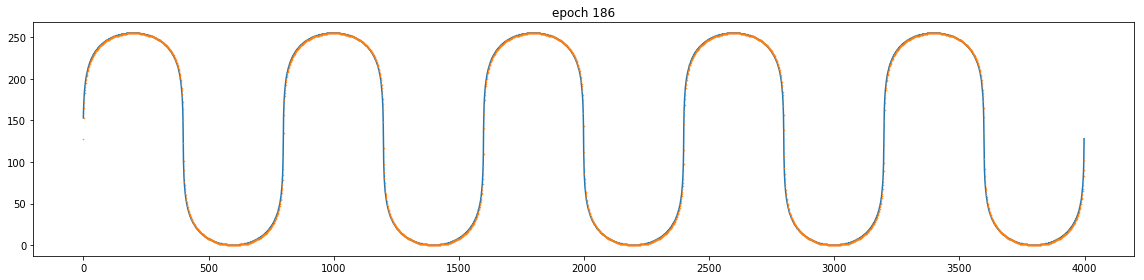

Batch 0 done
Batch 1 done
Batch 2 done
Batch 3 done
Batch 4 done
Batch 5 done
Batch 6 done
Batch 7 done
Batch 8 done
Batch 9 done
Batch 10 done
Batch 11 done
Batch 12 done
Batch 13 done
Batch 14 done
Batch 15 done
epoch 187, loss 0.000851850258186


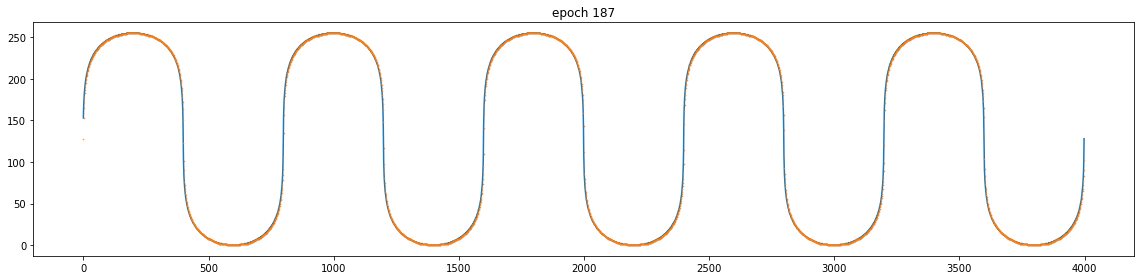

Batch 0 done
Batch 1 done
Batch 2 done
Batch 3 done
Batch 4 done
Batch 5 done
Batch 6 done
Batch 7 done
Batch 8 done
Batch 9 done
Batch 10 done
Batch 11 done
Batch 12 done
Batch 13 done
Batch 14 done
Batch 15 done
epoch 188, loss 0.000842140289024


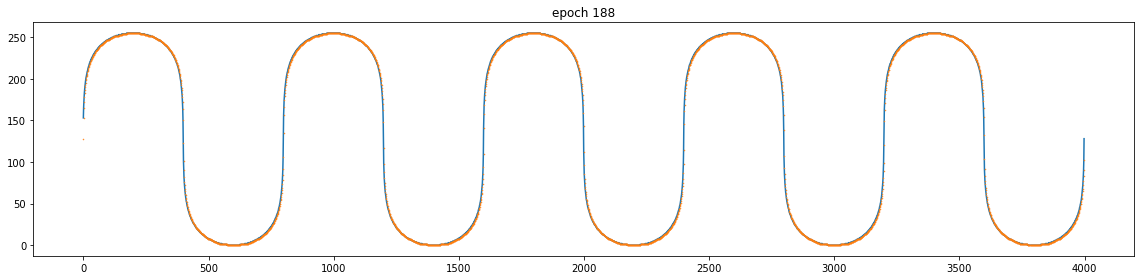

Batch 0 done
Batch 1 done
Batch 2 done
Batch 3 done
Batch 4 done
Batch 5 done
Batch 6 done
Batch 7 done
Batch 8 done
Batch 9 done
Batch 10 done
Batch 11 done
Batch 12 done
Batch 13 done
Batch 14 done
Batch 15 done
epoch 189, loss 0.000832634745166


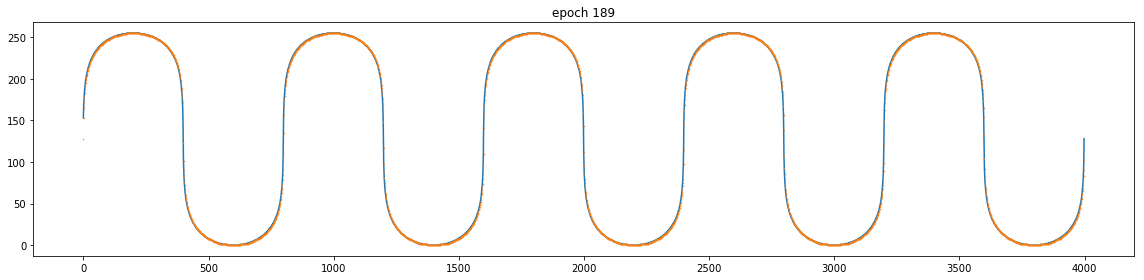

Batch 0 done
Batch 1 done
Batch 2 done
Batch 3 done
Batch 4 done
Batch 5 done
Batch 6 done
Batch 7 done
Batch 8 done
Batch 9 done
Batch 10 done
Batch 11 done
Batch 12 done
Batch 13 done
Batch 14 done
Batch 15 done
epoch 190, loss 0.00082331080921


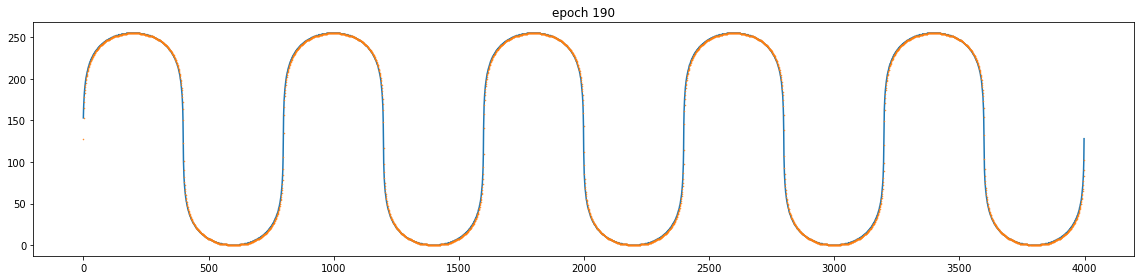

Batch 0 done
Batch 1 done
Batch 2 done
Batch 3 done
Batch 4 done
Batch 5 done
Batch 6 done
Batch 7 done
Batch 8 done
Batch 9 done
Batch 10 done
Batch 11 done
Batch 12 done
Batch 13 done
Batch 14 done
Batch 15 done
epoch 191, loss 0.000814175931737


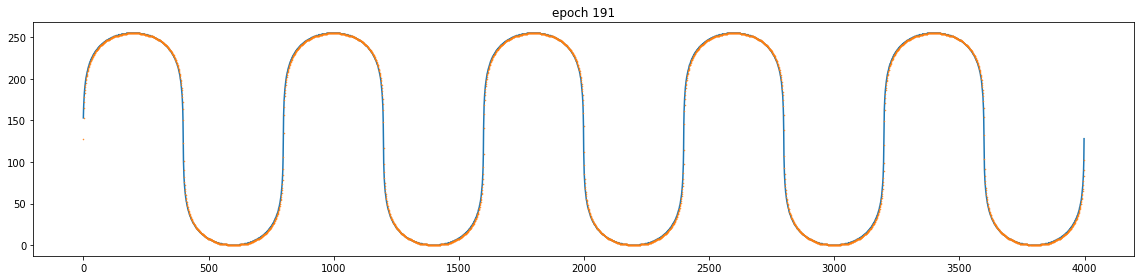

Batch 0 done
Batch 1 done
Batch 2 done
Batch 3 done
Batch 4 done
Batch 5 done
Batch 6 done
Batch 7 done
Batch 8 done
Batch 9 done
Batch 10 done
Batch 11 done
Batch 12 done
Batch 13 done
Batch 14 done
Batch 15 done
epoch 192, loss 0.000805203570053


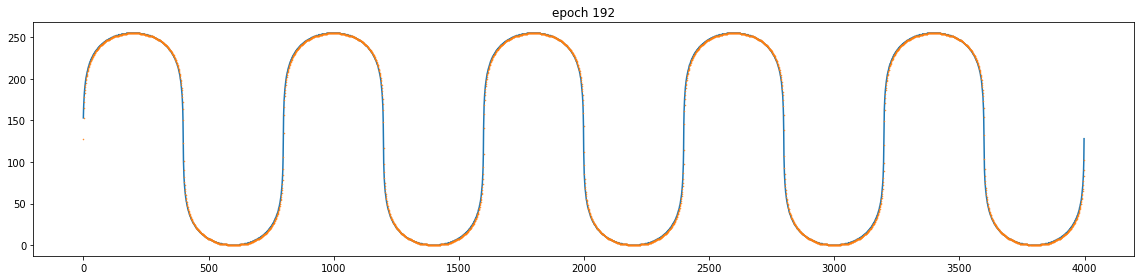

Batch 0 done
Batch 1 done
Batch 2 done
Batch 3 done
Batch 4 done
Batch 5 done
Batch 6 done
Batch 7 done
Batch 8 done
Batch 9 done
Batch 10 done
Batch 11 done
Batch 12 done
Batch 13 done
Batch 14 done
Batch 15 done
epoch 193, loss 0.000796410313342


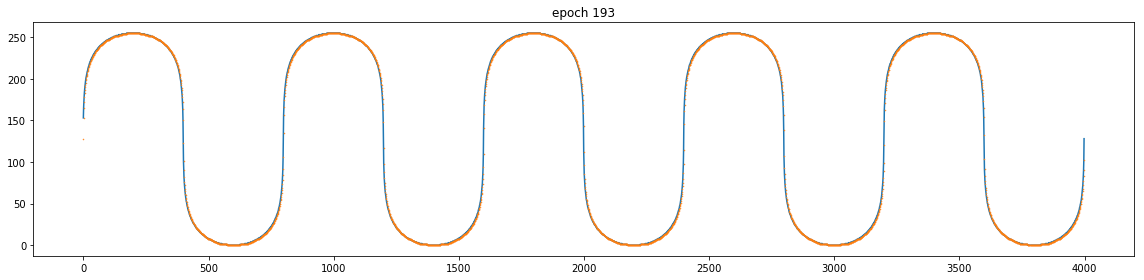

Batch 0 done
Batch 1 done
Batch 2 done
Batch 3 done
Batch 4 done
Batch 5 done
Batch 6 done
Batch 7 done
Batch 8 done
Batch 9 done
Batch 10 done
Batch 11 done
Batch 12 done
Batch 13 done
Batch 14 done
Batch 15 done
epoch 194, loss 0.000787784927525


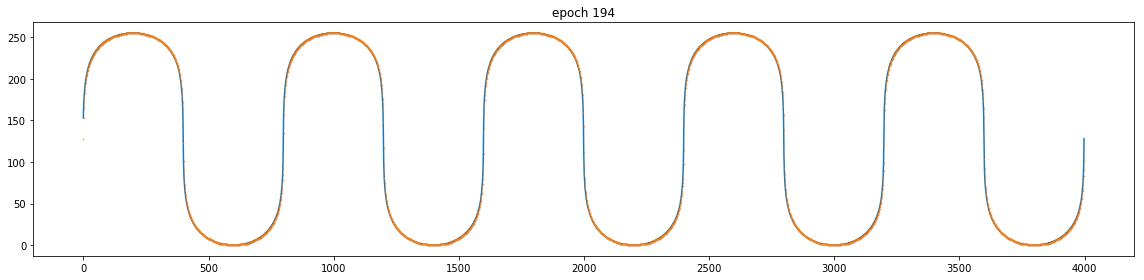

Batch 0 done
Batch 1 done
Batch 2 done
Batch 3 done
Batch 4 done
Batch 5 done
Batch 6 done
Batch 7 done
Batch 8 done
Batch 9 done
Batch 10 done
Batch 11 done
Batch 12 done
Batch 13 done
Batch 14 done
Batch 15 done
epoch 195, loss 0.000779312336817


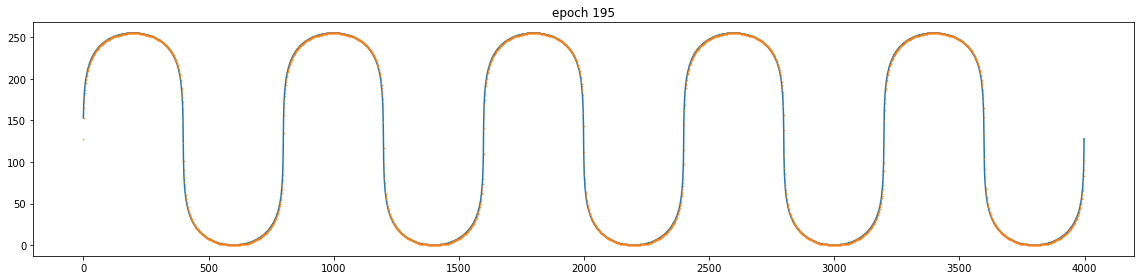

Batch 0 done
Batch 1 done
Batch 2 done
Batch 3 done
Batch 4 done
Batch 5 done
Batch 6 done
Batch 7 done
Batch 8 done
Batch 9 done
Batch 10 done
Batch 11 done
Batch 12 done
Batch 13 done
Batch 14 done
Batch 15 done
epoch 196, loss 0.000770997547079


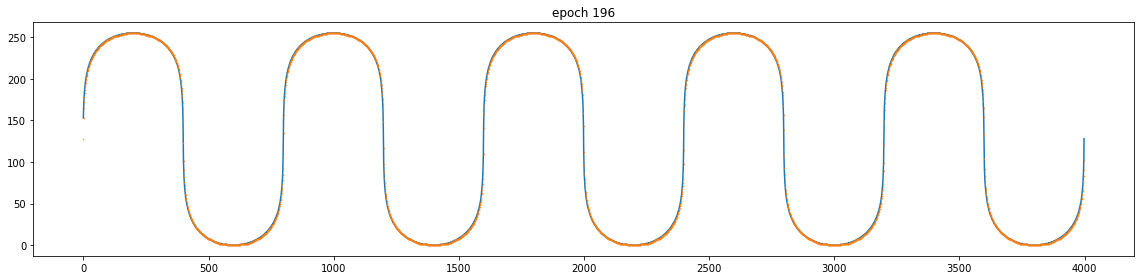

Batch 0 done
Batch 1 done
Batch 2 done
Batch 3 done
Batch 4 done
Batch 5 done
Batch 6 done
Batch 7 done
Batch 8 done
Batch 9 done
Batch 10 done
Batch 11 done
Batch 12 done
Batch 13 done
Batch 14 done
Batch 15 done
epoch 197, loss 0.000762827636208


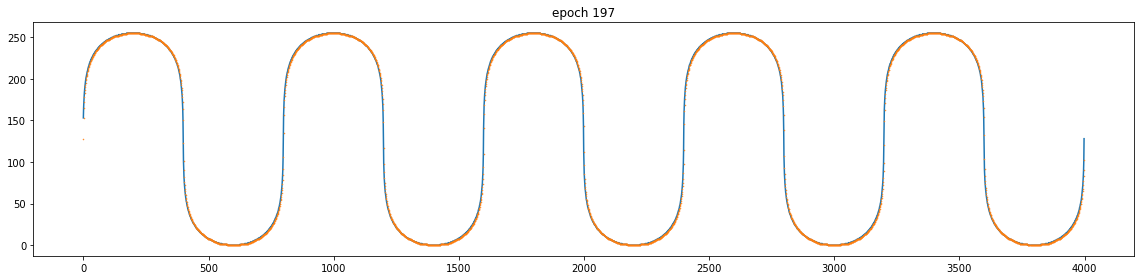

Batch 0 done
Batch 1 done
Batch 2 done
Batch 3 done
Batch 4 done
Batch 5 done
Batch 6 done
Batch 7 done
Batch 8 done
Batch 9 done
Batch 10 done
Batch 11 done
Batch 12 done
Batch 13 done
Batch 14 done
Batch 15 done
epoch 198, loss 0.000754800566938


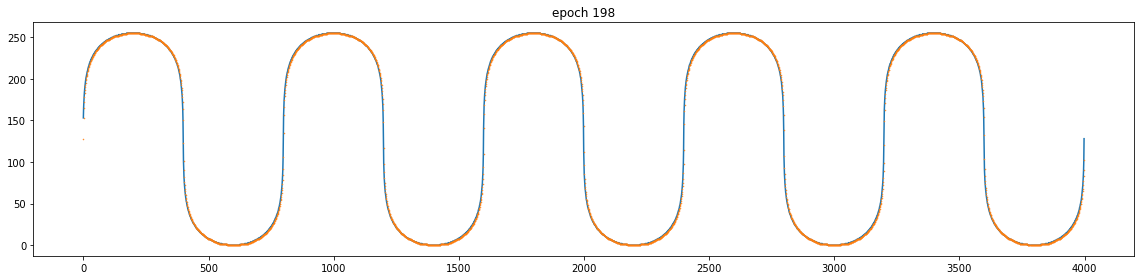

Batch 0 done
Batch 1 done
Batch 2 done
Batch 3 done
Batch 4 done
Batch 5 done
Batch 6 done
Batch 7 done
Batch 8 done
Batch 9 done
Batch 10 done
Batch 11 done
Batch 12 done
Batch 13 done
Batch 14 done
Batch 15 done
epoch 199, loss 0.000746917852666


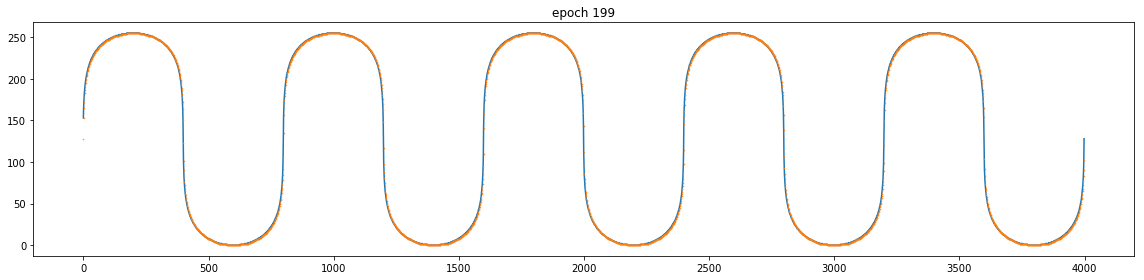

In [8]:
net = WaveNet()

optimizer = optim.Adam(net.parameters(),lr=0.001)

batch_size = 16
max_epoch = 200
loss_save = []

for epoch in range(max_epoch):
    optimizer.zero_grad()
    loss = 0
    for ind in range(batch_size):
        batch = next(g)
        batch = Variable(mu_encoder(batch).type(torch.LongTensor))
        x = batch[0][0][:-1]
        logits = net(x)
        sz = logits.size(0)
        loss = loss + nn.functional.cross_entropy(logits, batch[0][0][-sz:])
        print("Batch " + str(ind) + " done")
    loss = loss/batch_size
    loss.backward()
    optimizer.step()
    loss_save.append(loss.data[0])
    
    # monitor progress
    if epoch%1 == 0:
        print('epoch {}, loss {}'.format(epoch, loss.data[0]))
        batch = next(g)
        batch = Variable(mu_encoder(batch).type(torch.LongTensor))
        x = batch[0][0][:-1]
        logits = net(x)
        _, i = logits.max(dim=1)
        plt.figure(figsize=[16,4])
        plt.plot(i.data.tolist())
        plt.plot(x.data.tolist(),'.',ms=1)
        plt.title('epoch {}'.format(epoch))
        plt.tight_layout()
        plt.show()

In [9]:
torch.save(net.state_dict(), "model.pkl")
torch.save(net.state_dict(), "model.pt")
torch.save(net.state_dict(), "model.pth")

torch.save(net, "model1.pkl")
torch.save(net, "model1.pt")
torch.save(net, "model1.pth")

/home/ubuntu/anaconda2/lib/python2.7/site-packages/torch/serialization.py:158: UserWarning: Couldn't retrieve source code for container of type WaveNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/ubuntu/anaconda2/lib/python2.7/site-packages/torch/serialization.py:158: UserWarning: Couldn't retrieve source code for container of type OneHot. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/ubuntu/anaconda2/lib/python2.7/site-packages/torch/serialization.py:158: UserWarning: Couldn't retrieve source code for container of type CausalConv1d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [ ]:
batch = next(g)
batch = batch.numpy()
n = 3
predict_save = []

for _ in range(n):
    temp = torch.from_numpy(batch)
    x = Variable(mu_encoder(temp).type(torch.LongTensor))
    inputs = x[0][0][:-1]
    
    predict = net(inputs)
    _, i = predict.max(dim=1)
    predict_save.append(i.data[-1])
    x = np.roll(x, -1, axis=2)
    x[0][0][-1] = i.data[-1]

In [ ]:
plt.figure(figsize=[8,6])
plt.plot(predict_save)
plt.xlim([0, 10])